In [1]:
# Setup
import pandas as pd
import numpy as np
import git
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, sampler
import torchvision.transforms as T

import matplotlib.pyplot as plt
%matplotlib inline

repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir
dtype=torch.float32

from barebone import *
from model_util import *

USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

/opt/conda/envs/posedemo/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load keypoints

In [2]:
subjects = np.load("{}/preprocessing/poseformer/subjects.npy".format(homedir))
keypoints3d = np.load("{}/preprocessing/poseformer/joints_3d_padded.npy".format(homedir))
print(keypoints3d.shape)

(384, 1511, 17, 3)


In [3]:
num_samples = keypoints3d.shape[0]
keypoints3d = keypoints3d.reshape((num_samples, -1))      # Flatten frame, joint and coordinates
df_kp3d = pd.DataFrame(keypoints3d)
df_kp3d.insert(0, 'subjectid', subjects)

df_kp3d

subjectid    0    1         2         3         4         5  \
0                  kEC7G8DP  0.0  0.0  0.553803  0.118477  0.048315  0.559740   
1                  GjPHiGli  0.0  0.0  0.743547  0.134699  0.026321  0.732065   
2                  RFibHPt7  0.0  0.0  0.603302  0.016389  0.139365  0.610147   
3                  gO7Cpt1X  0.0  0.0  0.567537  0.071610 -0.120018  0.568075   
4                  xEIsrkiR  0.0  0.0  0.576566  0.126515 -0.013554  0.562857   
..                      ...  ...  ...       ...       ...       ...       ...   
379  VID_20230506_175810340  0.0  0.0  1.006987  0.139903 -0.019908  0.980886   
380                8elUiJYv  0.0  0.0  0.630345  0.098289  0.083985  0.633622   
381  PXL_20230505_234002299  0.0  0.0  0.920654  0.071631 -0.096997  0.898501   
382                q8FyLMSn  0.0  0.0  0.620147  0.140228  0.037624  0.613141   
383                pmYdj2Zc  0.0  0.0  0.845058  0.019990  0.057908  0.821042   

            6         7         8  ...  77051  77052  77053  77054  77055  \
0    0.078025  0.448527  0.405209  ...    0.0    0.0    0.0    0.0    0.0   
1   -0.058176  0.387448  0.505844  ...    0.0    0.0    0.0    0.0    0.0   
2   -0.268166  0.238692  0.415880  ...    0.0    0.0    0.0    0.0    0.0   
3    0.469379  0.117718  0.449701  ...    0.0    0.0    0.0    0.0    0.0   
4    0.010256  0.230066  0.288412  ...    0.0    0.0    0.0    0.0    0.0   
..        ...       ...       ...  ...    ...    ...    ...    ...    ...   
379  0.106557  0.084857  0.421844  ...    0.0    0.0    0.0    0.0    0.0   
380  0.120486  0.398054  0.393028  ...    0.0    0.0    0.0    0.0    0.0   
381  0.042036 -0.115334  0.418619  ...    0.0    0.0    0.0    0.0    0.0   
382  0.192907  0.430776  0.407713  ...    0.0    0.0    0.0    0.0    0.0   
383  0.170526 -0.006771  0.373800  ...    0.0    0.0    0.0    0.0    0.0   

     77056  77057  77058  77059  77060  
0      0.0    0.0    0.0    0.0    0.0  
1      0.0    0.0    0.0    0.0    0.0  
2      0.0    0.0    0.0    0.0    0.0  
3      0.0    0.0    0.0    0.0    0.0  
4      0.0    0.0    0.0    0.0    0.0  
..     ...    ...    ...    ...    ...  
379    0.0    0.0    0.0    0.0    0.0  
380    0.0    0.0    0.0    0.0    0.0  
381    0.0    0.0    0.0    0.0    0.0  
382    0.0    0.0    0.0    0.0    0.0  
383    0.0    0.0    0.0    0.0    0.0  

[384 rows x 77062 columns]

### Load Survey Data (labels)

In [4]:
df_survey = pd.read_csv(r'https://raw.githubusercontent.com/amandaliusa/cs231n/main/data/survey_data.csv')
df_survey

subjectid  OA_check
0    kGhQ1FQc         1
1    KyINSk8e         0
2    ybGzWMPA         0
3    b632WDpF         0
4    UDXlpEgF         0
..        ...       ...
400  tFSyXitq         1
401  OuYG4U64         0
402  nM7tQcBS         0
403  zN0O4jLu         0
404  ESzlIzyO         0

[405 rows x 2 columns]

### Preprocessing 

- Create train/val/test sets
- Normalization
- Oversampling
- Hand-pick features

In [5]:
# join the dataframes by subjectId 
df_join = df_kp3d.set_index('subjectid').join(df_survey.set_index('subjectid')).astype('float32')
df_join

0    1         2         3         4         5  \
subjectid                                                                  
kEC7G8DP                0.0  0.0  0.553803  0.118477  0.048315  0.559740   
GjPHiGli                0.0  0.0  0.743547  0.134699  0.026321  0.732065   
RFibHPt7                0.0  0.0  0.603302  0.016389  0.139365  0.610147   
gO7Cpt1X                0.0  0.0  0.567537  0.071610 -0.120018  0.568075   
xEIsrkiR                0.0  0.0  0.576566  0.126515 -0.013554  0.562857   
...                     ...  ...       ...       ...       ...       ...   
VID_20230506_175810340  0.0  0.0  1.006987  0.139903 -0.019908  0.980886   
8elUiJYv                0.0  0.0  0.630345  0.098289  0.083985  0.633622   
PXL_20230505_234002299  0.0  0.0  0.920654  0.071631 -0.096997  0.898501   
q8FyLMSn                0.0  0.0  0.620147  0.140228  0.037624  0.613141   
pmYdj2Zc                0.0  0.0  0.845058  0.019990  0.057908  0.821042   

                               6         7         8         9  ...  77052  \
subjectid                                                       ...          
kEC7G8DP                0.078025  0.448527  0.405209  0.135244  ...    0.0   
GjPHiGli               -0.058176  0.387448  0.505844  0.043619  ...    0.0   
RFibHPt7               -0.268166  0.238692  0.415880 -0.284261  ...    0.0   
gO7Cpt1X                0.469379  0.117718  0.449701  0.328360  ...    0.0   
xEIsrkiR                0.010256  0.230066  0.288412  0.128244  ...    0.0   
...                          ...       ...       ...       ...  ...    ...   
VID_20230506_175810340  0.106557  0.084857  0.421844 -0.013960  ...    0.0   
8elUiJYv                0.120486  0.398054  0.393028  0.052458  ...    0.0   
PXL_20230505_234002299  0.042036 -0.115334  0.418619 -0.127163  ...    0.0   
q8FyLMSn                0.192907  0.430776  0.407713  0.130702  ...    0.0   
pmYdj2Zc                0.170526 -0.006771  0.373800  0.084793  ...    0.0   

                        77053  77054  77055  77056  77057  77058  77059  \
subjectid                                                                 
kEC7G8DP                  0.0    0.0    0.0    0.0    0.0    0.0    0.0   
GjPHiGli                  0.0    0.0    0.0    0.0    0.0    0.0    0.0   
RFibHPt7                  0.0    0.0    0.0    0.0    0.0    0.0    0.0   
gO7Cpt1X                  0.0    0.0    0.0    0.0    0.0    0.0    0.0   
xEIsrkiR                  0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...                       ...    ...    ...    ...    ...    ...    ...   
VID_20230506_175810340    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
8elUiJYv                  0.0    0.0    0.0    0.0    0.0    0.0    0.0   
PXL_20230505_234002299    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
q8FyLMSn                  0.0    0.0    0.0    0.0    0.0    0.0    0.0   
pmYdj2Zc                  0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                        77060  OA_check  
subjectid                                
kEC7G8DP                  0.0       0.0  
GjPHiGli                  0.0       0.0  
RFibHPt7                  0.0       0.0  
gO7Cpt1X                  0.0       0.0  
xEIsrkiR                  0.0       0.0  
...                       ...       ...  
VID_20230506_175810340    0.0       NaN  
8elUiJYv                  0.0       0.0  
PXL_20230505_234002299    0.0       NaN  
q8FyLMSn                  0.0       0.0  
pmYdj2Zc                  0.0       0.0  

[384 rows x 77062 columns]

In [6]:
# all videos from the new clinical trial have OA=1 
df_join = df_join.fillna(value={'OA_check': 1})
df_join

0    1         2         3         4         5  \
subjectid                                                                  
kEC7G8DP                0.0  0.0  0.553803  0.118477  0.048315  0.559740   
GjPHiGli                0.0  0.0  0.743547  0.134699  0.026321  0.732065   
RFibHPt7                0.0  0.0  0.603302  0.016389  0.139365  0.610147   
gO7Cpt1X                0.0  0.0  0.567537  0.071610 -0.120018  0.568075   
xEIsrkiR                0.0  0.0  0.576566  0.126515 -0.013554  0.562857   
...                     ...  ...       ...       ...       ...       ...   
VID_20230506_175810340  0.0  0.0  1.006987  0.139903 -0.019908  0.980886   
8elUiJYv                0.0  0.0  0.630345  0.098289  0.083985  0.633622   
PXL_20230505_234002299  0.0  0.0  0.920654  0.071631 -0.096997  0.898501   
q8FyLMSn                0.0  0.0  0.620147  0.140228  0.037624  0.613141   
pmYdj2Zc                0.0  0.0  0.845058  0.019990  0.057908  0.821042   

                               6         7         8         9  ...  77052  \
subjectid                                                       ...          
kEC7G8DP                0.078025  0.448527  0.405209  0.135244  ...    0.0   
GjPHiGli               -0.058176  0.387448  0.505844  0.043619  ...    0.0   
RFibHPt7               -0.268166  0.238692  0.415880 -0.284261  ...    0.0   
gO7Cpt1X                0.469379  0.117718  0.449701  0.328360  ...    0.0   
xEIsrkiR                0.010256  0.230066  0.288412  0.128244  ...    0.0   
...                          ...       ...       ...       ...  ...    ...   
VID_20230506_175810340  0.106557  0.084857  0.421844 -0.013960  ...    0.0   
8elUiJYv                0.120486  0.398054  0.393028  0.052458  ...    0.0   
PXL_20230505_234002299  0.042036 -0.115334  0.418619 -0.127163  ...    0.0   
q8FyLMSn                0.192907  0.430776  0.407713  0.130702  ...    0.0   
pmYdj2Zc                0.170526 -0.006771  0.373800  0.084793  ...    0.0   

                        77053  77054  77055  77056  77057  77058  77059  \
subjectid                                                                 
kEC7G8DP                  0.0    0.0    0.0    0.0    0.0    0.0    0.0   
GjPHiGli                  0.0    0.0    0.0    0.0    0.0    0.0    0.0   
RFibHPt7                  0.0    0.0    0.0    0.0    0.0    0.0    0.0   
gO7Cpt1X                  0.0    0.0    0.0    0.0    0.0    0.0    0.0   
xEIsrkiR                  0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...                       ...    ...    ...    ...    ...    ...    ...   
VID_20230506_175810340    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
8elUiJYv                  0.0    0.0    0.0    0.0    0.0    0.0    0.0   
PXL_20230505_234002299    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
q8FyLMSn                  0.0    0.0    0.0    0.0    0.0    0.0    0.0   
pmYdj2Zc                  0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                        77060  OA_check  
subjectid                                
kEC7G8DP                  0.0       0.0  
GjPHiGli                  0.0       0.0  
RFibHPt7                  0.0       0.0  
gO7Cpt1X                  0.0       0.0  
xEIsrkiR                  0.0       0.0  
...                       ...       ...  
VID_20230506_175810340    0.0       1.0  
8elUiJYv                  0.0       0.0  
PXL_20230505_234002299    0.0       1.0  
q8FyLMSn                  0.0       0.0  
pmYdj2Zc                  0.0       0.0  

[384 rows x 77062 columns]

#### Data validation 

In [7]:
# do a stratified split so that each dataset has the same proportion of OA=0 and OA=1
y = df_join['OA_check']

# set a random seed for reproducibility 
np.random.seed(42)

# split out test set from train/val
train_val_indices, test_indices = train_test_split(np.arange(len(df_join)), test_size=0.1, stratify=y)

# split out val set from train
train_ind, val_ind = train_test_split(np.arange(len(train_val_indices)), test_size=0.11111, stratify=y[train_val_indices])
train_indices = train_val_indices[train_ind]
val_indices = train_val_indices[val_ind]

In [8]:
# 384 examples 
NUM_TRAIN = len(train_indices)
NUM_VAL = len(val_indices)

train_data = df_join.iloc[train_indices]
val_data = df_join.iloc[val_indices]
test_data = df_join.iloc[test_indices]

In [9]:
# Check for number of OA positive and number of samples in the dataset
# Total - 78% OA=0, 22% OA=1
print(df_join.iloc[:,-1].count())  # 384
print(df_join.iloc[:,-1].sum())    # 84
class_counts = [df_join.iloc[:,-1].count() - df_join.iloc[:,-1].sum(), df_join.iloc[:,-1].sum()]

# Train set - This implies that if the model always predicts 0, it would have 78% training accuracy
print(train_data.iloc[:,-1].count())  # 306
print(train_data.iloc[:,-1].sum())    # 67

# Validation set - This implies that if the model always predicts 0, it would have 79% val accuracy
print(val_data.iloc[:,-1].count())  # 39
print(val_data.iloc[:,-1].sum())    # 8

# Test set - This implies that if the model always predicts 0, it would have 77% test accuracy
print(test_data.iloc[:,-1].count())  # 39
print(test_data.iloc[:,-1].sum())    # 9

384
83.0
306
67.0
39
8.0
39
8.0


#### Normalization

In [10]:
# compute mean and std of the features 
means = []
stds = []
for column in train_data.iloc[:,:-1]: # only use training set, and exclude last column, which has labels
    column_np = train_data[column].to_numpy()
    means.append(np.mean(column_np))
    stds.append(np.std(column_np))
    
# apply normalization
def transform(feature): 
    return (feature - means) / stds

#### Create dataloaders

In [11]:
# with normalization, no oversampling
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

In [12]:
for i, (data, labels) in enumerate(loader_train):
  print(data.shape, labels.shape)
  print(data,labels)
  break

/opt/conda/envs/posedemo/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


torch.Size([64, 77061]) torch.Size([64])
tensor([[        nan,         nan, -1.8768e-01,  ..., -5.7260e-02,
         -5.7260e-02, -5.7260e-02],
        [        nan,         nan, -7.9233e-04,  ..., -5.7260e-02,
         -5.7260e-02, -5.7260e-02],
        [        nan,         nan,  9.5526e-01,  ..., -5.7260e-02,
         -5.7260e-02, -5.7260e-02],
        ...,
        [        nan,         nan, -3.8760e-01,  ..., -5.7260e-02,
         -5.7260e-02, -5.7260e-02],
        [        nan,         nan, -1.3974e-01,  ..., -5.7260e-02,
         -5.7260e-02, -5.7260e-02],
        [        nan,         nan, -2.6217e-01,  ..., -5.7260e-02,
         -5.7260e-02, -5.7260e-02]]) tensor([1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])


#### Create dataloaders with upsampling 

/opt/conda/envs/posedemo/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


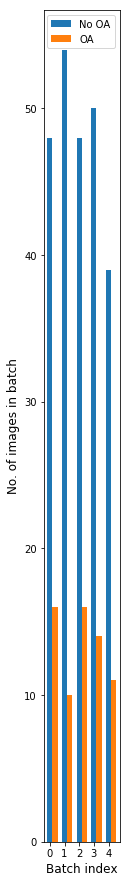

Avg Proportion of No OA per batch: 4.779999999999999
Avg Proportion of OA per batch: 1.3399999999999999
Num. unique images seen: 306/306


In [13]:
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train = DataLoader(train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# visualize training data imbalance
_, _, _ = visualise_dataloader(loader_train, {0: "No OA", 1: "OA"})

/opt/conda/envs/posedemo/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


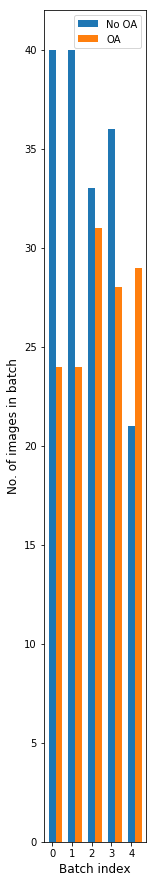

Avg Proportion of No OA per batch: 3.4
Avg Proportion of OA per batch: 2.7199999999999998
Num. unique images seen: 306/306


In [14]:
train = CustomDataset(dataframe=train_data, transform=transform)
class_weights = 1./torch.tensor(class_counts, dtype=torch.float) 
labels = train_data.iloc[:,-1]
class_weights_all = class_weights[labels]

# oversample the training data 
weighted_sampler = sampler.WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)
loader_train_os = DataLoader(train, batch_size=64, sampler=weighted_sampler)

_, _, _ = visualise_dataloader(loader_train_os, {0: "No OA", 1: "OA"})

### BareBones Model

#### Train model with normalized inputs, no oversampling

In [15]:
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

input_size = 77061
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=20)

/opt/conda/envs/posedemo/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, loss = nan, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 1, loss = nan, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 2, loss = nan, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 3, loss = nan, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 4, loss = nan, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 5, loss = nan, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 6, loss = nan, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 7, loss = nan, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 8, loss = nan, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 9, loss = nan, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000


KeyboardInterrupt: 

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with normalized inputs on oversampled training set

In [ ]:
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train_os = DataLoader(train, batch_size=64, sampler=weighted_sampler)

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

input_size = 77061
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train_os, loader_val, epochs=50)

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with normalized inputs, alternative oversampling 

In [ ]:
# oversample the train/val data by increasing number of OA=1 and increasing overall dataset size
#train_val_data = pd.concat([train_data, val_data], axis=0)
index_0 = train_data.index[train_data['OA_check'] == 0.0].tolist()
class_0 = train_data.loc[index_0]
index_1 = train_data.index[train_data['OA_check'] == 1.0].tolist()
class_1 = train_data.loc[index_1]
class_count_0 = len(class_0)
class_1_over = class_1.sample(class_count_0, replace=True)
train_over = pd.concat([class_1_over, class_0], axis=0)
# shuffle the DataFrame rows
train_over = train_over.sample(frac = 1)

NUM_TRAIN_OS = len(train_over)

train = CustomDataset(dataframe=train_over, transform=transform)
loader_train_os2 = DataLoader(train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN_OS)))

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

input_size = 77061
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train_os2, loader_val, epochs=50)

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with unnormalized inputs, no oversampling

In [ ]:
train = CustomDataset(dataframe=train_data)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data)
loader_test = DataLoader(test, batch_size=64)

In [ ]:
input_size = 77061
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=50)

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with unnormalized inputs, no oversampling, weighted loss

Epoch 0, loss = 2.0784, train_acc = 74.1830, val_acc = 84.6154, train_pos = 15.6863, val_pos = 5.1282
Epoch 1, loss = 1.0204, train_acc = 73.2026, val_acc = 51.2821, train_pos = 29.7386, val_pos = 64.1026
Epoch 2, loss = 0.8485, train_acc = 72.5490, val_acc = 89.7436, train_pos = 34.9673, val_pos = 10.2564
Epoch 3, loss = 0.9438, train_acc = 81.0458, val_acc = 87.1795, train_pos = 8.1699, val_pos = 7.6923
Epoch 4, loss = 0.9325, train_acc = 78.7582, val_acc = 84.6154, train_pos = 14.3791, val_pos = 25.6410
Epoch 5, loss = 0.7466, train_acc = 73.8562, val_acc = 84.6154, train_pos = 34.3137, val_pos = 20.5128
Epoch 6, loss = 1.2247, train_acc = 80.7190, val_acc = 89.7436, train_pos = 13.7255, val_pos = 10.2564
Epoch 7, loss = 0.9010, train_acc = 81.0458, val_acc = 84.6154, train_pos = 16.0131, val_pos = 20.5128
Epoch 8, loss = 0.8554, train_acc = 80.3922, val_acc = 82.0513, train_pos = 29.0850, val_pos = 17.9487
Epoch 9, loss = 0.9635, train_acc = 80.3922, val_acc = 89.7436, train_pos = 

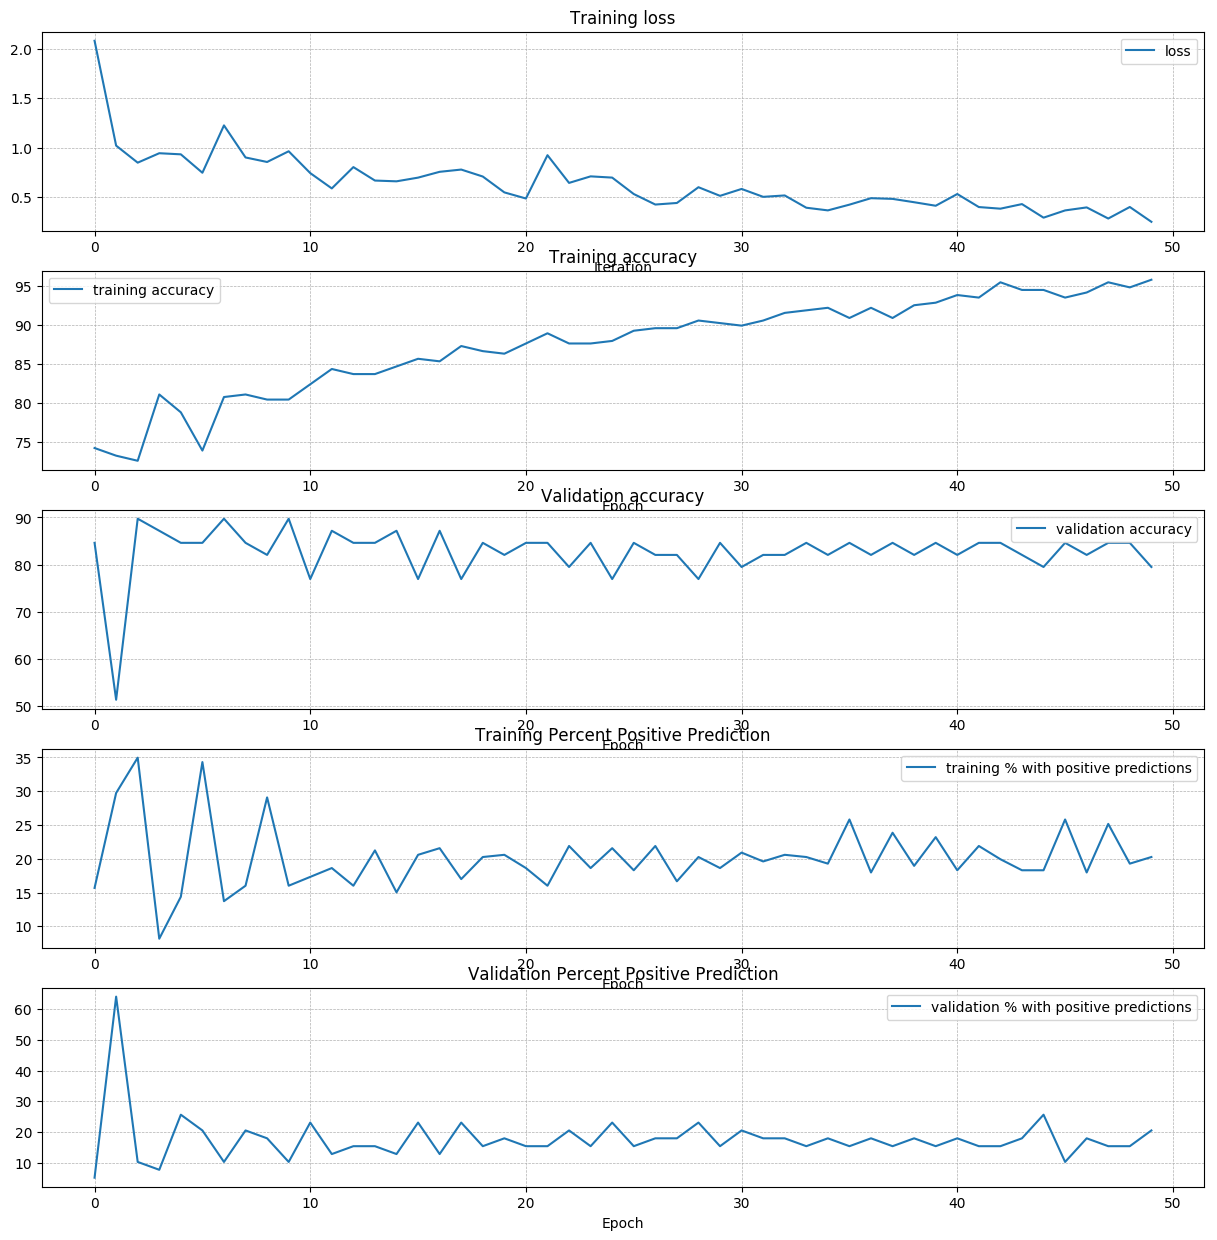

Finished running for lr: 1e-06, hidden size: 100, epochs: 50
Epoch 0, loss = 1.1014, train_acc = 67.3203, val_acc = 41.0256, train_pos = 25.1634, val_pos = 74.3590
Epoch 1, loss = 0.9789, train_acc = 63.7255, val_acc = 79.4872, train_pos = 45.7516, val_pos = 15.3846
Epoch 2, loss = 0.8824, train_acc = 79.7386, val_acc = 84.6154, train_pos = 12.0915, val_pos = 10.2564
Epoch 3, loss = 0.9355, train_acc = 79.7386, val_acc = 82.0513, train_pos = 14.0523, val_pos = 17.9487
Epoch 4, loss = 0.8975, train_acc = 75.4902, val_acc = 87.1795, train_pos = 28.1046, val_pos = 28.2051
Epoch 5, loss = 1.0052, train_acc = 76.7974, val_acc = 84.6154, train_pos = 25.4902, val_pos = 15.3846
Epoch 6, loss = 0.7849, train_acc = 79.4118, val_acc = 84.6154, train_pos = 15.0327, val_pos = 15.3846
Epoch 7, loss = 0.9907, train_acc = 79.0850, val_acc = 84.6154, train_pos = 14.0523, val_pos = 15.3846
Epoch 8, loss = 0.9724, train_acc = 78.4314, val_acc = 84.6154, train_pos = 21.2418, val_pos = 20.5128
Epoch 9, los

Epoch 80, loss = 0.3295, train_acc = 98.6928, val_acc = 82.0513, train_pos = 23.2026, val_pos = 17.9487
Epoch 81, loss = 0.3354, train_acc = 98.0392, val_acc = 84.6154, train_pos = 21.2418, val_pos = 10.2564
Epoch 82, loss = 0.1700, train_acc = 99.3464, val_acc = 76.9231, train_pos = 22.5490, val_pos = 23.0769
Epoch 83, loss = 0.2201, train_acc = 99.3464, val_acc = 84.6154, train_pos = 22.5490, val_pos = 10.2564
Epoch 84, loss = 0.2103, train_acc = 99.0196, val_acc = 82.0513, train_pos = 20.9150, val_pos = 17.9487
Epoch 85, loss = 0.2131, train_acc = 99.0196, val_acc = 84.6154, train_pos = 22.8758, val_pos = 10.2564
Epoch 86, loss = 0.1736, train_acc = 99.6732, val_acc = 84.6154, train_pos = 22.2222, val_pos = 10.2564
Epoch 87, loss = 0.2579, train_acc = 99.6732, val_acc = 82.0513, train_pos = 22.2222, val_pos = 17.9487
Epoch 88, loss = 0.2120, train_acc = 99.6732, val_acc = 84.6154, train_pos = 22.2222, val_pos = 10.2564
Epoch 89, loss = 0.1974, train_acc = 99.3464, val_acc = 82.0513,

Epoch 158, loss = 0.0854, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 7.6923
Epoch 159, loss = 0.0635, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 160, loss = 0.0456, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 161, loss = 0.0365, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 162, loss = 0.0686, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 163, loss = 0.0682, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 164, loss = 0.0585, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 165, loss = 0.0690, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 166, loss = 0.0604, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 7.6923
Epoch 167, loss = 0.0592, train_acc = 100.0000, 

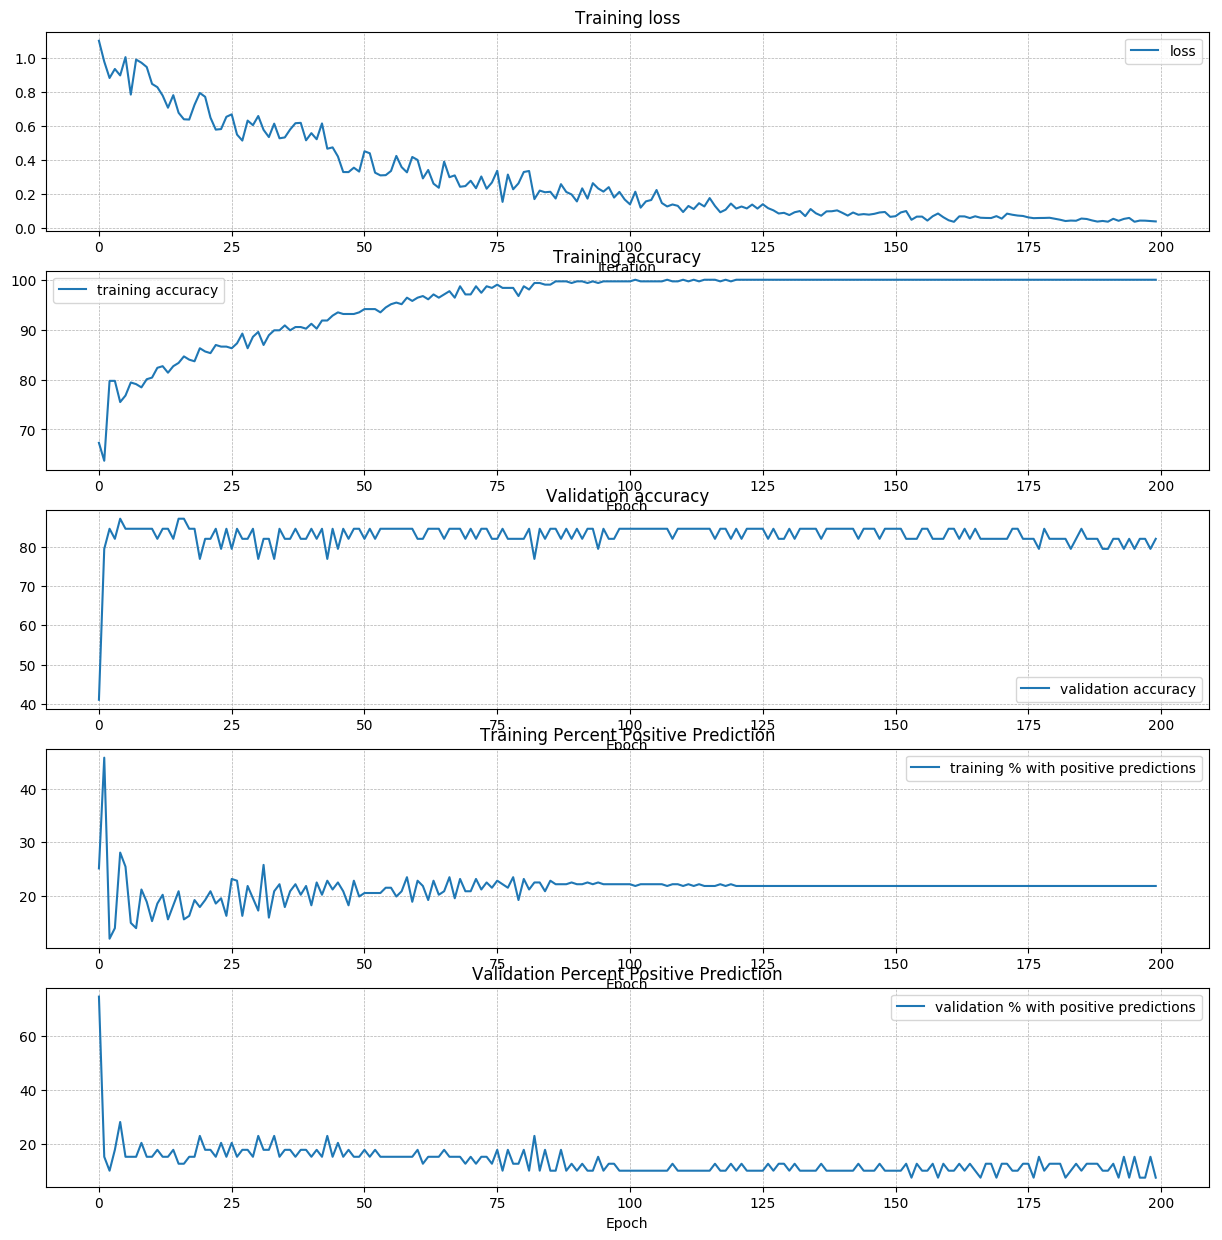

Finished running for lr: 1e-06, hidden size: 100, epochs: 200
Epoch 0, loss = 1.0250, train_acc = 78.7582, val_acc = 79.4872, train_pos = 10.4575, val_pos = 25.6410
Epoch 1, loss = 0.8691, train_acc = 76.1438, val_acc = 84.6154, train_pos = 23.5294, val_pos = 10.2564
Epoch 2, loss = 1.0426, train_acc = 79.7386, val_acc = 79.4872, train_pos = 13.3987, val_pos = 15.3846
Epoch 3, loss = 0.9424, train_acc = 75.8170, val_acc = 82.0513, train_pos = 21.8954, val_pos = 28.2051
Epoch 4, loss = 0.8149, train_acc = 78.4314, val_acc = 84.6154, train_pos = 24.5098, val_pos = 15.3846
Epoch 5, loss = 0.8940, train_acc = 79.7386, val_acc = 84.6154, train_pos = 14.7059, val_pos = 15.3846
Epoch 6, loss = 0.8536, train_acc = 78.7582, val_acc = 82.0513, train_pos = 20.2614, val_pos = 17.9487
Epoch 7, loss = 0.9031, train_acc = 80.7190, val_acc = 89.7436, train_pos = 14.3791, val_pos = 10.2564
Epoch 8, loss = 0.6090, train_acc = 82.3529, val_acc = 82.0513, train_pos = 13.3987, val_pos = 17.9487
Epoch 9, lo

Epoch 79, loss = 0.1452, train_acc = 99.6732, val_acc = 82.0513, train_pos = 22.2222, val_pos = 17.9487
Epoch 80, loss = 0.1387, train_acc = 99.6732, val_acc = 76.9231, train_pos = 22.2222, val_pos = 12.8205
Epoch 81, loss = 0.1601, train_acc = 99.6732, val_acc = 76.9231, train_pos = 22.2222, val_pos = 12.8205
Epoch 82, loss = 0.1328, train_acc = 99.6732, val_acc = 82.0513, train_pos = 22.2222, val_pos = 17.9487
Epoch 83, loss = 0.1443, train_acc = 99.6732, val_acc = 79.4872, train_pos = 22.2222, val_pos = 10.2564
Epoch 84, loss = 0.1434, train_acc = 99.6732, val_acc = 79.4872, train_pos = 22.2222, val_pos = 15.3846
Epoch 85, loss = 0.1364, train_acc = 99.6732, val_acc = 79.4872, train_pos = 22.2222, val_pos = 15.3846
Epoch 86, loss = 0.1643, train_acc = 99.6732, val_acc = 79.4872, train_pos = 22.2222, val_pos = 15.3846
Epoch 87, loss = 0.1273, train_acc = 99.6732, val_acc = 76.9231, train_pos = 22.2222, val_pos = 12.8205
Epoch 88, loss = 0.1297, train_acc = 99.6732, val_acc = 76.9231,

Epoch 157, loss = 0.0412, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 158, loss = 0.0390, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 159, loss = 0.0512, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 160, loss = 0.0364, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 161, loss = 0.0353, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 162, loss = 0.0507, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 163, loss = 0.0365, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 164, loss = 0.0317, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 165, loss = 0.0414, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 166, loss = 0.0297, train_acc = 100.0000

Epoch 235, loss = 0.0191, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 236, loss = 0.0156, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 237, loss = 0.0183, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 238, loss = 0.0183, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 239, loss = 0.0172, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 240, loss = 0.0136, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 241, loss = 0.0176, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 242, loss = 0.0141, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 243, loss = 0.0149, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 244, loss = 0.0081, train_acc = 100.0000

Epoch 313, loss = 0.0056, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 314, loss = 0.0090, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 315, loss = 0.0076, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 316, loss = 0.0091, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 317, loss = 0.0055, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 318, loss = 0.0068, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 319, loss = 0.0055, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 320, loss = 0.0086, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 321, loss = 0.0080, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 322, loss = 0.0079, train_acc = 100.0000

Epoch 391, loss = 0.0032, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 392, loss = 0.0038, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 393, loss = 0.0054, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 394, loss = 0.0060, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 395, loss = 0.0041, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 396, loss = 0.0052, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 397, loss = 0.0050, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 398, loss = 0.0046, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 399, loss = 0.0032, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 400, loss = 0.0034, train_acc = 100.0000

Epoch 469, loss = 0.0019, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 470, loss = 0.0033, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 471, loss = 0.0031, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 472, loss = 0.0023, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 473, loss = 0.0029, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 474, loss = 0.0046, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 475, loss = 0.0028, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 476, loss = 0.0029, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 477, loss = 0.0033, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 478, loss = 0.0022, train_acc = 100.0000

Epoch 547, loss = 0.0021, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 548, loss = 0.0024, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 549, loss = 0.0030, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 550, loss = 0.0026, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 551, loss = 0.0029, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 552, loss = 0.0016, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 553, loss = 0.0014, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 554, loss = 0.0020, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 555, loss = 0.0021, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 556, loss = 0.0018, train_acc = 100.0000

Epoch 626, loss = 0.0012, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 627, loss = 0.0015, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 628, loss = 0.0013, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 629, loss = 0.0019, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 630, loss = 0.0016, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 631, loss = 0.0018, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 632, loss = 0.0012, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 633, loss = 0.0010, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 634, loss = 0.0013, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 635, loss = 0.0016, train_acc = 100.0000

Epoch 705, loss = 0.0011, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 706, loss = 0.0006, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 707, loss = 0.0012, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 708, loss = 0.0007, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 709, loss = 0.0012, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 710, loss = 0.0009, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 711, loss = 0.0013, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 712, loss = 0.0014, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 713, loss = 0.0012, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 714, loss = 0.0011, train_acc = 100.0000

Epoch 783, loss = 0.0008, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 784, loss = 0.0008, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 785, loss = 0.0007, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 786, loss = 0.0007, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 787, loss = 0.0007, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 788, loss = 0.0010, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 789, loss = 0.0008, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 790, loss = 0.0009, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 791, loss = 0.0005, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 792, loss = 0.0007, train_acc = 100.0000

Epoch 861, loss = 0.0004, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 862, loss = 0.0006, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 863, loss = 0.0006, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 864, loss = 0.0005, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 865, loss = 0.0005, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 866, loss = 0.0004, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 867, loss = 0.0006, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 868, loss = 0.0006, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 869, loss = 0.0005, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 870, loss = 0.0005, train_acc = 100.0000

Epoch 939, loss = 0.0003, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 940, loss = 0.0004, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 941, loss = 0.0003, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 942, loss = 0.0006, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 943, loss = 0.0005, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 944, loss = 0.0004, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 945, loss = 0.0005, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 946, loss = 0.0004, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 947, loss = 0.0003, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 948, loss = 0.0004, train_acc = 100.0000

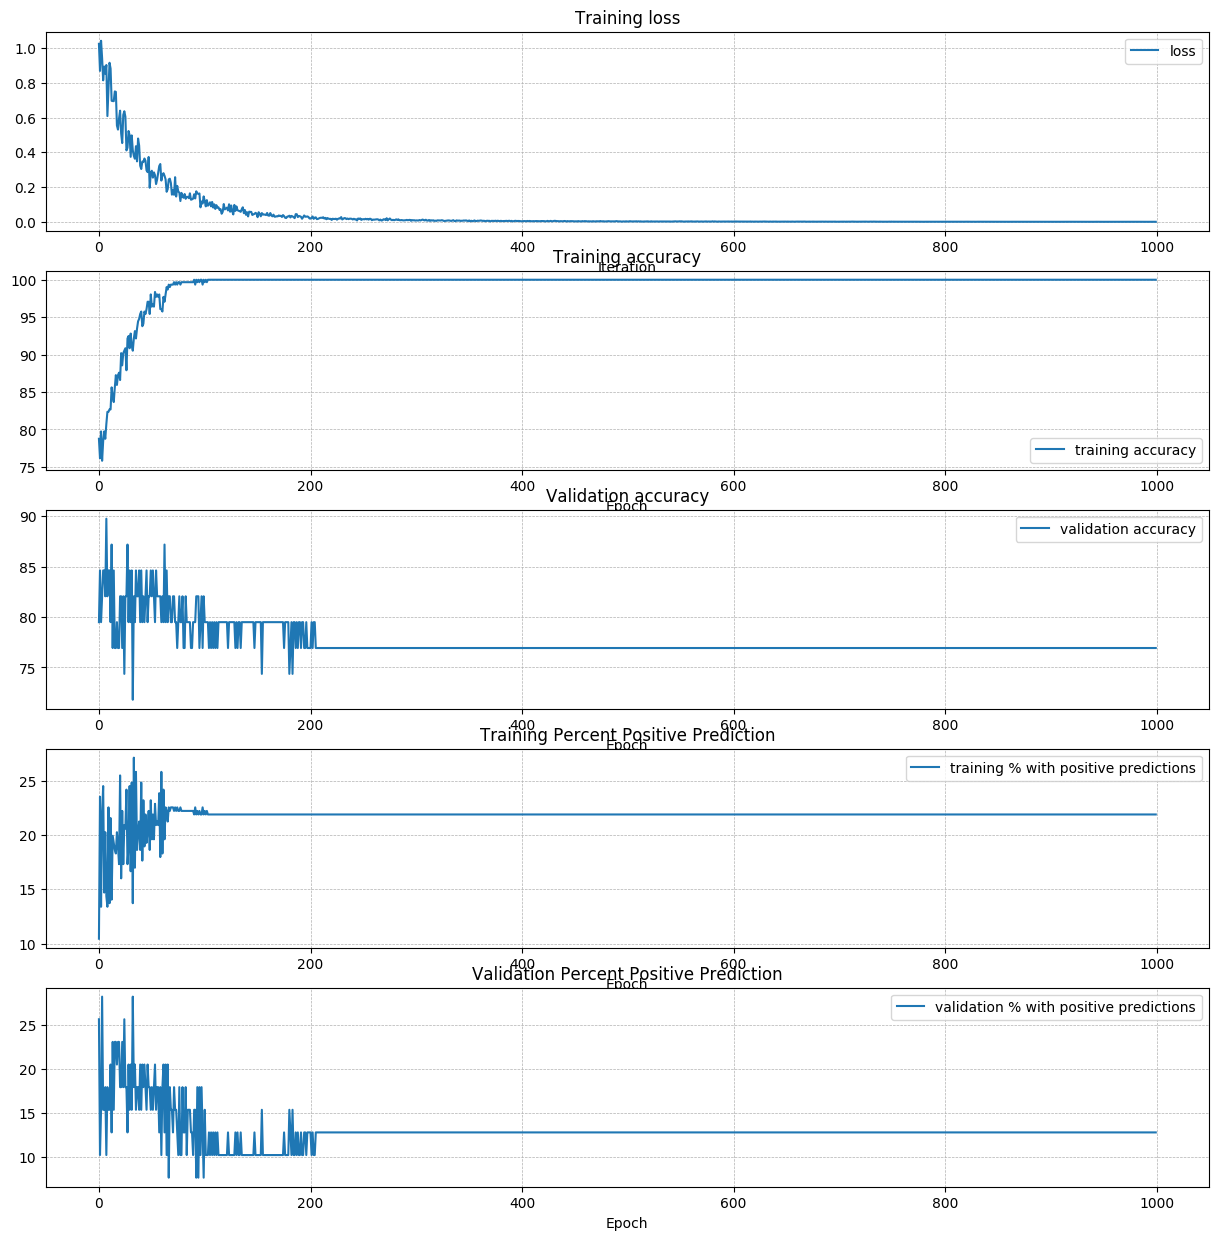

Finished running for lr: 1e-06, hidden size: 100, epochs: 1000
Epoch 0, loss = 1.0643, train_acc = 65.0327, val_acc = 79.4872, train_pos = 27.4510, val_pos = 0.0000
Epoch 1, loss = 0.9773, train_acc = 80.0654, val_acc = 82.0513, train_pos = 10.4575, val_pos = 17.9487
Epoch 2, loss = 1.0156, train_acc = 77.1242, val_acc = 82.0513, train_pos = 20.5882, val_pos = 17.9487
Epoch 3, loss = 0.7815, train_acc = 77.1242, val_acc = 84.6154, train_pos = 19.2810, val_pos = 15.3846
Epoch 4, loss = 0.8286, train_acc = 80.3922, val_acc = 84.6154, train_pos = 13.3987, val_pos = 15.3846
Epoch 5, loss = 0.9504, train_acc = 79.7386, val_acc = 84.6154, train_pos = 20.5882, val_pos = 20.5128
Epoch 6, loss = 0.7542, train_acc = 81.3725, val_acc = 87.1795, train_pos = 18.9542, val_pos = 12.8205
Epoch 7, loss = 0.8449, train_acc = 81.3725, val_acc = 82.0513, train_pos = 13.7255, val_pos = 17.9487
Epoch 8, loss = 0.7190, train_acc = 81.0458, val_acc = 82.0513, train_pos = 23.2026, val_pos = 17.9487
Epoch 9, lo

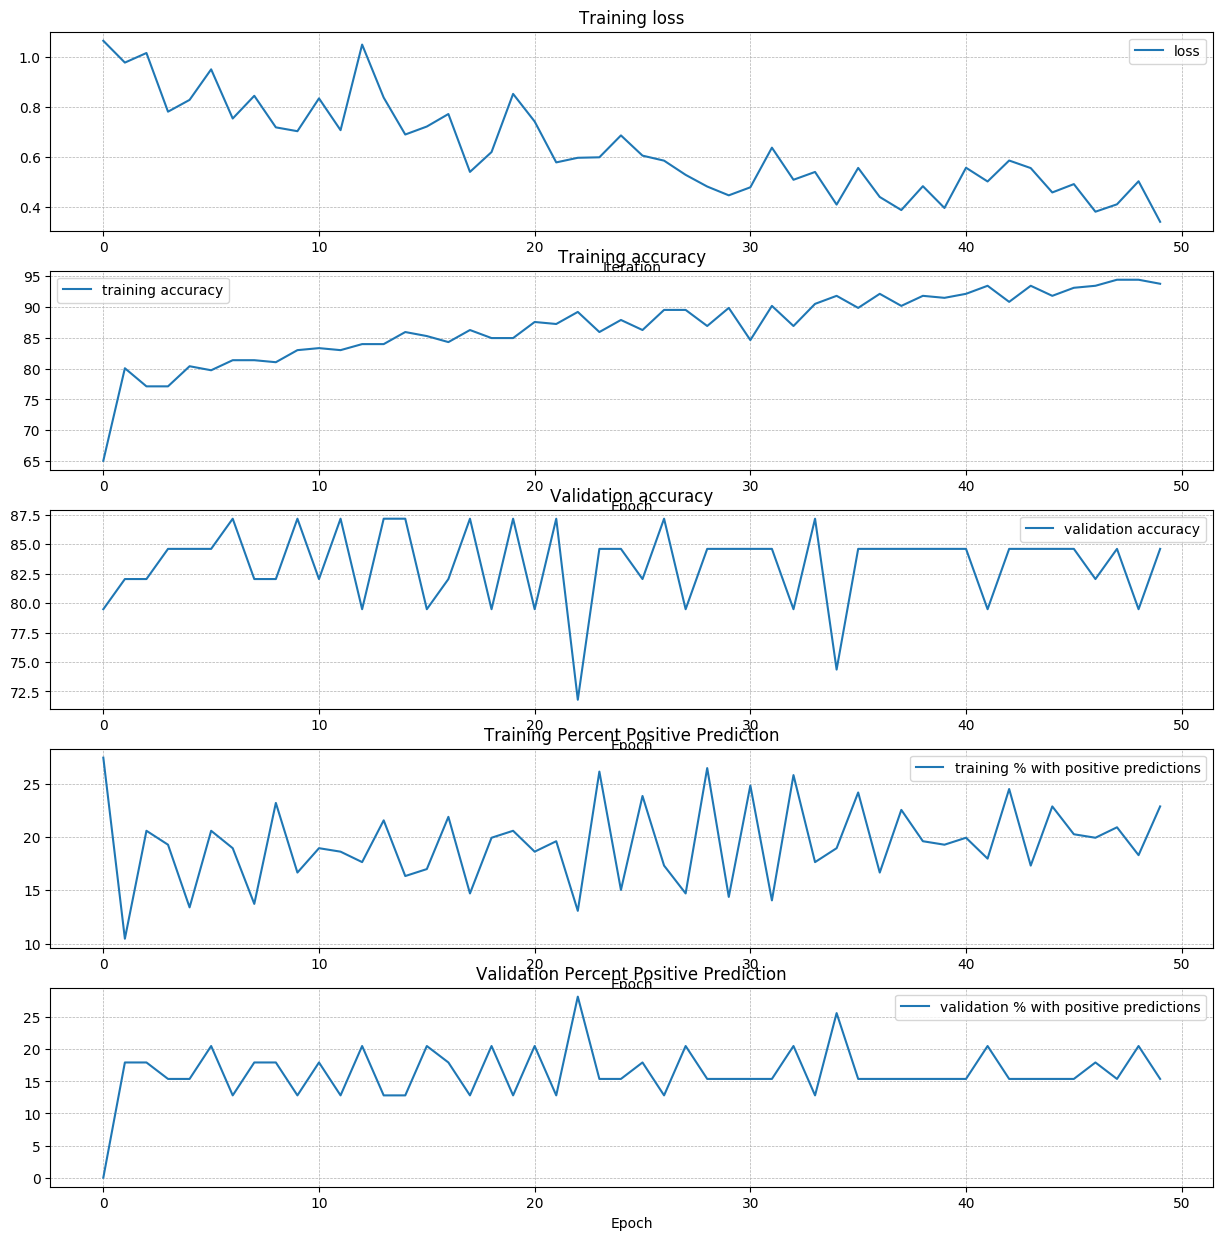

Finished running for lr: 1e-05, hidden size: 100, epochs: 50
Epoch 0, loss = 0.7699, train_acc = 77.1242, val_acc = 79.4872, train_pos = 14.7059, val_pos = 15.3846
Epoch 1, loss = 1.1927, train_acc = 78.4314, val_acc = 84.6154, train_pos = 17.9739, val_pos = 30.7692
Epoch 2, loss = 0.8912, train_acc = 74.8366, val_acc = 89.7436, train_pos = 30.7190, val_pos = 10.2564
Epoch 3, loss = 0.9075, train_acc = 83.0065, val_acc = 76.9231, train_pos = 10.1307, val_pos = 23.0769
Epoch 4, loss = 0.6517, train_acc = 78.1046, val_acc = 87.1795, train_pos = 29.4118, val_pos = 12.8205
Epoch 5, loss = 0.7721, train_acc = 83.9869, val_acc = 69.2308, train_pos = 9.1503, val_pos = 30.7692
Epoch 6, loss = 0.8572, train_acc = 78.4314, val_acc = 87.1795, train_pos = 29.0850, val_pos = 12.8205
Epoch 7, loss = 0.8474, train_acc = 83.3333, val_acc = 79.4872, train_pos = 16.9935, val_pos = 20.5128
Epoch 8, loss = 0.7843, train_acc = 83.0065, val_acc = 84.6154, train_pos = 20.5882, val_pos = 15.3846
Epoch 9, loss

Epoch 79, loss = 0.1255, train_acc = 99.6732, val_acc = 84.6154, train_pos = 22.2222, val_pos = 10.2564
Epoch 80, loss = 0.1897, train_acc = 99.6732, val_acc = 82.0513, train_pos = 22.2222, val_pos = 17.9487
Epoch 81, loss = 0.1709, train_acc = 99.6732, val_acc = 84.6154, train_pos = 22.2222, val_pos = 15.3846
Epoch 82, loss = 0.1847, train_acc = 99.6732, val_acc = 84.6154, train_pos = 22.2222, val_pos = 15.3846
Epoch 83, loss = 0.0994, train_acc = 99.6732, val_acc = 84.6154, train_pos = 22.2222, val_pos = 15.3846
Epoch 84, loss = 0.1454, train_acc = 99.6732, val_acc = 84.6154, train_pos = 22.2222, val_pos = 15.3846
Epoch 85, loss = 0.1939, train_acc = 99.6732, val_acc = 84.6154, train_pos = 22.2222, val_pos = 15.3846
Epoch 86, loss = 0.1582, train_acc = 99.6732, val_acc = 84.6154, train_pos = 22.2222, val_pos = 15.3846
Epoch 87, loss = 0.1523, train_acc = 99.6732, val_acc = 87.1795, train_pos = 22.2222, val_pos = 17.9487
Epoch 88, loss = 0.1396, train_acc = 99.6732, val_acc = 84.6154,

Epoch 157, loss = 0.0596, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 158, loss = 0.0312, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 159, loss = 0.0484, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 160, loss = 0.0456, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 161, loss = 0.0509, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 162, loss = 0.0491, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 163, loss = 0.0435, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 164, loss = 0.0471, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 165, loss = 0.0418, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 166, loss = 0.0387, train_acc = 100.0000

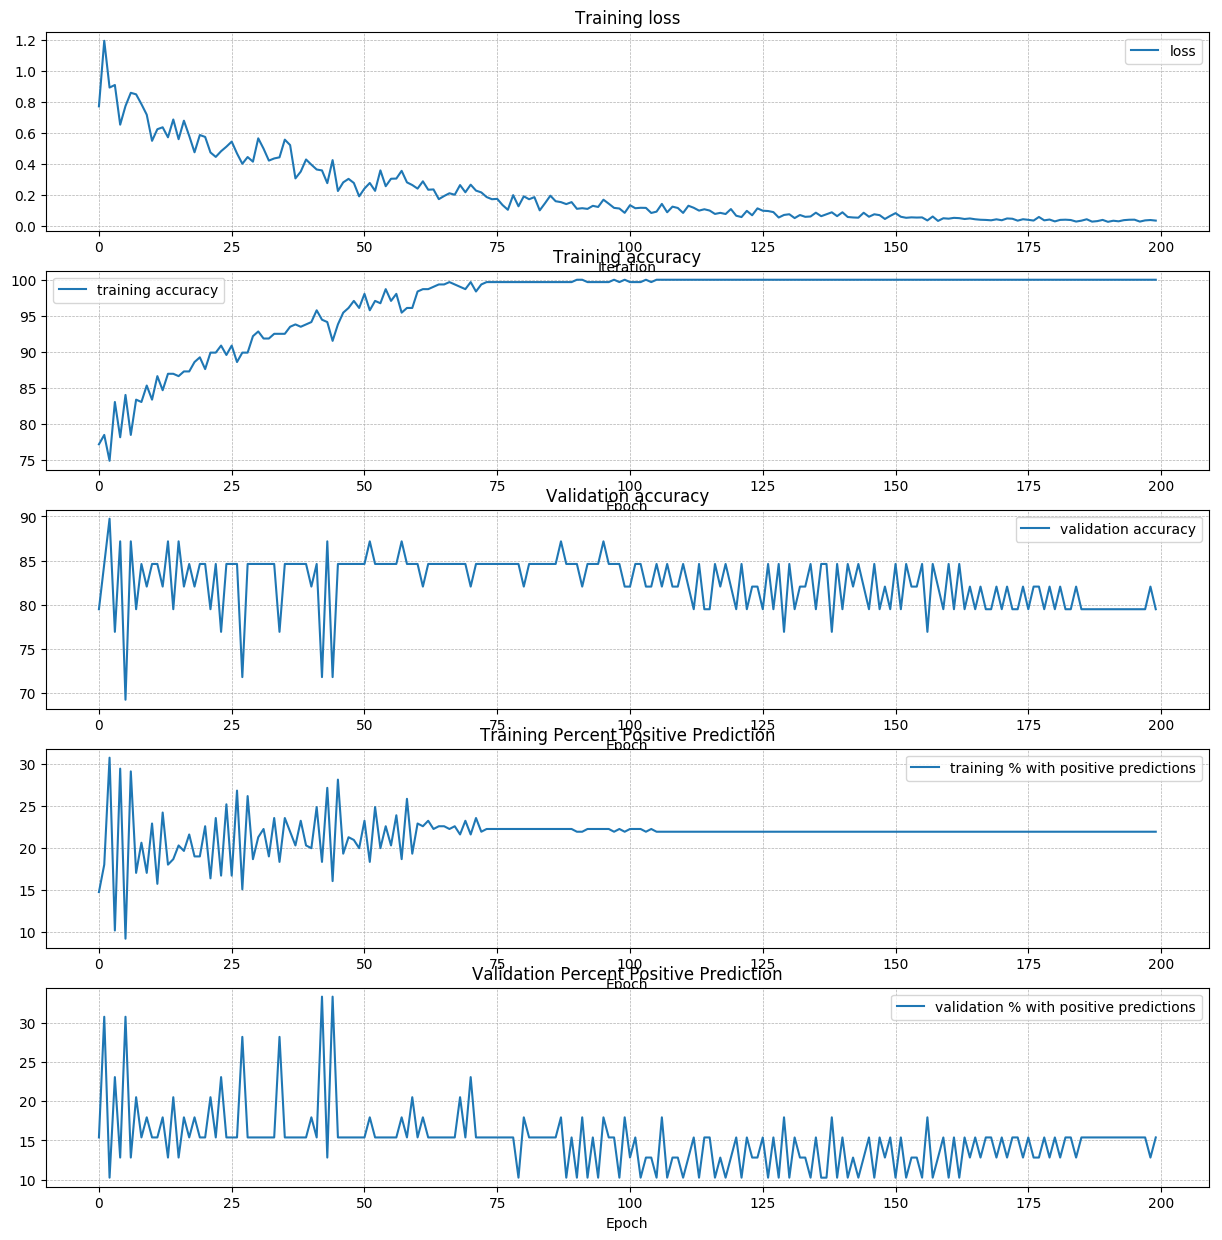

Finished running for lr: 1e-05, hidden size: 100, epochs: 200
Epoch 0, loss = 1.3985, train_acc = 64.3791, val_acc = 84.6154, train_pos = 24.1830, val_pos = 5.1282
Epoch 1, loss = 1.1163, train_acc = 74.1830, val_acc = 79.4872, train_pos = 24.8366, val_pos = 35.8974
Epoch 2, loss = 0.6939, train_acc = 76.7974, val_acc = 84.6154, train_pos = 22.2222, val_pos = 10.2564
Epoch 3, loss = 0.8149, train_acc = 80.3922, val_acc = 84.6154, train_pos = 12.7451, val_pos = 15.3846
Epoch 4, loss = 0.7344, train_acc = 77.4510, val_acc = 84.6154, train_pos = 25.4902, val_pos = 20.5128
Epoch 5, loss = 0.8359, train_acc = 81.3725, val_acc = 89.7436, train_pos = 13.0719, val_pos = 10.2564
Epoch 6, loss = 0.8265, train_acc = 80.0654, val_acc = 79.4872, train_pos = 17.6471, val_pos = 25.6410
Epoch 7, loss = 0.7550, train_acc = 81.0458, val_acc = 87.1795, train_pos = 24.5098, val_pos = 12.8205
Epoch 8, loss = 0.8698, train_acc = 82.6797, val_acc = 84.6154, train_pos = 14.3791, val_pos = 15.3846
Epoch 9, los

Epoch 80, loss = 0.2435, train_acc = 98.3660, val_acc = 84.6154, train_pos = 21.5686, val_pos = 20.5128
Epoch 81, loss = 0.2661, train_acc = 99.3464, val_acc = 84.6154, train_pos = 22.5490, val_pos = 15.3846
Epoch 82, loss = 0.1951, train_acc = 99.3464, val_acc = 87.1795, train_pos = 22.5490, val_pos = 17.9487
Epoch 83, loss = 0.2321, train_acc = 99.3464, val_acc = 87.1795, train_pos = 22.5490, val_pos = 17.9487
Epoch 84, loss = 0.2371, train_acc = 99.3464, val_acc = 84.6154, train_pos = 22.5490, val_pos = 20.5128
Epoch 85, loss = 0.2568, train_acc = 99.3464, val_acc = 84.6154, train_pos = 22.5490, val_pos = 15.3846
Epoch 86, loss = 0.2139, train_acc = 99.3464, val_acc = 87.1795, train_pos = 22.5490, val_pos = 17.9487
Epoch 87, loss = 0.2004, train_acc = 99.3464, val_acc = 84.6154, train_pos = 22.5490, val_pos = 15.3846
Epoch 88, loss = 0.2164, train_acc = 99.6732, val_acc = 82.0513, train_pos = 22.2222, val_pos = 17.9487
Epoch 89, loss = 0.1783, train_acc = 99.6732, val_acc = 82.0513,

Epoch 159, loss = 0.0745, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 15.3846
Epoch 160, loss = 0.0633, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 23.0769
Epoch 161, loss = 0.0567, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 17.9487
Epoch 162, loss = 0.0692, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 17.9487
Epoch 163, loss = 0.0617, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 164, loss = 0.0949, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 17.9487
Epoch 165, loss = 0.0782, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 23.0769
Epoch 166, loss = 0.0453, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 17.9487
Epoch 167, loss = 0.0622, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 23.0769
Epoch 168, loss = 0.0784, train_acc = 100.0000

Epoch 237, loss = 0.0455, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 238, loss = 0.0294, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 239, loss = 0.0370, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 240, loss = 0.0473, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 17.9487
Epoch 241, loss = 0.0360, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 242, loss = 0.0149, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 243, loss = 0.0283, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 244, loss = 0.0362, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 245, loss = 0.0306, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 246, loss = 0.0327, train_acc = 100.0000

Epoch 315, loss = 0.0186, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 316, loss = 0.0152, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 317, loss = 0.0186, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 318, loss = 0.0148, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 319, loss = 0.0159, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 320, loss = 0.0154, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 321, loss = 0.0182, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 322, loss = 0.0145, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 323, loss = 0.0158, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 324, loss = 0.0132, train_acc = 100.0000

Epoch 393, loss = 0.0071, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 394, loss = 0.0049, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 395, loss = 0.0104, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 396, loss = 0.0079, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 397, loss = 0.0051, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 398, loss = 0.0088, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 399, loss = 0.0103, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 400, loss = 0.0113, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 401, loss = 0.0112, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 402, loss = 0.0092, train_acc = 100.0000

Epoch 471, loss = 0.0064, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 472, loss = 0.0056, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 473, loss = 0.0047, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 474, loss = 0.0048, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 475, loss = 0.0045, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 476, loss = 0.0054, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 477, loss = 0.0044, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 478, loss = 0.0063, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 479, loss = 0.0058, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 480, loss = 0.0062, train_acc = 100.0000

Epoch 549, loss = 0.0052, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 550, loss = 0.0058, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 551, loss = 0.0025, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 552, loss = 0.0035, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 553, loss = 0.0032, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 554, loss = 0.0037, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 555, loss = 0.0037, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 556, loss = 0.0035, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 557, loss = 0.0034, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 558, loss = 0.0053, train_acc = 100.0000

Epoch 628, loss = 0.0024, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 629, loss = 0.0022, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 630, loss = 0.0024, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 631, loss = 0.0026, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 632, loss = 0.0024, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 633, loss = 0.0021, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 634, loss = 0.0035, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 635, loss = 0.0026, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 636, loss = 0.0024, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 637, loss = 0.0026, train_acc = 100.0000

Epoch 706, loss = 0.0019, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 707, loss = 0.0020, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 708, loss = 0.0016, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 709, loss = 0.0016, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 710, loss = 0.0017, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 711, loss = 0.0021, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 712, loss = 0.0023, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 713, loss = 0.0022, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 714, loss = 0.0016, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 715, loss = 0.0014, train_acc = 100.0000

Epoch 784, loss = 0.0016, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 785, loss = 0.0019, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 786, loss = 0.0013, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 787, loss = 0.0009, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 788, loss = 0.0013, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 789, loss = 0.0013, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 790, loss = 0.0016, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 791, loss = 0.0013, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 792, loss = 0.0018, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 793, loss = 0.0011, train_acc = 100.0000

Epoch 862, loss = 0.0011, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 863, loss = 0.0008, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 864, loss = 0.0010, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 865, loss = 0.0011, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 866, loss = 0.0009, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 867, loss = 0.0010, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 868, loss = 0.0010, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 869, loss = 0.0010, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 870, loss = 0.0010, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 871, loss = 0.0011, train_acc = 100.0000

Epoch 940, loss = 0.0007, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 941, loss = 0.0007, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 942, loss = 0.0005, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 943, loss = 0.0007, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 944, loss = 0.0008, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 945, loss = 0.0006, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 946, loss = 0.0005, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 947, loss = 0.0009, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 948, loss = 0.0008, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 949, loss = 0.0008, train_acc = 100.0000

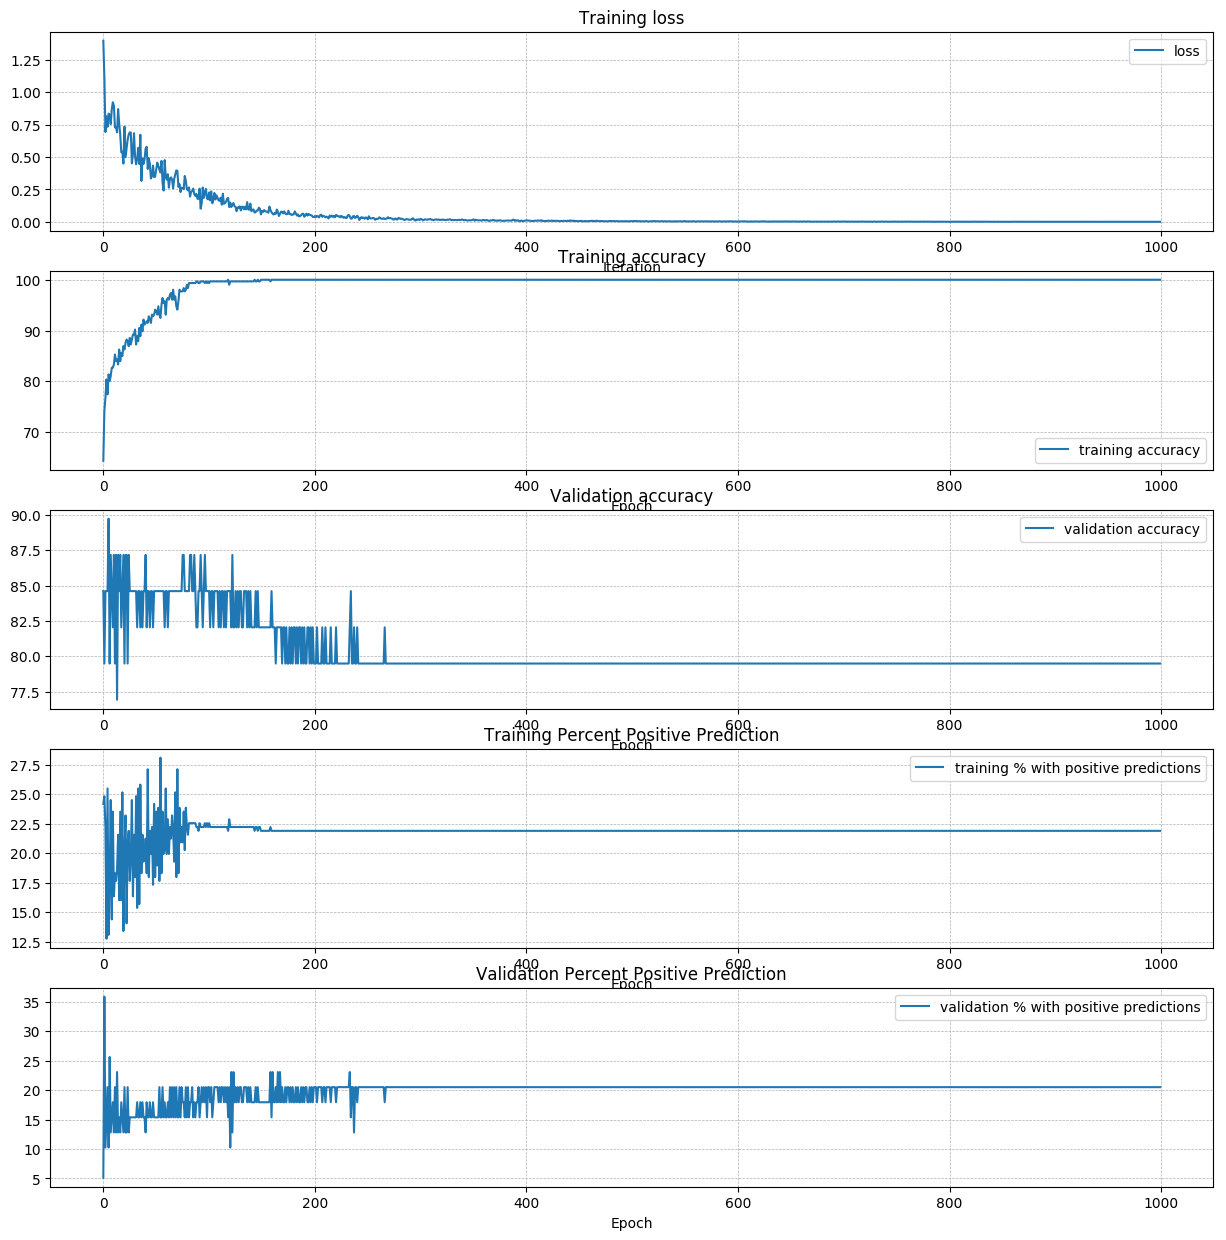

Finished running for lr: 1e-05, hidden size: 100, epochs: 1000
Epoch 0, loss = 1.1444, train_acc = 70.5882, val_acc = 84.6154, train_pos = 21.2418, val_pos = 5.1282
Epoch 1, loss = 1.0868, train_acc = 77.7778, val_acc = 82.0513, train_pos = 18.6275, val_pos = 17.9487
Epoch 2, loss = 0.7788, train_acc = 77.4510, val_acc = 87.1795, train_pos = 20.2614, val_pos = 12.8205
Epoch 3, loss = 0.8251, train_acc = 79.4118, val_acc = 82.0513, train_pos = 15.0327, val_pos = 17.9487
Epoch 4, loss = 0.8615, train_acc = 80.7190, val_acc = 87.1795, train_pos = 18.3007, val_pos = 12.8205
Epoch 5, loss = 0.7554, train_acc = 81.3725, val_acc = 87.1795, train_pos = 15.6863, val_pos = 12.8205
Epoch 6, loss = 0.7961, train_acc = 83.0065, val_acc = 84.6154, train_pos = 15.3595, val_pos = 15.3846
Epoch 7, loss = 0.6731, train_acc = 80.7190, val_acc = 84.6154, train_pos = 24.8366, val_pos = 15.3846
Epoch 8, loss = 0.7756, train_acc = 83.0065, val_acc = 87.1795, train_pos = 14.7059, val_pos = 12.8205
Epoch 9, lo

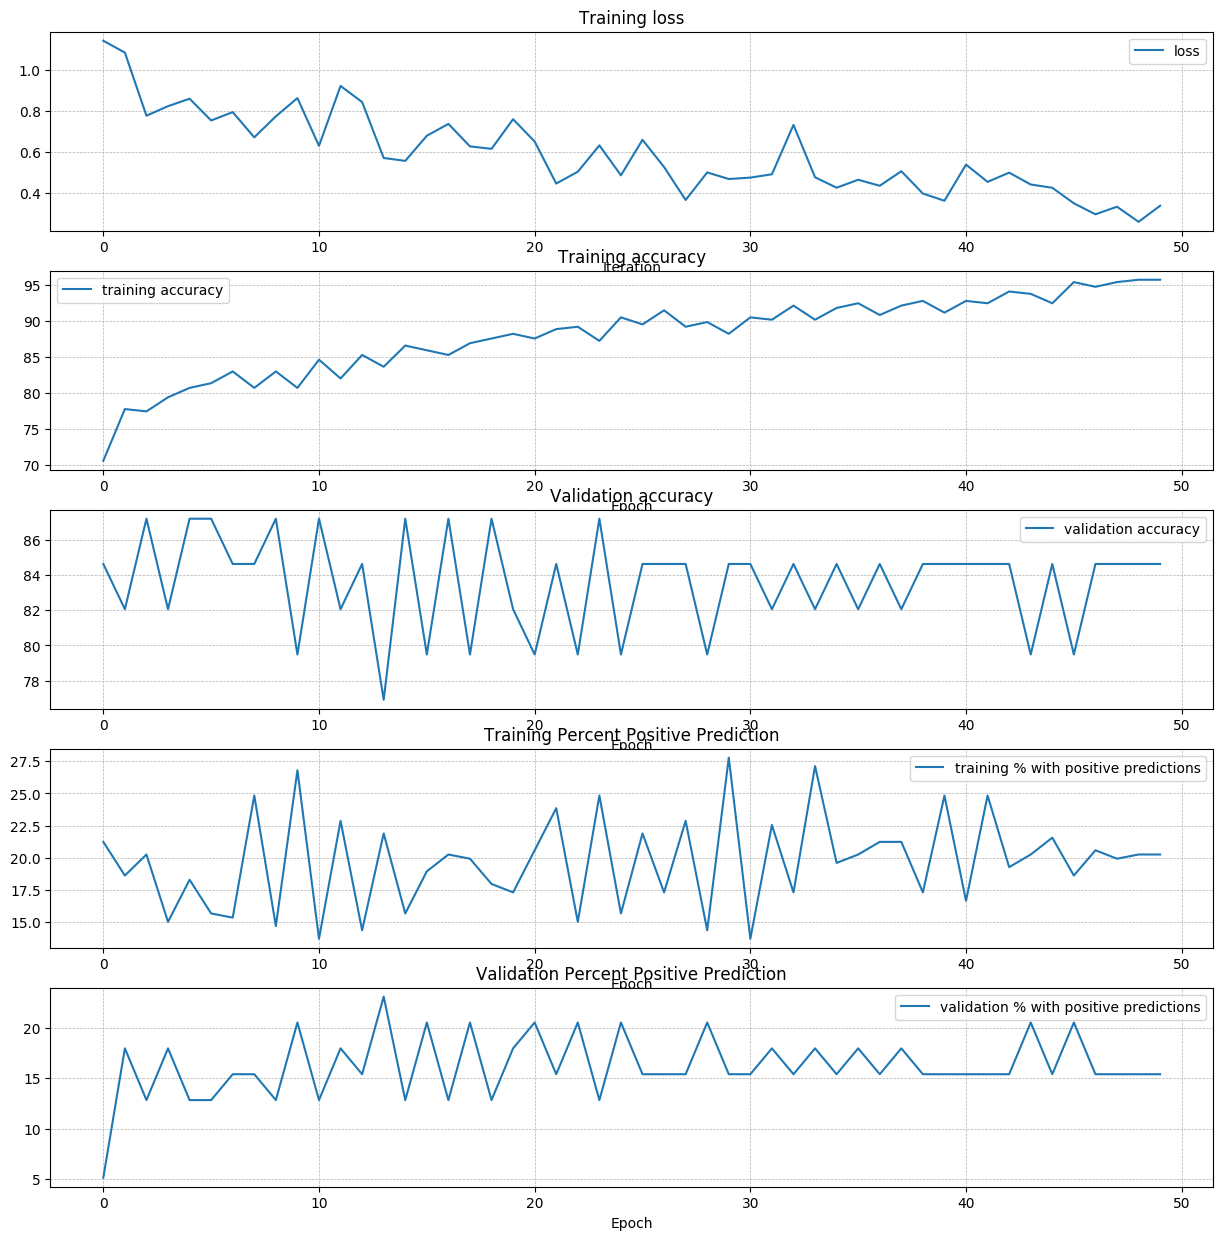

Finished running for lr: 0.0001, hidden size: 100, epochs: 50
Epoch 0, loss = 1.1312, train_acc = 77.4510, val_acc = 71.7949, train_pos = 14.3791, val_pos = 38.4615
Epoch 1, loss = 1.2095, train_acc = 73.5294, val_acc = 82.0513, train_pos = 22.8758, val_pos = 17.9487
Epoch 2, loss = 0.8102, train_acc = 72.8758, val_acc = 87.1795, train_pos = 33.3333, val_pos = 23.0769
Epoch 3, loss = 0.8009, train_acc = 78.4314, val_acc = 89.7436, train_pos = 16.0131, val_pos = 10.2564
Epoch 4, loss = 0.7286, train_acc = 79.4118, val_acc = 76.9231, train_pos = 18.9542, val_pos = 28.2051
Epoch 5, loss = 0.6864, train_acc = 80.3922, val_acc = 89.7436, train_pos = 22.5490, val_pos = 10.2564
Epoch 6, loss = 0.9593, train_acc = 80.7190, val_acc = 84.6154, train_pos = 15.0327, val_pos = 20.5128
Epoch 7, loss = 0.9640, train_acc = 81.3725, val_acc = 84.6154, train_pos = 24.8366, val_pos = 15.3846
Epoch 8, loss = 0.8630, train_acc = 82.6797, val_acc = 84.6154, train_pos = 16.3399, val_pos = 15.3846
Epoch 9, lo

Epoch 79, loss = 0.1392, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 80, loss = 0.1500, train_acc = 99.6732, val_acc = 84.6154, train_pos = 22.2222, val_pos = 10.2564
Epoch 81, loss = 0.1370, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 82, loss = 0.2104, train_acc = 99.6732, val_acc = 84.6154, train_pos = 22.2222, val_pos = 10.2564
Epoch 83, loss = 0.1181, train_acc = 99.6732, val_acc = 84.6154, train_pos = 22.2222, val_pos = 10.2564
Epoch 84, loss = 0.1078, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 85, loss = 0.1412, train_acc = 99.6732, val_acc = 84.6154, train_pos = 22.2222, val_pos = 10.2564
Epoch 86, loss = 0.1166, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 87, loss = 0.1316, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 17.9487
Epoch 88, loss = 0.1331, train_acc = 100.0000, val_acc = 84

Epoch 157, loss = 0.0368, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 158, loss = 0.0302, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 159, loss = 0.0349, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 160, loss = 0.0343, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 161, loss = 0.0291, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 162, loss = 0.0264, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 163, loss = 0.0372, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 164, loss = 0.0203, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 165, loss = 0.0352, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 166, loss = 0.0355, train_acc = 100.0000

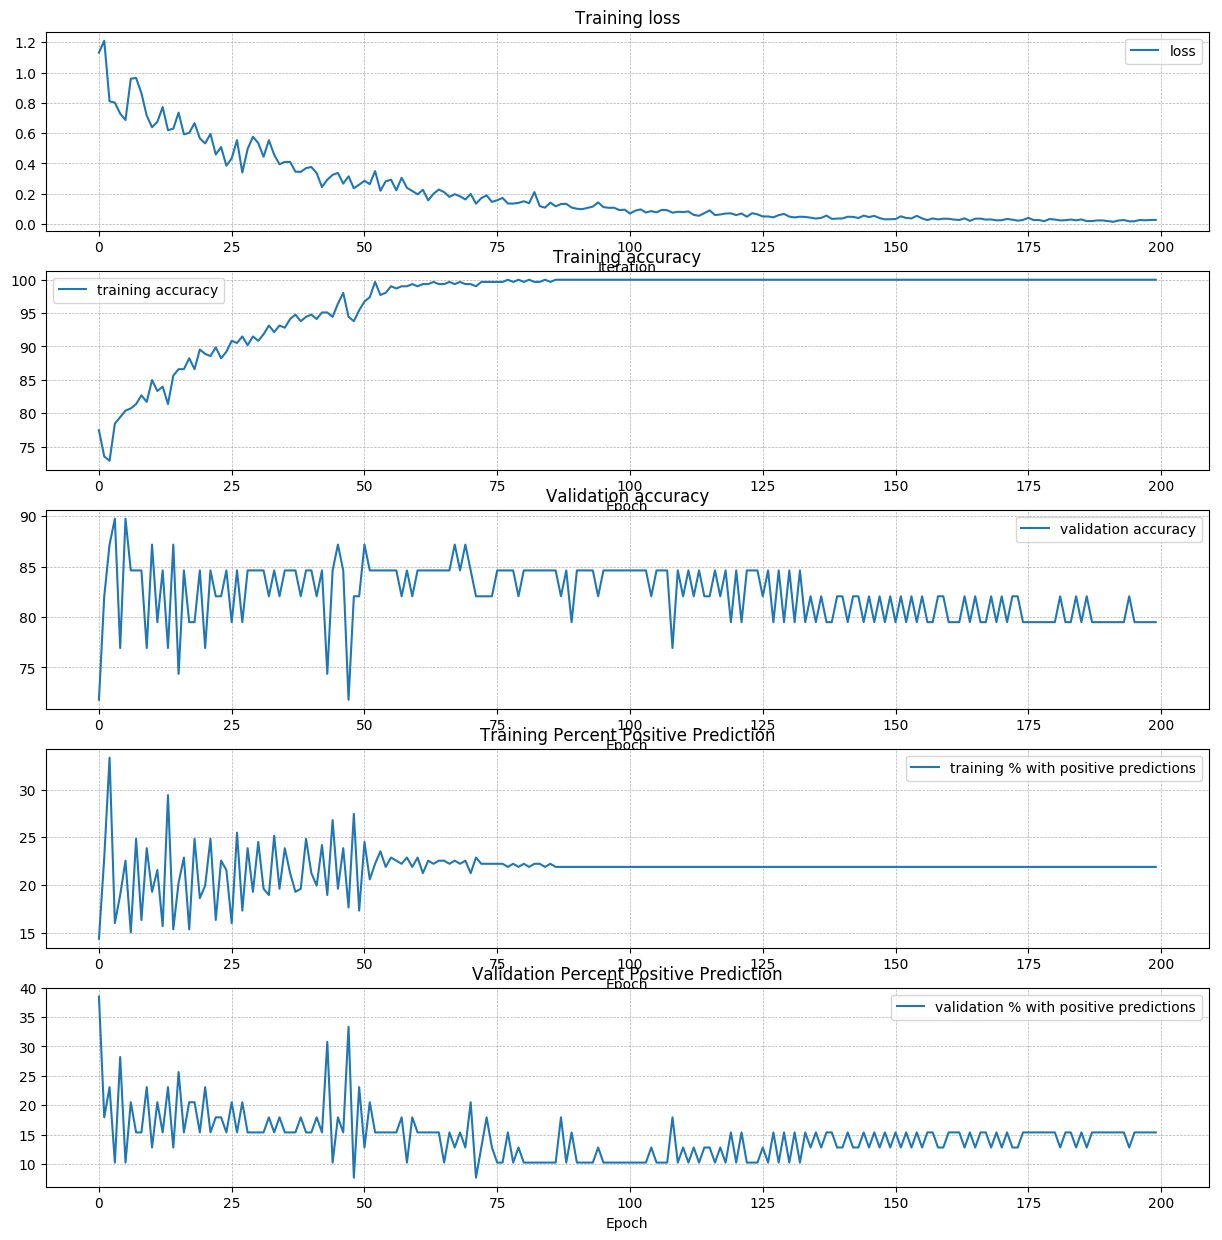

Finished running for lr: 0.0001, hidden size: 100, epochs: 200
Epoch 0, loss = 1.0364, train_acc = 72.8758, val_acc = 64.1026, train_pos = 15.0327, val_pos = 46.1538
Epoch 1, loss = 0.8607, train_acc = 70.9150, val_acc = 82.0513, train_pos = 28.1046, val_pos = 12.8205
Epoch 2, loss = 1.0548, train_acc = 79.0850, val_acc = 84.6154, train_pos = 14.7059, val_pos = 15.3846
Epoch 3, loss = 0.8449, train_acc = 76.7974, val_acc = 84.6154, train_pos = 18.9542, val_pos = 20.5128
Epoch 4, loss = 1.0678, train_acc = 76.7974, val_acc = 84.6154, train_pos = 20.9150, val_pos = 15.3846
Epoch 5, loss = 0.7364, train_acc = 79.7386, val_acc = 82.0513, train_pos = 17.3203, val_pos = 17.9487
Epoch 6, loss = 0.9345, train_acc = 79.4118, val_acc = 84.6154, train_pos = 16.3399, val_pos = 15.3846
Epoch 7, loss = 0.9488, train_acc = 79.4118, val_acc = 84.6154, train_pos = 15.6863, val_pos = 15.3846
Epoch 8, loss = 0.8659, train_acc = 80.7190, val_acc = 82.0513, train_pos = 16.9935, val_pos = 17.9487
Epoch 9, l

Epoch 79, loss = 0.2221, train_acc = 99.6732, val_acc = 79.4872, train_pos = 22.2222, val_pos = 15.3846
Epoch 80, loss = 0.1589, train_acc = 99.6732, val_acc = 84.6154, train_pos = 22.2222, val_pos = 10.2564
Epoch 81, loss = 0.2131, train_acc = 99.6732, val_acc = 82.0513, train_pos = 22.2222, val_pos = 12.8205
Epoch 82, loss = 0.2126, train_acc = 99.3464, val_acc = 84.6154, train_pos = 22.5490, val_pos = 10.2564
Epoch 83, loss = 0.1434, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 84, loss = 0.1664, train_acc = 99.6732, val_acc = 82.0513, train_pos = 22.2222, val_pos = 12.8205
Epoch 85, loss = 0.1393, train_acc = 99.6732, val_acc = 82.0513, train_pos = 22.2222, val_pos = 12.8205
Epoch 86, loss = 0.1881, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 87, loss = 0.1243, train_acc = 99.3464, val_acc = 84.6154, train_pos = 22.5490, val_pos = 10.2564
Epoch 88, loss = 0.1533, train_acc = 99.6732, val_acc = 82.051

Epoch 157, loss = 0.0381, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 158, loss = 0.0275, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 159, loss = 0.0341, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 160, loss = 0.0381, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 161, loss = 0.0289, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 162, loss = 0.0328, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 163, loss = 0.0356, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 164, loss = 0.0445, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 165, loss = 0.0303, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 166, loss = 0.0369, train_acc = 100.0000

Epoch 235, loss = 0.0184, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 236, loss = 0.0130, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 237, loss = 0.0192, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 238, loss = 0.0181, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 239, loss = 0.0212, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 240, loss = 0.0145, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 241, loss = 0.0164, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 242, loss = 0.0143, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 243, loss = 0.0149, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 244, loss = 0.0107, train_acc = 100.0000

Epoch 314, loss = 0.0086, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 315, loss = 0.0069, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 316, loss = 0.0100, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 317, loss = 0.0072, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 318, loss = 0.0059, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 319, loss = 0.0062, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 320, loss = 0.0069, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 321, loss = 0.0152, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 322, loss = 0.0072, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 323, loss = 0.0088, train_acc = 100.0000

Epoch 392, loss = 0.0047, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 393, loss = 0.0042, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 394, loss = 0.0030, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 395, loss = 0.0068, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 396, loss = 0.0054, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 397, loss = 0.0055, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 398, loss = 0.0036, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 399, loss = 0.0045, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 400, loss = 0.0047, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 401, loss = 0.0065, train_acc = 100.0000

Epoch 470, loss = 0.0020, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 471, loss = 0.0029, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 472, loss = 0.0029, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 473, loss = 0.0034, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 474, loss = 0.0034, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 475, loss = 0.0031, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 476, loss = 0.0047, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 477, loss = 0.0031, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 478, loss = 0.0038, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 479, loss = 0.0027, train_acc = 100.0000

Epoch 548, loss = 0.0022, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 549, loss = 0.0015, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 550, loss = 0.0014, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 551, loss = 0.0019, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 552, loss = 0.0027, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 553, loss = 0.0026, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 554, loss = 0.0019, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 555, loss = 0.0030, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 556, loss = 0.0019, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 557, loss = 0.0015, train_acc = 100.0000

Epoch 626, loss = 0.0010, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 627, loss = 0.0017, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 628, loss = 0.0016, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 629, loss = 0.0015, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 630, loss = 0.0016, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 631, loss = 0.0012, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 632, loss = 0.0014, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 633, loss = 0.0011, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 634, loss = 0.0015, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 635, loss = 0.0018, train_acc = 100.0000

Epoch 704, loss = 0.0010, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 705, loss = 0.0010, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 706, loss = 0.0009, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 707, loss = 0.0010, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 708, loss = 0.0008, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 709, loss = 0.0011, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 710, loss = 0.0015, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 711, loss = 0.0010, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 712, loss = 0.0015, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 713, loss = 0.0010, train_acc = 100.0000

Epoch 782, loss = 0.0008, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 783, loss = 0.0006, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 784, loss = 0.0009, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 785, loss = 0.0009, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 786, loss = 0.0007, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 787, loss = 0.0007, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 788, loss = 0.0007, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 789, loss = 0.0008, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 790, loss = 0.0006, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 791, loss = 0.0006, train_acc = 100.0000

Epoch 861, loss = 0.0006, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 862, loss = 0.0008, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 863, loss = 0.0005, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 864, loss = 0.0006, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 865, loss = 0.0007, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 866, loss = 0.0006, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 867, loss = 0.0005, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 868, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 869, loss = 0.0006, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 870, loss = 0.0007, train_acc = 100.0000

Epoch 939, loss = 0.0003, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 940, loss = 0.0005, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 941, loss = 0.0003, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 942, loss = 0.0005, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 943, loss = 0.0003, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 944, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 945, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 946, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 947, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 948, loss = 0.0003, train_acc = 100.0000

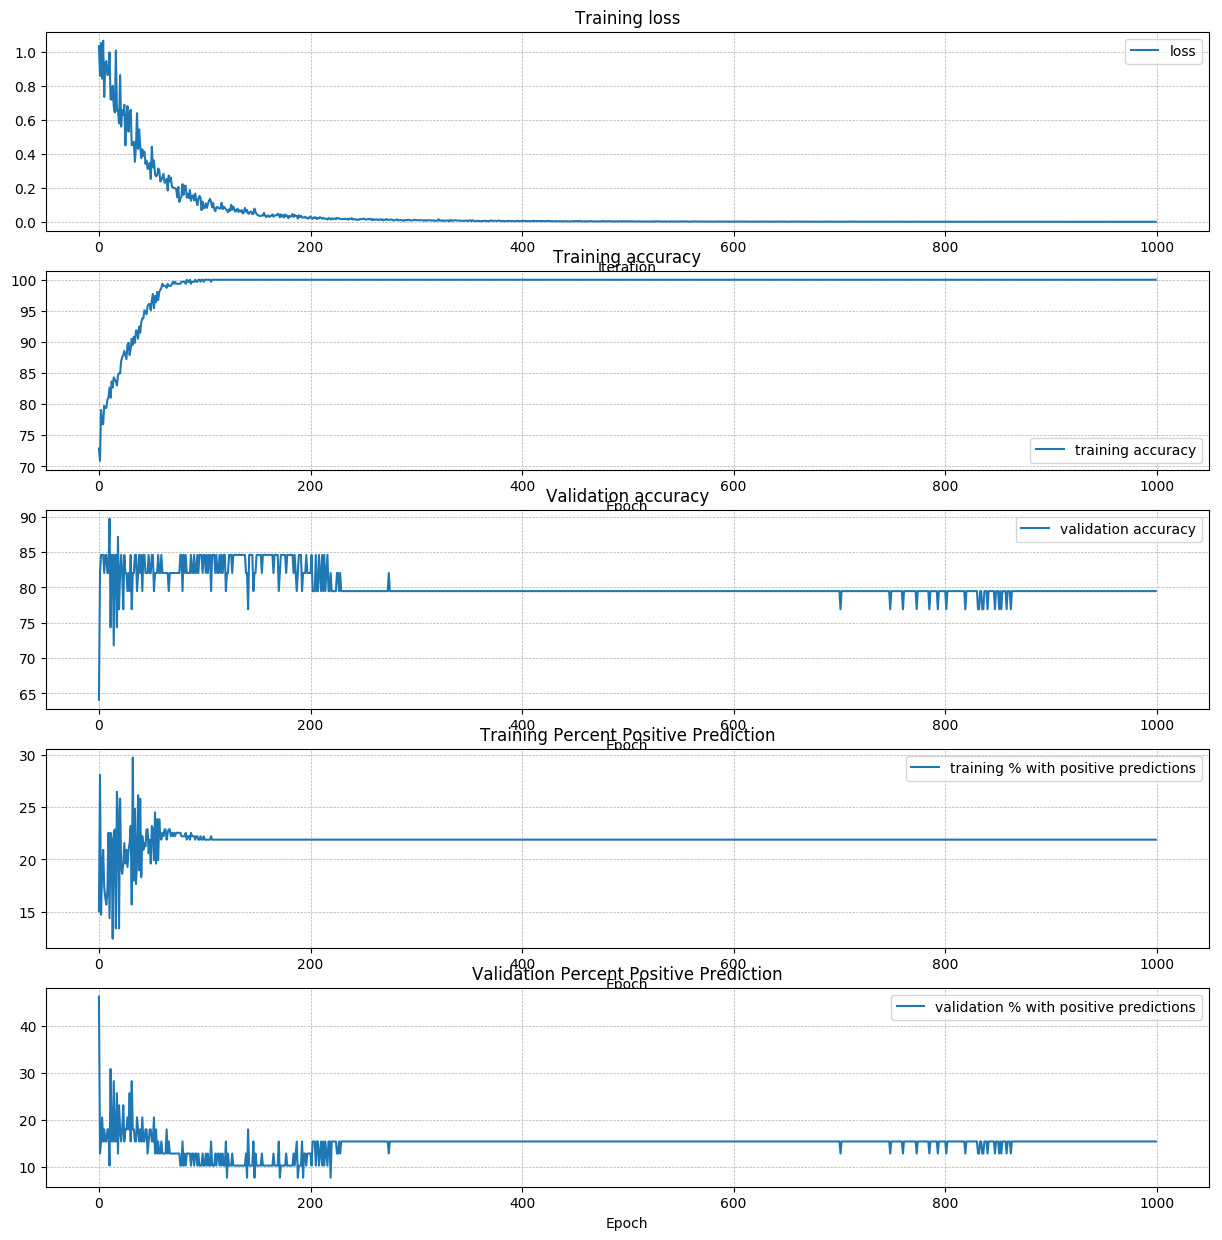

Finished running for lr: 0.0001, hidden size: 100, epochs: 1000
Epoch 0, loss = 1.5735, train_acc = 66.0131, val_acc = 84.6154, train_pos = 21.8954, val_pos = 5.1282
Epoch 1, loss = 1.1817, train_acc = 76.1438, val_acc = 82.0513, train_pos = 13.7255, val_pos = 23.0769
Epoch 2, loss = 0.7926, train_acc = 71.8954, val_acc = 82.0513, train_pos = 29.0850, val_pos = 12.8205
Epoch 3, loss = 0.7901, train_acc = 79.7386, val_acc = 84.6154, train_pos = 14.0523, val_pos = 10.2564
Epoch 4, loss = 0.7349, train_acc = 78.7582, val_acc = 84.6154, train_pos = 15.6863, val_pos = 20.5128
Epoch 5, loss = 0.9700, train_acc = 77.7778, val_acc = 84.6154, train_pos = 20.5882, val_pos = 15.3846
Epoch 6, loss = 0.9589, train_acc = 79.7386, val_acc = 84.6154, train_pos = 16.0131, val_pos = 15.3846
Epoch 7, loss = 0.6838, train_acc = 80.0654, val_acc = 84.6154, train_pos = 19.6078, val_pos = 20.5128
Epoch 8, loss = 0.7682, train_acc = 80.0654, val_acc = 87.1795, train_pos = 16.3399, val_pos = 12.8205
Epoch 9, l

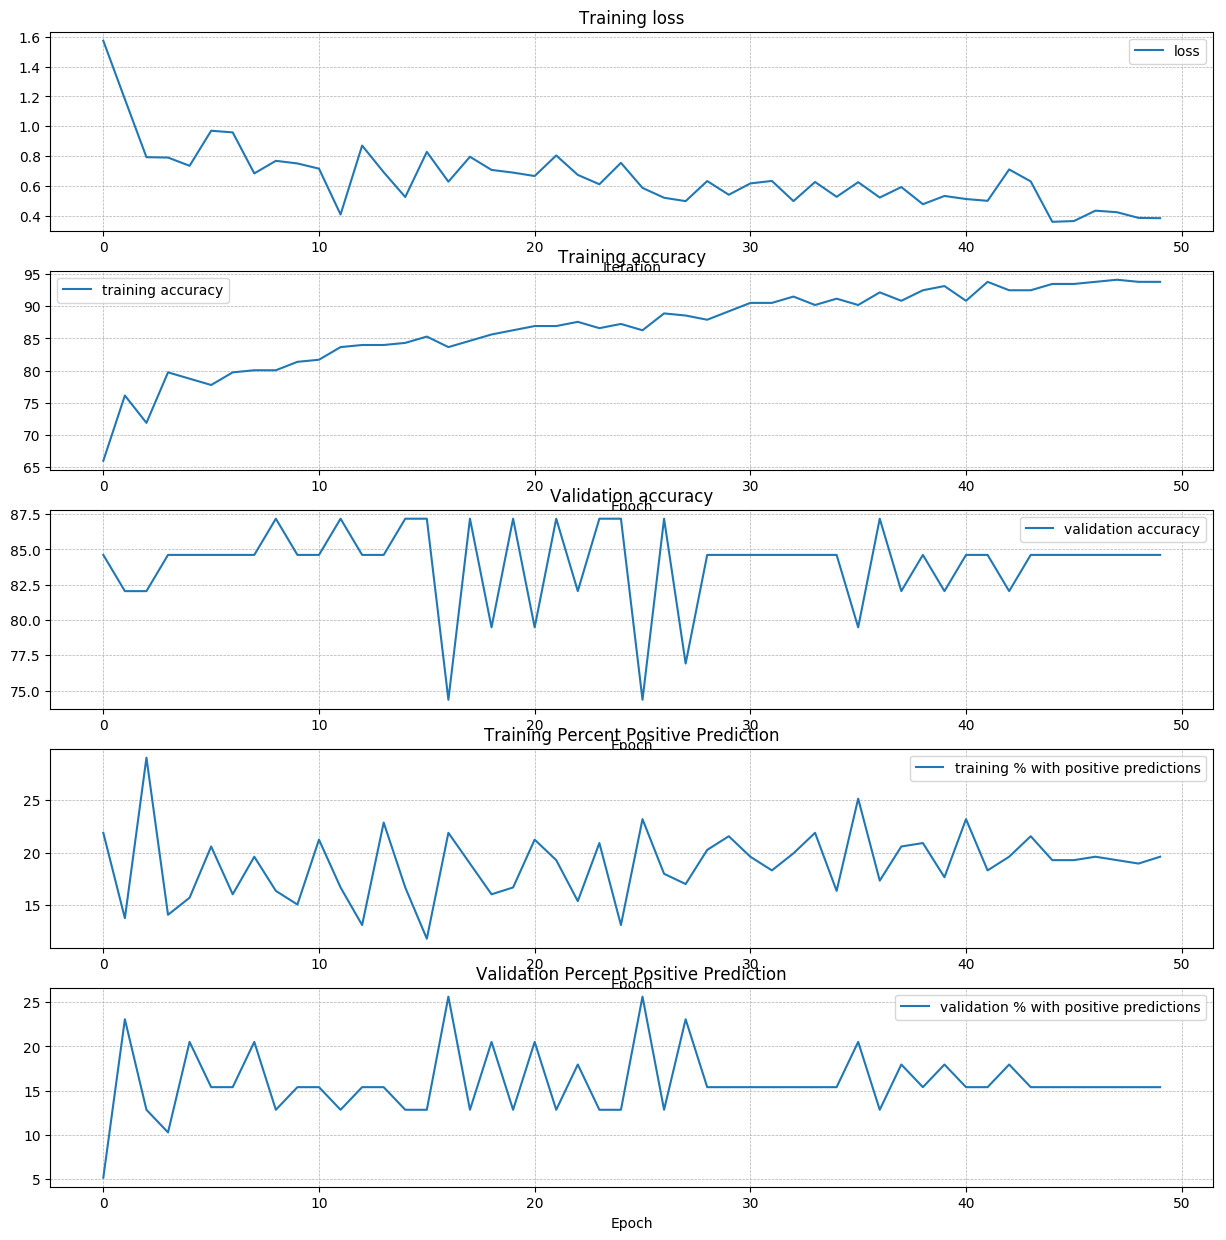

Finished running for lr: 0.001, hidden size: 100, epochs: 50
Epoch 0, loss = 0.9393, train_acc = 72.8758, val_acc = 84.6154, train_pos = 18.9542, val_pos = 10.2564
Epoch 1, loss = 0.9054, train_acc = 76.7974, val_acc = 87.1795, train_pos = 22.8758, val_pos = 12.8205
Epoch 2, loss = 0.8639, train_acc = 79.0850, val_acc = 71.7949, train_pos = 15.3595, val_pos = 38.4615
Epoch 3, loss = 0.9218, train_acc = 78.7582, val_acc = 84.6154, train_pos = 25.4902, val_pos = 15.3846
Epoch 4, loss = 0.8207, train_acc = 80.7190, val_acc = 84.6154, train_pos = 25.4902, val_pos = 15.3846
Epoch 5, loss = 0.7417, train_acc = 83.3333, val_acc = 61.5385, train_pos = 13.7255, val_pos = 53.8462
Epoch 6, loss = 0.9331, train_acc = 74.5098, val_acc = 87.1795, train_pos = 36.2745, val_pos = 7.6923
Epoch 7, loss = 0.6282, train_acc = 85.6209, val_acc = 74.3590, train_pos = 12.7451, val_pos = 25.6410
Epoch 8, loss = 0.8227, train_acc = 83.9869, val_acc = 87.1795, train_pos = 20.9150, val_pos = 12.8205
Epoch 9, loss

Epoch 79, loss = 0.1413, train_acc = 99.6732, val_acc = 84.6154, train_pos = 22.2222, val_pos = 10.2564
Epoch 80, loss = 0.1316, train_acc = 99.6732, val_acc = 84.6154, train_pos = 22.2222, val_pos = 10.2564
Epoch 81, loss = 0.1299, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 82, loss = 0.1272, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 17.9487
Epoch 83, loss = 0.1125, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 84, loss = 0.0850, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 85, loss = 0.1207, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 17.9487
Epoch 86, loss = 0.1534, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 87, loss = 0.1031, train_acc = 99.6732, val_acc = 82.0513, train_pos = 22.2222, val_pos = 12.8205
Epoch 88, loss = 0.1041, train_acc = 100.0000, val_acc = 8

Epoch 157, loss = 0.0240, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 158, loss = 0.0252, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 159, loss = 0.0224, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 160, loss = 0.0311, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 161, loss = 0.0338, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 162, loss = 0.0340, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 163, loss = 0.0377, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 164, loss = 0.0184, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 165, loss = 0.0271, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 166, loss = 0.0280, train_acc = 100.0000

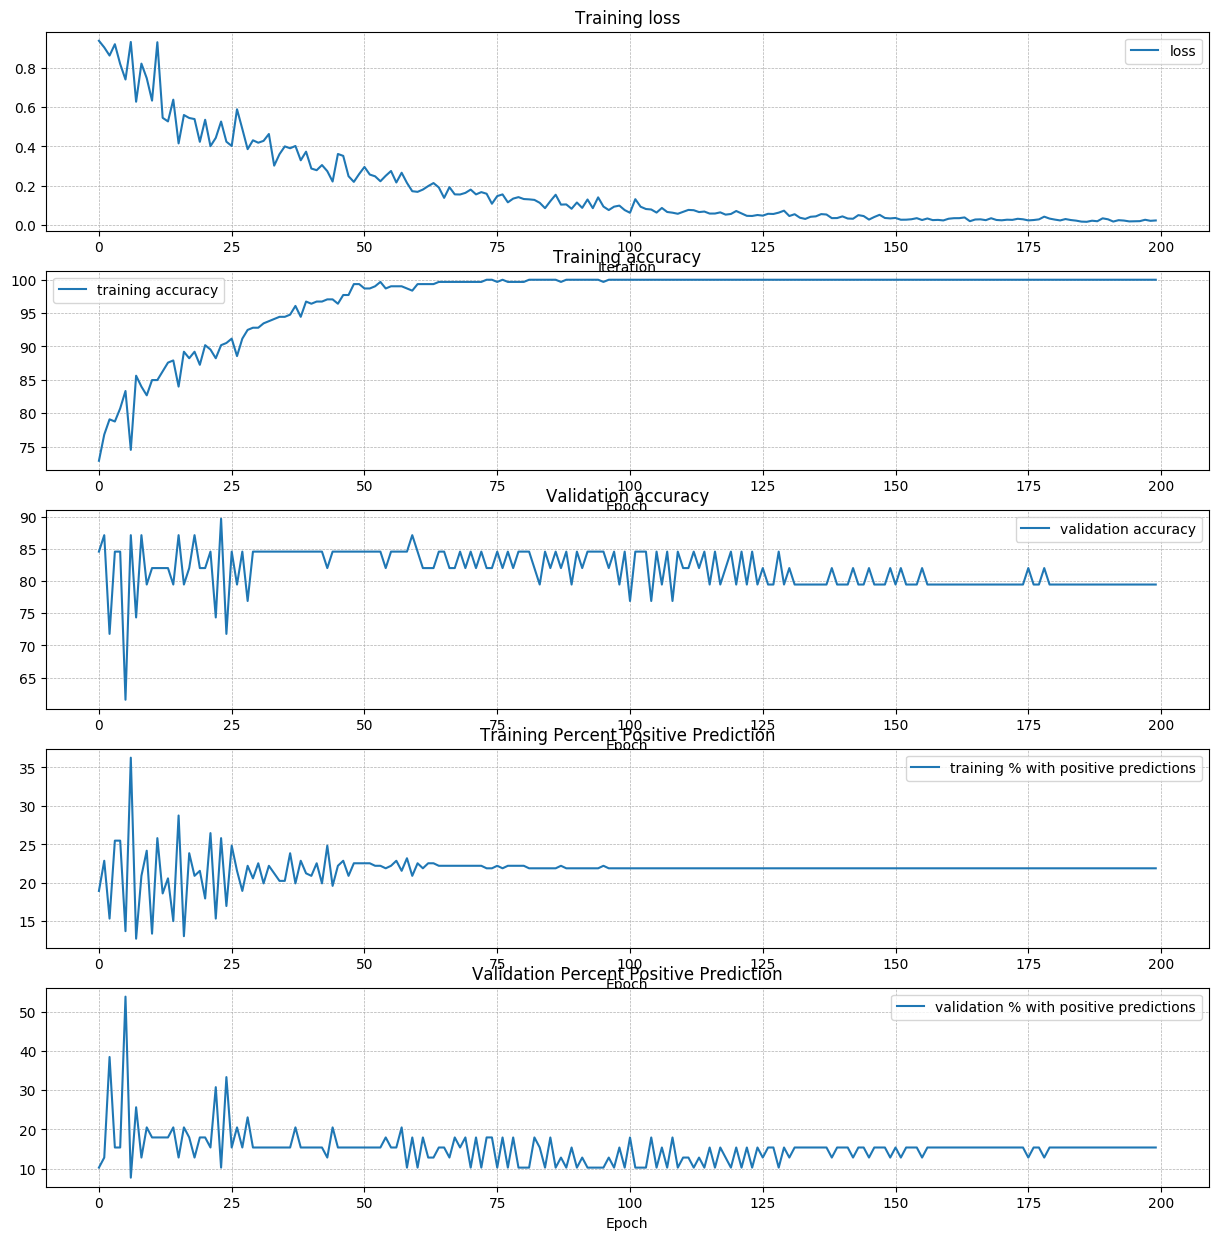

Finished running for lr: 0.001, hidden size: 100, epochs: 200
Epoch 0, loss = 0.8343, train_acc = 74.1830, val_acc = 84.6154, train_pos = 20.2614, val_pos = 5.1282
Epoch 1, loss = 0.8609, train_acc = 73.5294, val_acc = 61.5385, train_pos = 22.8758, val_pos = 53.8462
Epoch 2, loss = 0.7947, train_acc = 74.5098, val_acc = 89.7436, train_pos = 21.8954, val_pos = 10.2564
Epoch 3, loss = 0.9105, train_acc = 80.3922, val_acc = 84.6154, train_pos = 21.8954, val_pos = 20.5128
Epoch 4, loss = 0.6533, train_acc = 79.7386, val_acc = 87.1795, train_pos = 16.0131, val_pos = 12.8205
Epoch 5, loss = 0.6128, train_acc = 83.0065, val_acc = 79.4872, train_pos = 19.2810, val_pos = 20.5128
Epoch 6, loss = 0.8032, train_acc = 82.6797, val_acc = 87.1795, train_pos = 18.3007, val_pos = 12.8205
Epoch 7, loss = 0.7964, train_acc = 82.3529, val_acc = 87.1795, train_pos = 21.2418, val_pos = 12.8205
Epoch 8, loss = 0.8089, train_acc = 86.6013, val_acc = 79.4872, train_pos = 14.3791, val_pos = 20.5128
Epoch 9, los

Epoch 80, loss = 0.1746, train_acc = 99.6732, val_acc = 82.0513, train_pos = 22.2222, val_pos = 12.8205
Epoch 81, loss = 0.1310, train_acc = 99.6732, val_acc = 82.0513, train_pos = 22.2222, val_pos = 12.8205
Epoch 82, loss = 0.1342, train_acc = 99.6732, val_acc = 84.6154, train_pos = 22.2222, val_pos = 10.2564
Epoch 83, loss = 0.0838, train_acc = 99.6732, val_acc = 82.0513, train_pos = 22.2222, val_pos = 12.8205
Epoch 84, loss = 0.0985, train_acc = 99.6732, val_acc = 84.6154, train_pos = 22.2222, val_pos = 10.2564
Epoch 85, loss = 0.0968, train_acc = 99.6732, val_acc = 82.0513, train_pos = 22.2222, val_pos = 12.8205
Epoch 86, loss = 0.1362, train_acc = 99.6732, val_acc = 84.6154, train_pos = 22.2222, val_pos = 10.2564
Epoch 87, loss = 0.1314, train_acc = 99.6732, val_acc = 82.0513, train_pos = 22.2222, val_pos = 12.8205
Epoch 88, loss = 0.1866, train_acc = 99.6732, val_acc = 84.6154, train_pos = 22.2222, val_pos = 10.2564
Epoch 89, loss = 0.1128, train_acc = 99.6732, val_acc = 82.0513,

Epoch 158, loss = 0.0341, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 159, loss = 0.0349, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 160, loss = 0.0319, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 161, loss = 0.0328, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 162, loss = 0.0508, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 163, loss = 0.0432, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 164, loss = 0.0343, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 165, loss = 0.0361, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 166, loss = 0.0448, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 167, loss = 0.0454, train_acc = 100.0000

Epoch 236, loss = 0.0197, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 237, loss = 0.0163, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 238, loss = 0.0150, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 239, loss = 0.0207, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 240, loss = 0.0112, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 241, loss = 0.0132, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 242, loss = 0.0215, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 243, loss = 0.0165, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 244, loss = 0.0114, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 245, loss = 0.0141, train_acc = 100.0000

Epoch 314, loss = 0.0072, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 315, loss = 0.0090, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 316, loss = 0.0084, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 317, loss = 0.0097, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 318, loss = 0.0087, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 319, loss = 0.0060, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 320, loss = 0.0052, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 321, loss = 0.0088, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 322, loss = 0.0065, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 323, loss = 0.0070, train_acc = 100.0000

Epoch 392, loss = 0.0044, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 393, loss = 0.0060, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 394, loss = 0.0042, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 395, loss = 0.0044, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 396, loss = 0.0043, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 397, loss = 0.0040, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 398, loss = 0.0050, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 399, loss = 0.0038, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 400, loss = 0.0033, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 401, loss = 0.0058, train_acc = 100.0000

Epoch 470, loss = 0.0031, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 471, loss = 0.0026, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 472, loss = 0.0030, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 473, loss = 0.0026, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 474, loss = 0.0038, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 475, loss = 0.0027, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 476, loss = 0.0033, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 477, loss = 0.0035, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 478, loss = 0.0037, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 479, loss = 0.0028, train_acc = 100.0000

Epoch 548, loss = 0.0022, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 549, loss = 0.0018, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 550, loss = 0.0019, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 551, loss = 0.0023, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 552, loss = 0.0020, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 553, loss = 0.0023, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 554, loss = 0.0018, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 555, loss = 0.0017, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 556, loss = 0.0020, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 557, loss = 0.0033, train_acc = 100.0000

Epoch 627, loss = 0.0015, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 628, loss = 0.0017, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 629, loss = 0.0013, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 630, loss = 0.0017, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 631, loss = 0.0015, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 632, loss = 0.0014, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 633, loss = 0.0016, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 634, loss = 0.0013, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 635, loss = 0.0007, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 636, loss = 0.0014, train_acc = 100.0000

Epoch 706, loss = 0.0008, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 707, loss = 0.0010, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 708, loss = 0.0010, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 709, loss = 0.0010, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 710, loss = 0.0012, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 711, loss = 0.0010, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 712, loss = 0.0011, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 713, loss = 0.0011, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 714, loss = 0.0008, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 715, loss = 0.0009, train_acc = 100.0000

Epoch 784, loss = 0.0006, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 785, loss = 0.0010, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 786, loss = 0.0008, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 787, loss = 0.0007, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 788, loss = 0.0006, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 789, loss = 0.0008, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 790, loss = 0.0010, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 791, loss = 0.0008, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 792, loss = 0.0010, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 793, loss = 0.0007, train_acc = 100.0000

Epoch 863, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 864, loss = 0.0007, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 865, loss = 0.0005, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 866, loss = 0.0006, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 867, loss = 0.0003, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 868, loss = 0.0005, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 869, loss = 0.0006, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 870, loss = 0.0005, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 871, loss = 0.0006, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 872, loss = 0.0007, train_acc = 100.0000

Epoch 942, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 943, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 944, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 945, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 946, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 947, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 948, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 949, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 950, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 951, loss = 0.0003, train_acc = 100.0000

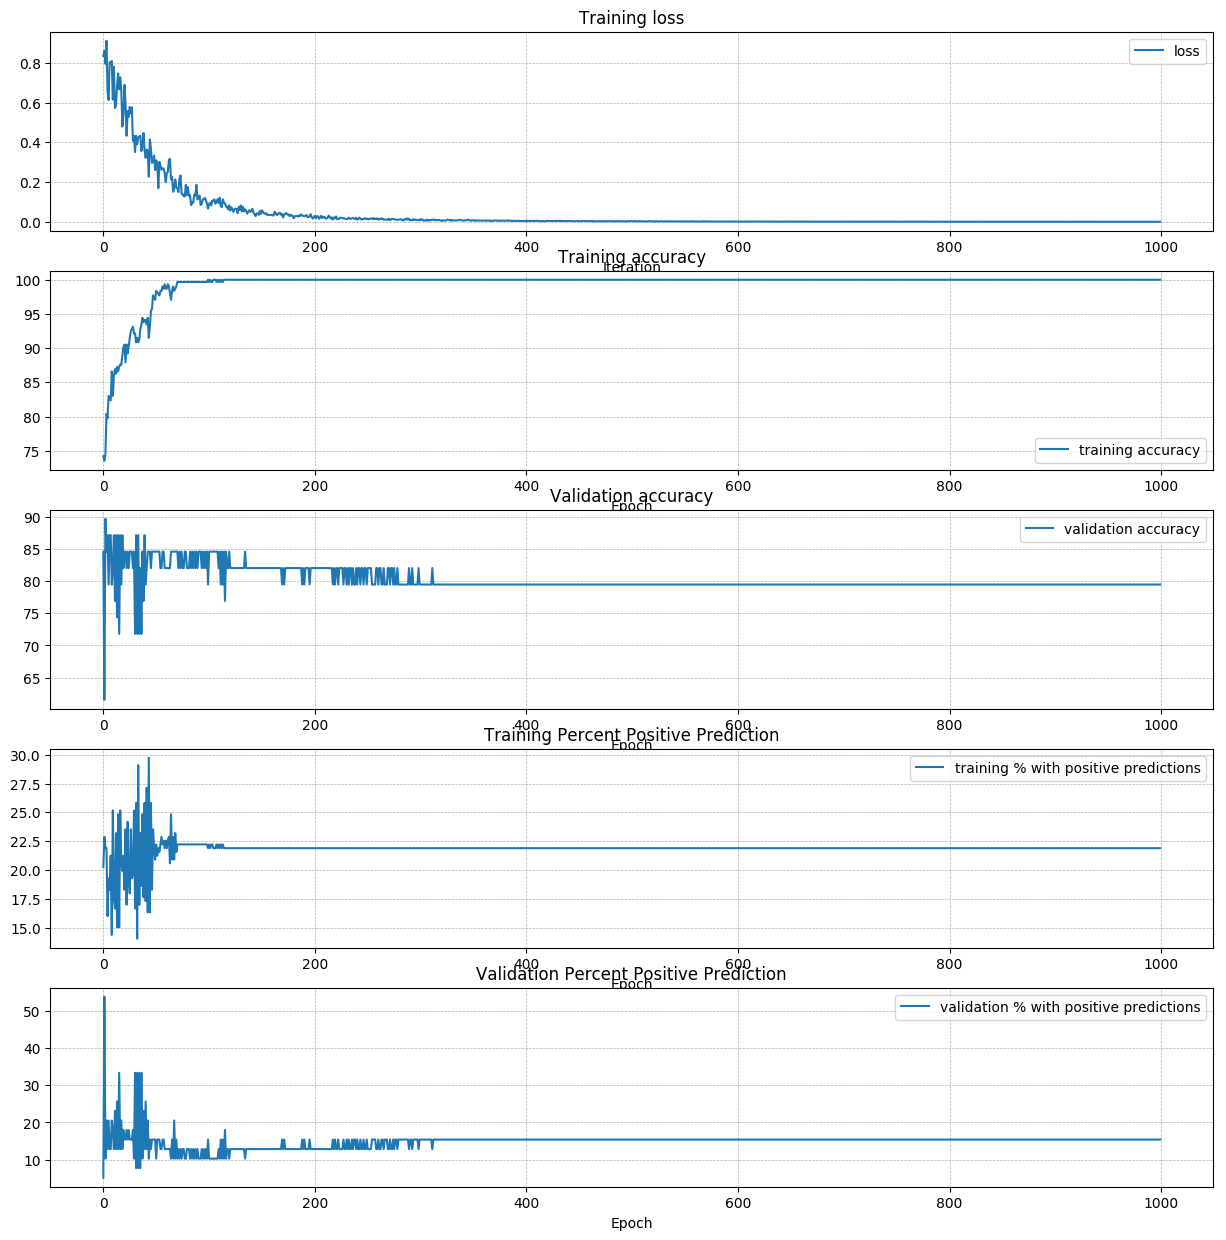

Finished running for lr: 0.001, hidden size: 100, epochs: 1000
Epoch 0, loss = 0.9488, train_acc = 67.6471, val_acc = 82.0513, train_pos = 24.8366, val_pos = 2.5641
Epoch 1, loss = 0.9052, train_acc = 78.4314, val_acc = 82.0513, train_pos = 13.3987, val_pos = 28.2051
Epoch 2, loss = 0.8238, train_acc = 73.8562, val_acc = 82.0513, train_pos = 27.7778, val_pos = 12.8205
Epoch 3, loss = 0.7664, train_acc = 80.3922, val_acc = 89.7436, train_pos = 13.3987, val_pos = 10.2564
Epoch 4, loss = 0.9994, train_acc = 78.1046, val_acc = 82.0513, train_pos = 16.3399, val_pos = 23.0769
Epoch 5, loss = 0.9202, train_acc = 79.0850, val_acc = 82.0513, train_pos = 22.5490, val_pos = 17.9487
Epoch 6, loss = 0.7405, train_acc = 80.3922, val_acc = 87.1795, train_pos = 14.0523, val_pos = 12.8205
Epoch 7, loss = 0.7642, train_acc = 80.7190, val_acc = 84.6154, train_pos = 19.6078, val_pos = 15.3846
Epoch 8, loss = 0.8483, train_acc = 81.6993, val_acc = 84.6154, train_pos = 19.2810, val_pos = 15.3846
Epoch 9, lo

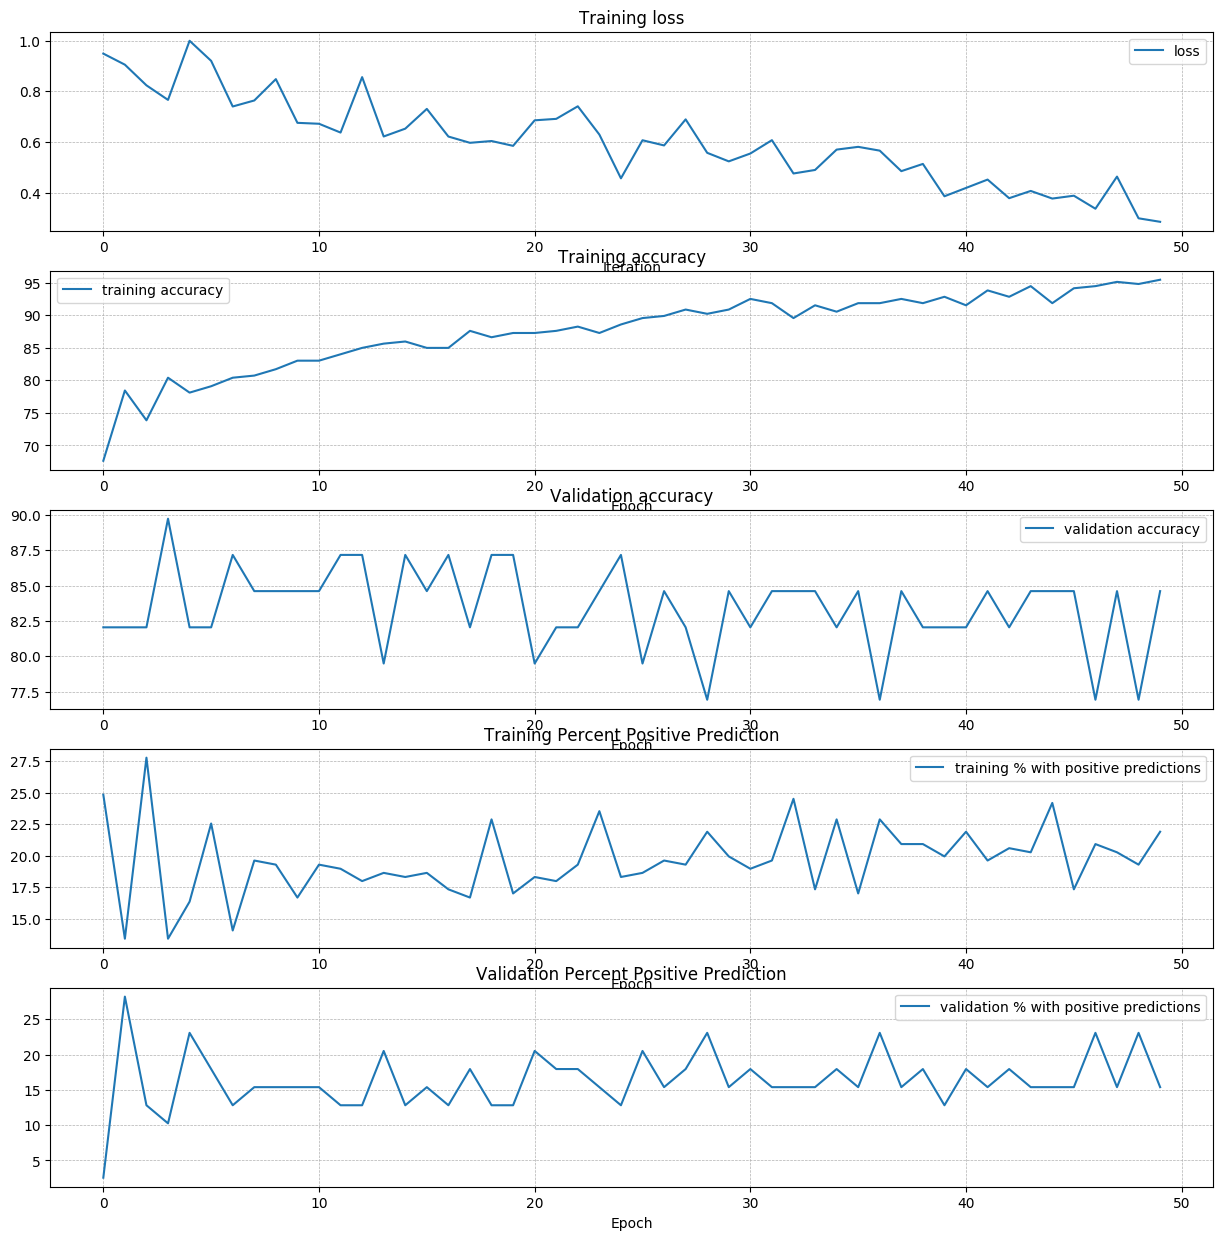

Finished running for lr: 0.01, hidden size: 100, epochs: 50
Epoch 0, loss = 0.8279, train_acc = 56.5359, val_acc = 79.4872, train_pos = 43.1373, val_pos = 0.0000
Epoch 1, loss = 0.9595, train_acc = 79.0850, val_acc = 87.1795, train_pos = 3.5948, val_pos = 7.6923
Epoch 2, loss = 1.1290, train_acc = 79.0850, val_acc = 84.6154, train_pos = 14.7059, val_pos = 15.3846
Epoch 3, loss = 0.7414, train_acc = 78.4314, val_acc = 82.0513, train_pos = 16.6667, val_pos = 12.8205
Epoch 4, loss = 1.1535, train_acc = 79.4118, val_acc = 87.1795, train_pos = 13.7255, val_pos = 7.6923
Epoch 5, loss = 0.8466, train_acc = 80.3922, val_acc = 82.0513, train_pos = 12.0915, val_pos = 12.8205
Epoch 6, loss = 1.0461, train_acc = 78.7582, val_acc = 84.6154, train_pos = 18.9542, val_pos = 20.5128
Epoch 7, loss = 0.8708, train_acc = 79.0850, val_acc = 89.7436, train_pos = 18.6275, val_pos = 10.2564
Epoch 8, loss = 0.6940, train_acc = 81.0458, val_acc = 87.1795, train_pos = 12.7451, val_pos = 12.8205
Epoch 9, loss = 0

Epoch 79, loss = 0.4184, train_acc = 96.0784, val_acc = 84.6154, train_pos = 19.9346, val_pos = 15.3846
Epoch 80, loss = 0.2812, train_acc = 96.0784, val_acc = 82.0513, train_pos = 21.2418, val_pos = 12.8205
Epoch 81, loss = 0.2940, train_acc = 96.7320, val_acc = 82.0513, train_pos = 19.2810, val_pos = 12.8205
Epoch 82, loss = 0.3387, train_acc = 96.4052, val_acc = 82.0513, train_pos = 20.2614, val_pos = 17.9487
Epoch 83, loss = 0.3782, train_acc = 97.0588, val_acc = 79.4872, train_pos = 20.2614, val_pos = 10.2564
Epoch 84, loss = 0.3922, train_acc = 97.0588, val_acc = 82.0513, train_pos = 19.6078, val_pos = 17.9487
Epoch 85, loss = 0.2751, train_acc = 96.7320, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 86, loss = 0.2354, train_acc = 97.0588, val_acc = 84.6154, train_pos = 20.2614, val_pos = 15.3846
Epoch 87, loss = 0.2430, train_acc = 96.7320, val_acc = 84.6154, train_pos = 19.2810, val_pos = 15.3846
Epoch 88, loss = 0.3100, train_acc = 96.7320, val_acc = 84.6154,

Epoch 158, loss = 0.1480, train_acc = 99.6732, val_acc = 84.6154, train_pos = 22.2222, val_pos = 10.2564
Epoch 159, loss = 0.1153, train_acc = 99.6732, val_acc = 82.0513, train_pos = 22.2222, val_pos = 12.8205
Epoch 160, loss = 0.0896, train_acc = 99.6732, val_acc = 79.4872, train_pos = 22.2222, val_pos = 15.3846
Epoch 161, loss = 0.0647, train_acc = 99.6732, val_acc = 82.0513, train_pos = 22.2222, val_pos = 7.6923
Epoch 162, loss = 0.0933, train_acc = 99.6732, val_acc = 82.0513, train_pos = 22.2222, val_pos = 12.8205
Epoch 163, loss = 0.0684, train_acc = 99.6732, val_acc = 79.4872, train_pos = 22.2222, val_pos = 15.3846
Epoch 164, loss = 0.0929, train_acc = 99.6732, val_acc = 84.6154, train_pos = 22.2222, val_pos = 10.2564
Epoch 165, loss = 0.0921, train_acc = 99.6732, val_acc = 84.6154, train_pos = 22.2222, val_pos = 10.2564
Epoch 166, loss = 0.1179, train_acc = 99.6732, val_acc = 76.9231, train_pos = 22.2222, val_pos = 17.9487
Epoch 167, loss = 0.1449, train_acc = 99.6732, val_acc =

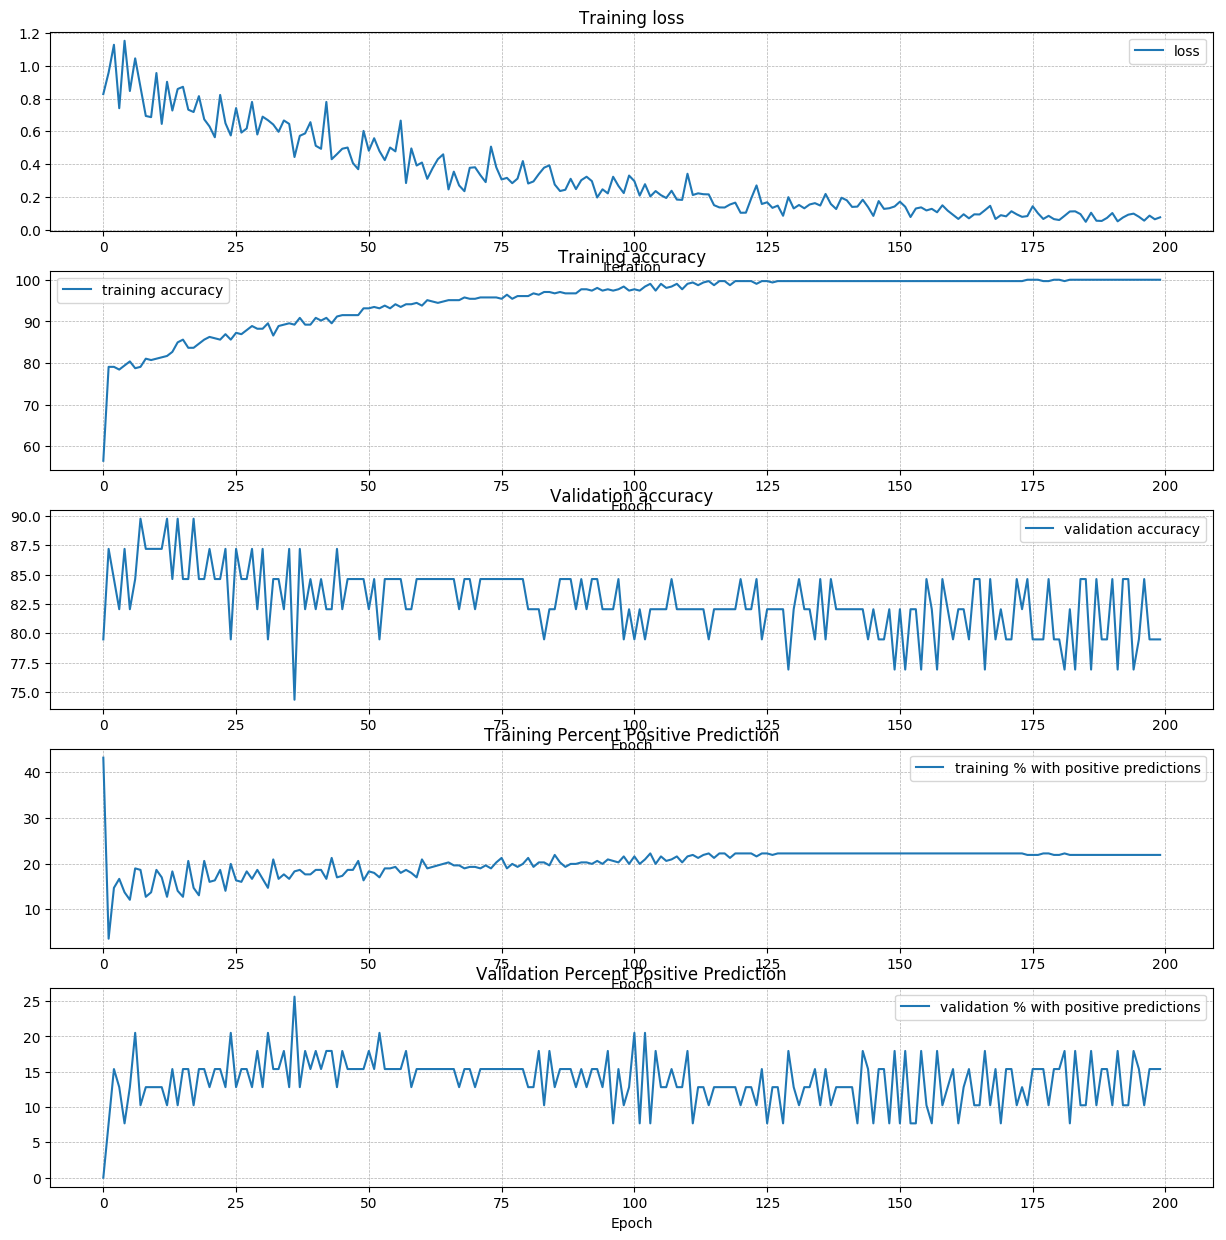

Finished running for lr: 0.01, hidden size: 100, epochs: 200
Epoch 0, loss = 1.0425, train_acc = 62.0915, val_acc = 79.4872, train_pos = 33.0065, val_pos = 0.0000
Epoch 1, loss = 0.9705, train_acc = 80.3922, val_acc = 87.1795, train_pos = 2.9412, val_pos = 7.6923
Epoch 2, loss = 0.9277, train_acc = 78.4314, val_acc = 79.4872, train_pos = 19.2810, val_pos = 25.6410
Epoch 3, loss = 0.8579, train_acc = 75.1634, val_acc = 82.0513, train_pos = 24.5098, val_pos = 12.8205
Epoch 4, loss = 1.1021, train_acc = 79.7386, val_acc = 87.1795, train_pos = 12.7451, val_pos = 7.6923
Epoch 5, loss = 0.9034, train_acc = 81.6993, val_acc = 82.0513, train_pos = 9.4771, val_pos = 12.8205
Epoch 6, loss = 1.0570, train_acc = 79.0850, val_acc = 82.0513, train_pos = 18.6275, val_pos = 23.0769
Epoch 7, loss = 0.9330, train_acc = 77.4510, val_acc = 84.6154, train_pos = 24.1830, val_pos = 15.3846
Epoch 8, loss = 0.9084, train_acc = 81.0458, val_acc = 89.7436, train_pos = 14.0523, val_pos = 10.2564
Epoch 9, loss = 0

Epoch 80, loss = 0.2605, train_acc = 97.0588, val_acc = 84.6154, train_pos = 19.6078, val_pos = 15.3846
Epoch 81, loss = 0.3429, train_acc = 97.3856, val_acc = 84.6154, train_pos = 20.5882, val_pos = 15.3846
Epoch 82, loss = 0.3035, train_acc = 97.3856, val_acc = 82.0513, train_pos = 20.5882, val_pos = 12.8205
Epoch 83, loss = 0.2488, train_acc = 97.7124, val_acc = 84.6154, train_pos = 20.2614, val_pos = 15.3846
Epoch 84, loss = 0.2362, train_acc = 97.7124, val_acc = 84.6154, train_pos = 20.9150, val_pos = 15.3846
Epoch 85, loss = 0.1882, train_acc = 97.0588, val_acc = 84.6154, train_pos = 20.2614, val_pos = 10.2564
Epoch 86, loss = 0.2025, train_acc = 97.3856, val_acc = 82.0513, train_pos = 20.5882, val_pos = 12.8205
Epoch 87, loss = 0.1887, train_acc = 97.3856, val_acc = 82.0513, train_pos = 19.9346, val_pos = 12.8205
Epoch 88, loss = 0.2836, train_acc = 97.3856, val_acc = 84.6154, train_pos = 20.5882, val_pos = 15.3846
Epoch 89, loss = 0.2649, train_acc = 97.7124, val_acc = 82.0513,

Epoch 159, loss = 0.1006, train_acc = 99.6732, val_acc = 82.0513, train_pos = 22.2222, val_pos = 7.6923
Epoch 160, loss = 0.0626, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 7.6923
Epoch 161, loss = 0.0840, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 162, loss = 0.1037, train_acc = 99.6732, val_acc = 79.4872, train_pos = 22.2222, val_pos = 10.2564
Epoch 163, loss = 0.0975, train_acc = 99.6732, val_acc = 82.0513, train_pos = 22.2222, val_pos = 7.6923
Epoch 164, loss = 0.0777, train_acc = 99.6732, val_acc = 82.0513, train_pos = 22.2222, val_pos = 7.6923
Epoch 165, loss = 0.0774, train_acc = 99.6732, val_acc = 76.9231, train_pos = 22.2222, val_pos = 12.8205
Epoch 166, loss = 0.0748, train_acc = 99.6732, val_acc = 82.0513, train_pos = 22.2222, val_pos = 7.6923
Epoch 167, loss = 0.0919, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 7.6923
Epoch 168, loss = 0.0803, train_acc = 99.6732, val_acc = 7

Epoch 237, loss = 0.0402, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 238, loss = 0.0346, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 239, loss = 0.0476, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 240, loss = 0.0256, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 241, loss = 0.0334, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 242, loss = 0.0361, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 243, loss = 0.0319, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 244, loss = 0.0281, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 245, loss = 0.0248, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 246, loss = 0.0292, train_acc = 100.0000

Epoch 316, loss = 0.0108, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 317, loss = 0.0196, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 318, loss = 0.0202, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 319, loss = 0.0113, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 320, loss = 0.0149, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 321, loss = 0.0109, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 322, loss = 0.0190, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 323, loss = 0.0165, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 324, loss = 0.0156, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 325, loss = 0.0144, train_acc = 100.0000

Epoch 395, loss = 0.0064, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 396, loss = 0.0110, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 397, loss = 0.0179, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 398, loss = 0.0111, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 399, loss = 0.0130, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 400, loss = 0.0105, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 401, loss = 0.0081, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 402, loss = 0.0112, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 403, loss = 0.0124, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 404, loss = 0.0085, train_acc = 100.0000

Epoch 474, loss = 0.0040, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 475, loss = 0.0053, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 476, loss = 0.0054, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 477, loss = 0.0075, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 478, loss = 0.0051, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 479, loss = 0.0051, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 480, loss = 0.0077, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 481, loss = 0.0074, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 482, loss = 0.0098, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 483, loss = 0.0066, train_acc = 100.0000

Epoch 552, loss = 0.0062, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 553, loss = 0.0061, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 554, loss = 0.0033, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 555, loss = 0.0037, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 556, loss = 0.0033, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 557, loss = 0.0033, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 558, loss = 0.0034, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 559, loss = 0.0036, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 560, loss = 0.0038, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 561, loss = 0.0053, train_acc = 100.0000

Epoch 630, loss = 0.0019, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 631, loss = 0.0041, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 632, loss = 0.0036, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 633, loss = 0.0020, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 634, loss = 0.0018, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 635, loss = 0.0021, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 636, loss = 0.0020, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 637, loss = 0.0028, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 638, loss = 0.0042, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 639, loss = 0.0025, train_acc = 100.0000

Epoch 709, loss = 0.0020, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 710, loss = 0.0020, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 711, loss = 0.0019, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 712, loss = 0.0023, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 713, loss = 0.0016, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 714, loss = 0.0016, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 715, loss = 0.0029, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 716, loss = 0.0017, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 717, loss = 0.0020, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 718, loss = 0.0020, train_acc = 100.0000

Epoch 787, loss = 0.0011, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 788, loss = 0.0018, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 789, loss = 0.0014, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 790, loss = 0.0012, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 791, loss = 0.0015, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 792, loss = 0.0016, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 793, loss = 0.0022, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 794, loss = 0.0020, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 795, loss = 0.0017, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 796, loss = 0.0021, train_acc = 100.0000

Epoch 866, loss = 0.0008, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 867, loss = 0.0014, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 868, loss = 0.0014, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 869, loss = 0.0012, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 870, loss = 0.0010, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 871, loss = 0.0011, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 872, loss = 0.0016, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 873, loss = 0.0007, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 874, loss = 0.0010, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 875, loss = 0.0008, train_acc = 100.0000

Epoch 944, loss = 0.0009, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 945, loss = 0.0009, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 946, loss = 0.0008, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 947, loss = 0.0008, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 948, loss = 0.0011, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 949, loss = 0.0010, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 950, loss = 0.0011, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 951, loss = 0.0008, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 952, loss = 0.0007, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 953, loss = 0.0012, train_acc = 100.0000

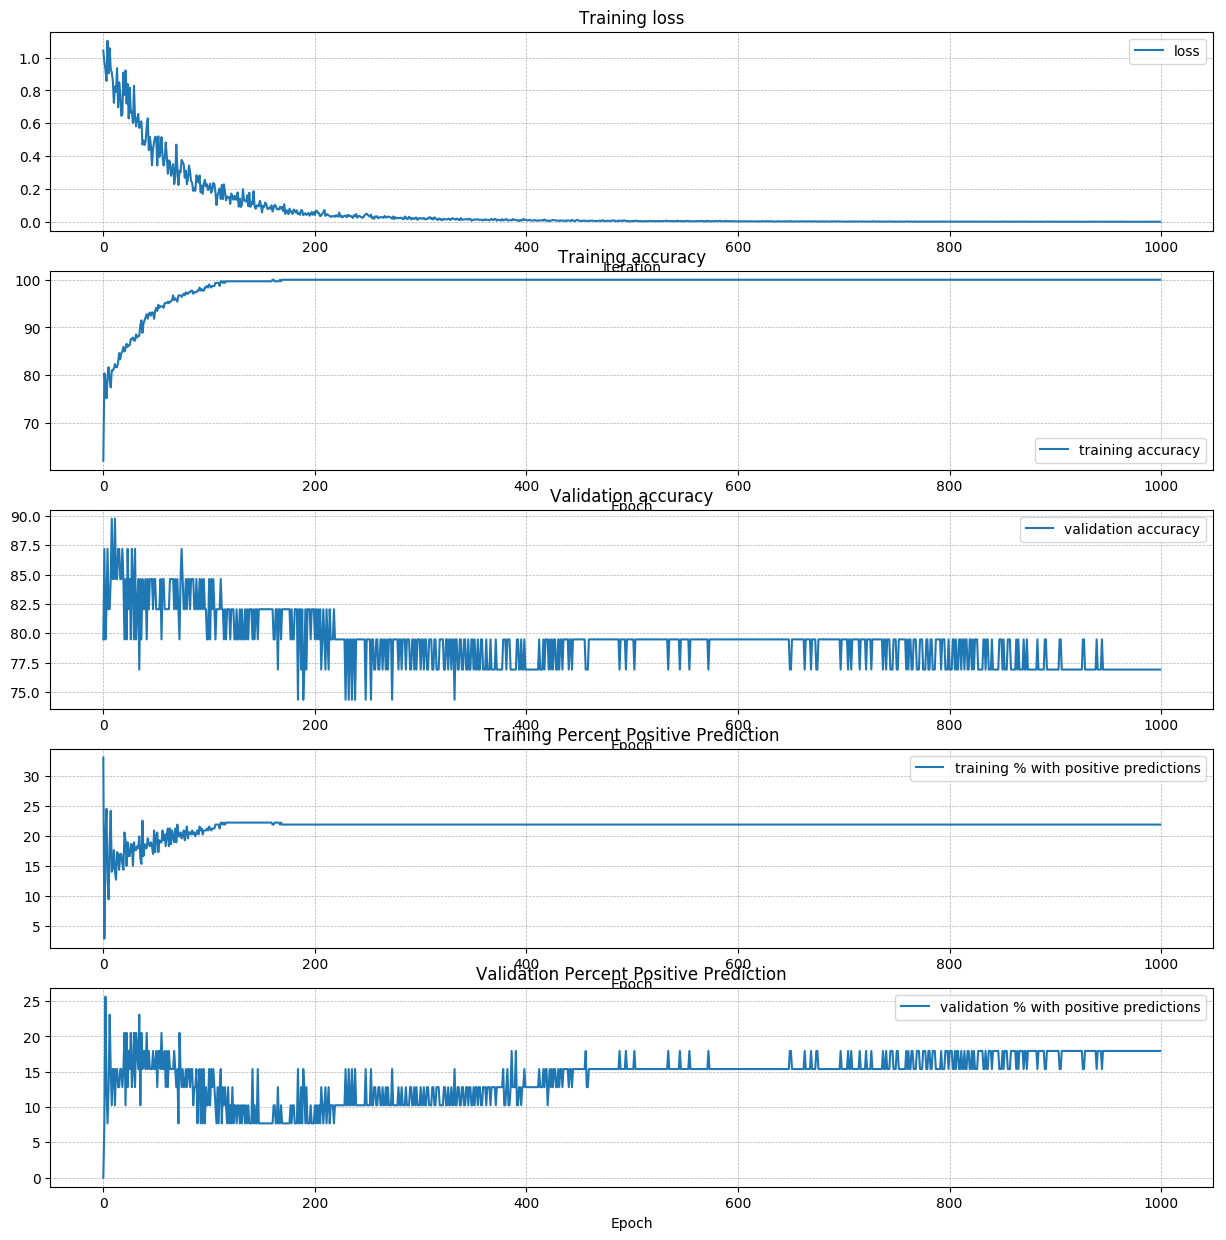

Finished running for lr: 0.01, hidden size: 100, epochs: 1000
Epoch 0, loss = 1.1759, train_acc = 66.0131, val_acc = 84.6154, train_pos = 28.4314, val_pos = 5.1282
Epoch 1, loss = 0.8725, train_acc = 74.1830, val_acc = 84.6154, train_pos = 26.7974, val_pos = 20.5128
Epoch 2, loss = 0.6558, train_acc = 79.4118, val_acc = 89.7436, train_pos = 17.6471, val_pos = 10.2564
Epoch 3, loss = 0.7603, train_acc = 80.3922, val_acc = 66.6667, train_pos = 14.7059, val_pos = 33.3333
Epoch 4, loss = 0.6912, train_acc = 83.3333, val_acc = 82.0513, train_pos = 19.6078, val_pos = 17.9487
Epoch 5, loss = 0.5760, train_acc = 85.6209, val_acc = 71.7949, train_pos = 19.2810, val_pos = 28.2051
Epoch 6, loss = 0.9909, train_acc = 83.0065, val_acc = 79.4872, train_pos = 21.2418, val_pos = 20.5128
Epoch 7, loss = 0.6337, train_acc = 84.6405, val_acc = 82.0513, train_pos = 26.7974, val_pos = 17.9487
Epoch 8, loss = 0.9490, train_acc = 86.9281, val_acc = 84.6154, train_pos = 18.6275, val_pos = 15.3846
Epoch 9, los

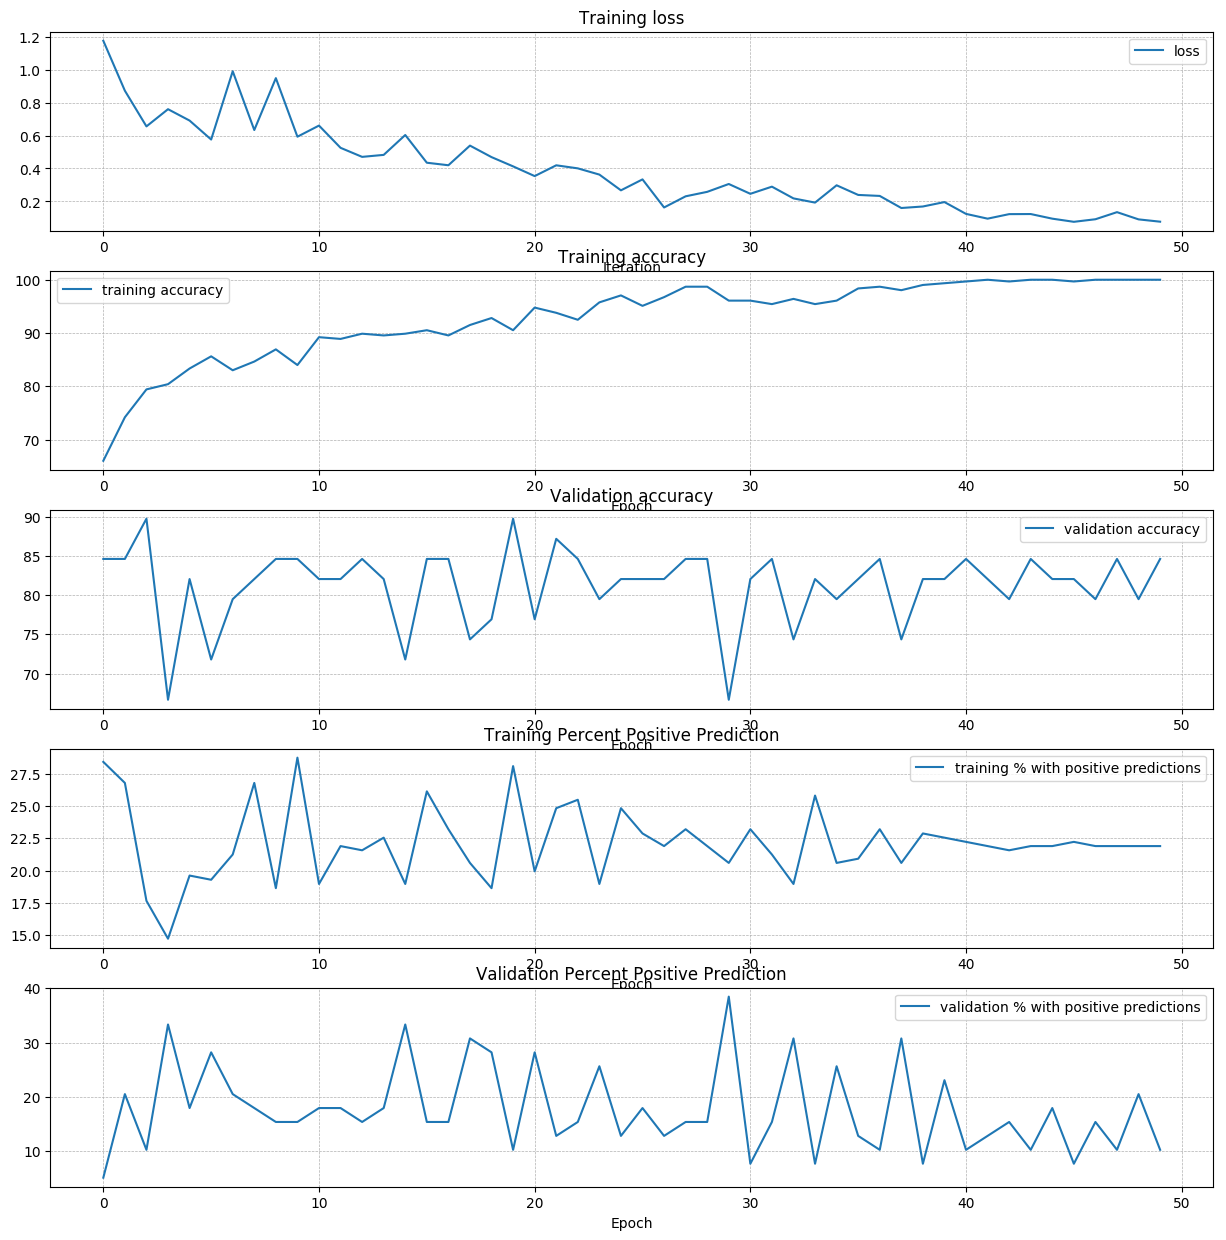

Finished running for lr: 1e-06, hidden size: 1000, epochs: 50
Epoch 0, loss = 1.2262, train_acc = 70.5882, val_acc = 51.2821, train_pos = 21.8954, val_pos = 69.2308
Epoch 1, loss = 0.9208, train_acc = 70.9150, val_acc = 89.7436, train_pos = 24.1830, val_pos = 10.2564
Epoch 2, loss = 1.0299, train_acc = 71.2418, val_acc = 84.6154, train_pos = 34.3137, val_pos = 20.5128
Epoch 3, loss = 0.6467, train_acc = 81.0458, val_acc = 84.6154, train_pos = 14.0523, val_pos = 15.3846
Epoch 4, loss = 0.8678, train_acc = 81.3725, val_acc = 74.3590, train_pos = 19.6078, val_pos = 25.6410
Epoch 5, loss = 0.8969, train_acc = 82.3529, val_acc = 76.9231, train_pos = 21.2418, val_pos = 23.0769
Epoch 6, loss = 0.6156, train_acc = 82.6797, val_acc = 82.0513, train_pos = 23.5294, val_pos = 17.9487
Epoch 7, loss = 0.7700, train_acc = 83.3333, val_acc = 69.2308, train_pos = 17.6471, val_pos = 30.7692
Epoch 8, loss = 0.6094, train_acc = 82.6797, val_acc = 87.1795, train_pos = 27.4510, val_pos = 12.8205
Epoch 9, lo

Epoch 79, loss = 0.0422, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 80, loss = 0.0431, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 81, loss = 0.0682, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 23.0769
Epoch 82, loss = 0.0405, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 83, loss = 0.0370, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 84, loss = 0.0311, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 85, loss = 0.0325, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 86, loss = 0.0493, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 87, loss = 0.0428, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 88, loss = 0.0401, train_acc = 100.0000, val_acc 

Epoch 157, loss = 0.0064, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 158, loss = 0.0077, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 159, loss = 0.0066, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 160, loss = 0.0071, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 161, loss = 0.0067, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 162, loss = 0.0051, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 163, loss = 0.0053, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 164, loss = 0.0055, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 165, loss = 0.0075, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 166, loss = 0.0059, train_acc = 100.0000

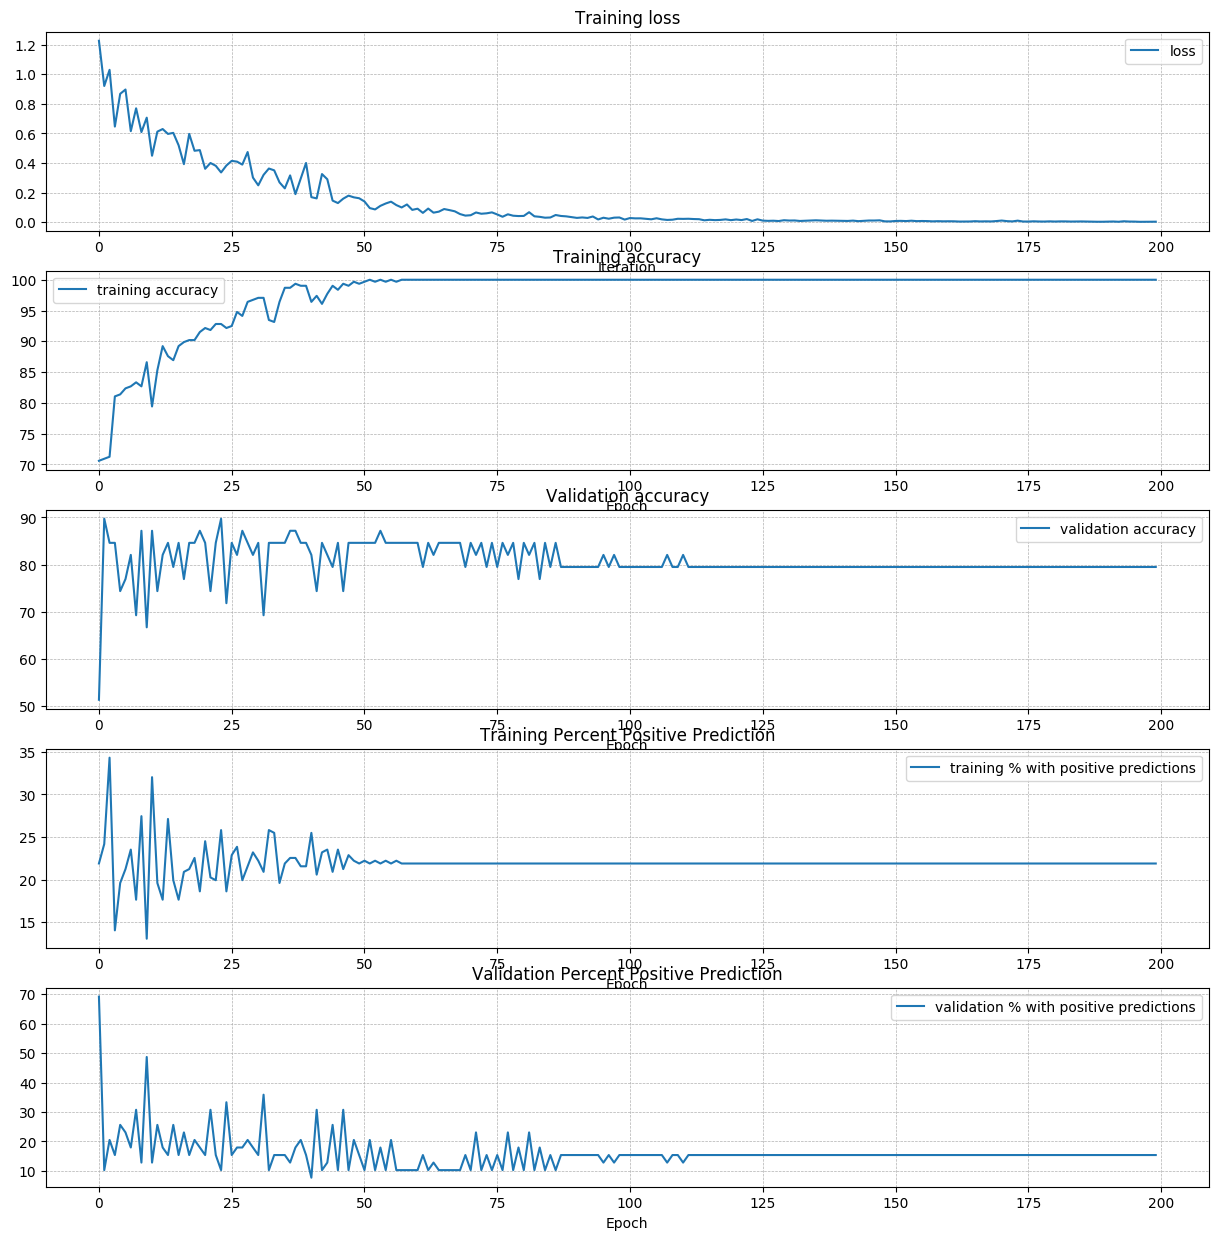

Finished running for lr: 1e-06, hidden size: 1000, epochs: 200
Epoch 0, loss = 1.1135, train_acc = 70.9150, val_acc = 48.7179, train_pos = 21.5686, val_pos = 71.7949
Epoch 1, loss = 1.0718, train_acc = 67.3203, val_acc = 84.6154, train_pos = 33.6601, val_pos = 5.1282
Epoch 2, loss = 0.8165, train_acc = 78.4314, val_acc = 76.9231, train_pos = 19.2810, val_pos = 38.4615
Epoch 3, loss = 1.0220, train_acc = 80.0654, val_acc = 84.6154, train_pos = 17.6471, val_pos = 15.3846
Epoch 4, loss = 0.9296, train_acc = 81.0458, val_acc = 79.4872, train_pos = 27.1242, val_pos = 20.5128
Epoch 5, loss = 0.7381, train_acc = 83.3333, val_acc = 84.6154, train_pos = 17.6471, val_pos = 15.3846
Epoch 6, loss = 0.6758, train_acc = 85.2941, val_acc = 76.9231, train_pos = 17.6471, val_pos = 23.0769
Epoch 7, loss = 0.5914, train_acc = 85.2941, val_acc = 87.1795, train_pos = 22.8758, val_pos = 12.8205
Epoch 8, loss = 0.8934, train_acc = 82.6797, val_acc = 74.3590, train_pos = 15.0327, val_pos = 30.7692
Epoch 9, lo

Epoch 79, loss = 0.0410, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 80, loss = 0.0377, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 81, loss = 0.0474, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 82, loss = 0.0396, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 83, loss = 0.0295, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 84, loss = 0.0474, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 85, loss = 0.0391, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 86, loss = 0.0380, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 87, loss = 0.0288, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 88, loss = 0.0345, train_acc = 100.0000, val_acc 

Epoch 157, loss = 0.0088, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 158, loss = 0.0062, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 159, loss = 0.0083, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 160, loss = 0.0078, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 161, loss = 0.0099, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 162, loss = 0.0065, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 163, loss = 0.0068, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 164, loss = 0.0078, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 165, loss = 0.0060, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 166, loss = 0.0067, train_acc = 100.0000

Epoch 235, loss = 0.0025, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 236, loss = 0.0038, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 237, loss = 0.0023, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 238, loss = 0.0030, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 239, loss = 0.0029, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 240, loss = 0.0033, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 241, loss = 0.0027, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 242, loss = 0.0035, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 243, loss = 0.0032, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 244, loss = 0.0029, train_acc = 100.0000

Epoch 313, loss = 0.0011, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 314, loss = 0.0015, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 315, loss = 0.0017, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 316, loss = 0.0017, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 317, loss = 0.0013, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 318, loss = 0.0015, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 319, loss = 0.0016, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 320, loss = 0.0020, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 321, loss = 0.0017, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 322, loss = 0.0009, train_acc = 100.0000

Epoch 391, loss = 0.0010, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 392, loss = 0.0008, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 393, loss = 0.0007, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 394, loss = 0.0008, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 395, loss = 0.0007, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 396, loss = 0.0007, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 397, loss = 0.0009, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 398, loss = 0.0007, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 399, loss = 0.0009, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 400, loss = 0.0008, train_acc = 100.0000

Epoch 469, loss = 0.0005, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 470, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 471, loss = 0.0006, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 472, loss = 0.0006, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 473, loss = 0.0006, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 474, loss = 0.0005, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 475, loss = 0.0005, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 476, loss = 0.0005, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 477, loss = 0.0003, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 478, loss = 0.0006, train_acc = 100.0000

Epoch 547, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 548, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 549, loss = 0.0003, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 550, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 551, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 552, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 553, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 554, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 555, loss = 0.0003, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 556, loss = 0.0002, train_acc = 100.0000

Epoch 625, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 626, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 627, loss = 0.0003, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 628, loss = 0.0003, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 629, loss = 0.0003, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 630, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 631, loss = 0.0003, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 632, loss = 0.0003, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 633, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 634, loss = 0.0003, train_acc = 100.0000

Epoch 703, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 704, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 705, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 706, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 707, loss = 0.0003, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 708, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 709, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 710, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 711, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 712, loss = 0.0001, train_acc = 100.0000

Epoch 781, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 782, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 783, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 784, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 785, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 786, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 787, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 788, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 789, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 790, loss = 0.0002, train_acc = 100.0000

Epoch 859, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 860, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 861, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 862, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 863, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 864, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 865, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 866, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 867, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 868, loss = 0.0001, train_acc = 100.0000

Epoch 937, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 938, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 939, loss = 0.0000, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 940, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 941, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 942, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 943, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 944, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 945, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 946, loss = 0.0001, train_acc = 100.0000

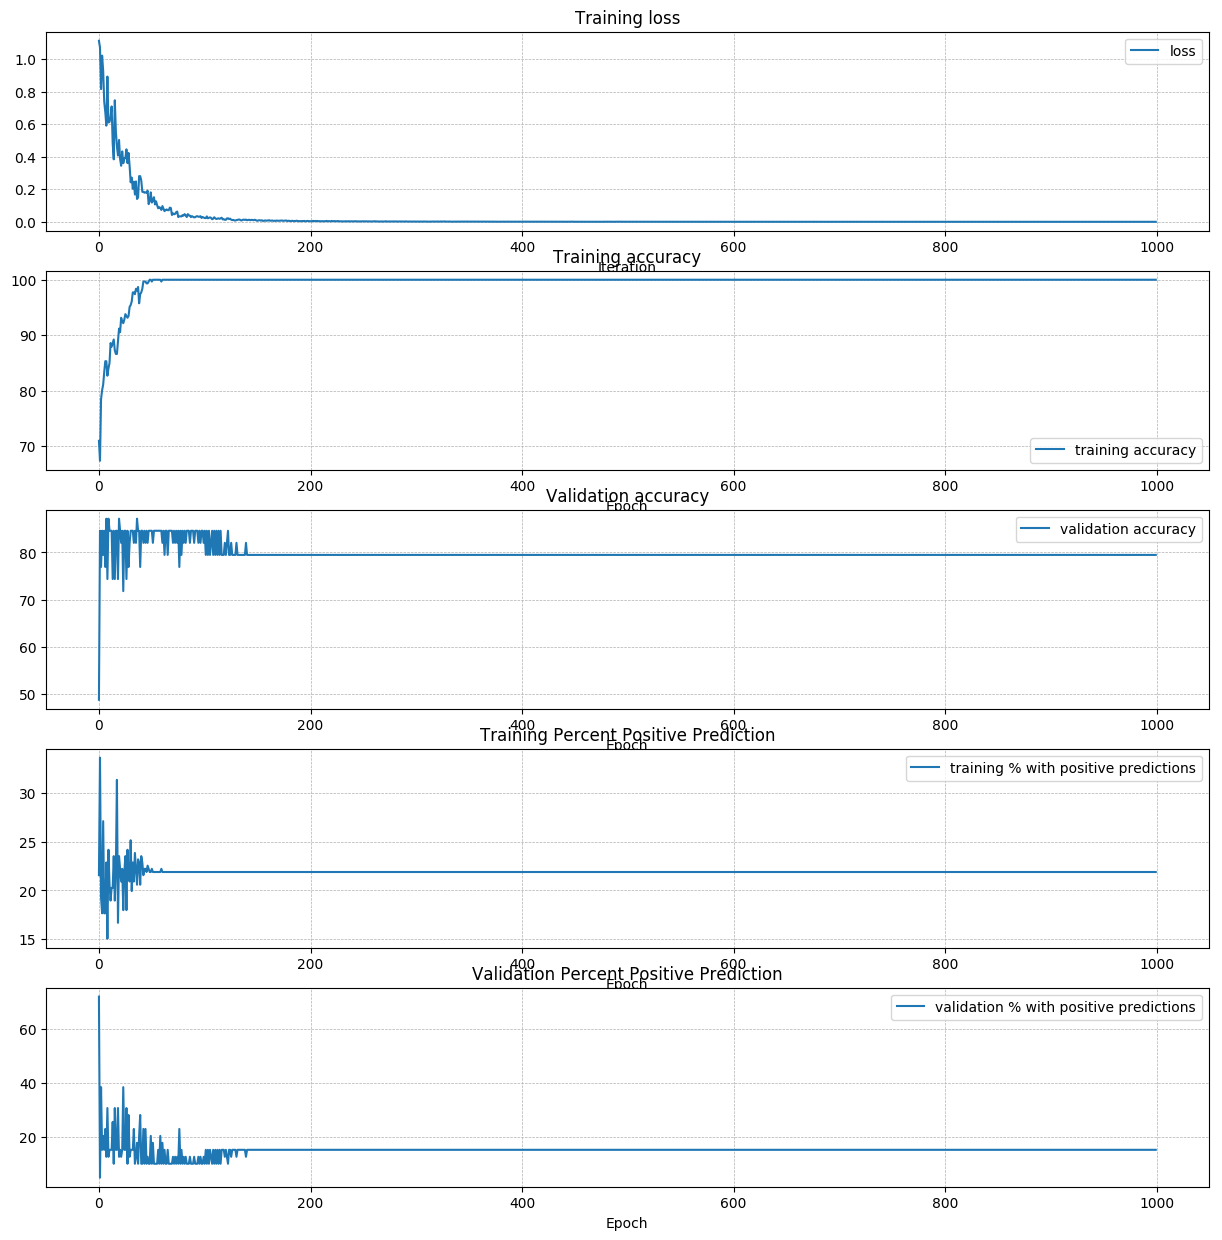

Finished running for lr: 1e-06, hidden size: 1000, epochs: 1000
Epoch 0, loss = 1.5222, train_acc = 59.1503, val_acc = 84.6154, train_pos = 29.4118, val_pos = 5.1282
Epoch 1, loss = 1.2227, train_acc = 73.5294, val_acc = 69.2308, train_pos = 26.7974, val_pos = 41.0256
Epoch 2, loss = 1.0955, train_acc = 73.8562, val_acc = 87.1795, train_pos = 28.4314, val_pos = 7.6923
Epoch 3, loss = 0.9779, train_acc = 80.0654, val_acc = 84.6154, train_pos = 11.1111, val_pos = 15.3846
Epoch 4, loss = 0.9314, train_acc = 76.4706, val_acc = 74.3590, train_pos = 25.8170, val_pos = 35.8974
Epoch 5, loss = 0.7721, train_acc = 81.0458, val_acc = 89.7436, train_pos = 19.9346, val_pos = 10.2564
Epoch 6, loss = 0.8947, train_acc = 81.3725, val_acc = 82.0513, train_pos = 13.0719, val_pos = 17.9487
Epoch 7, loss = 0.6102, train_acc = 81.6993, val_acc = 84.6154, train_pos = 24.5098, val_pos = 15.3846
Epoch 8, loss = 0.6763, train_acc = 81.6993, val_acc = 87.1795, train_pos = 16.6667, val_pos = 12.8205
Epoch 9, lo

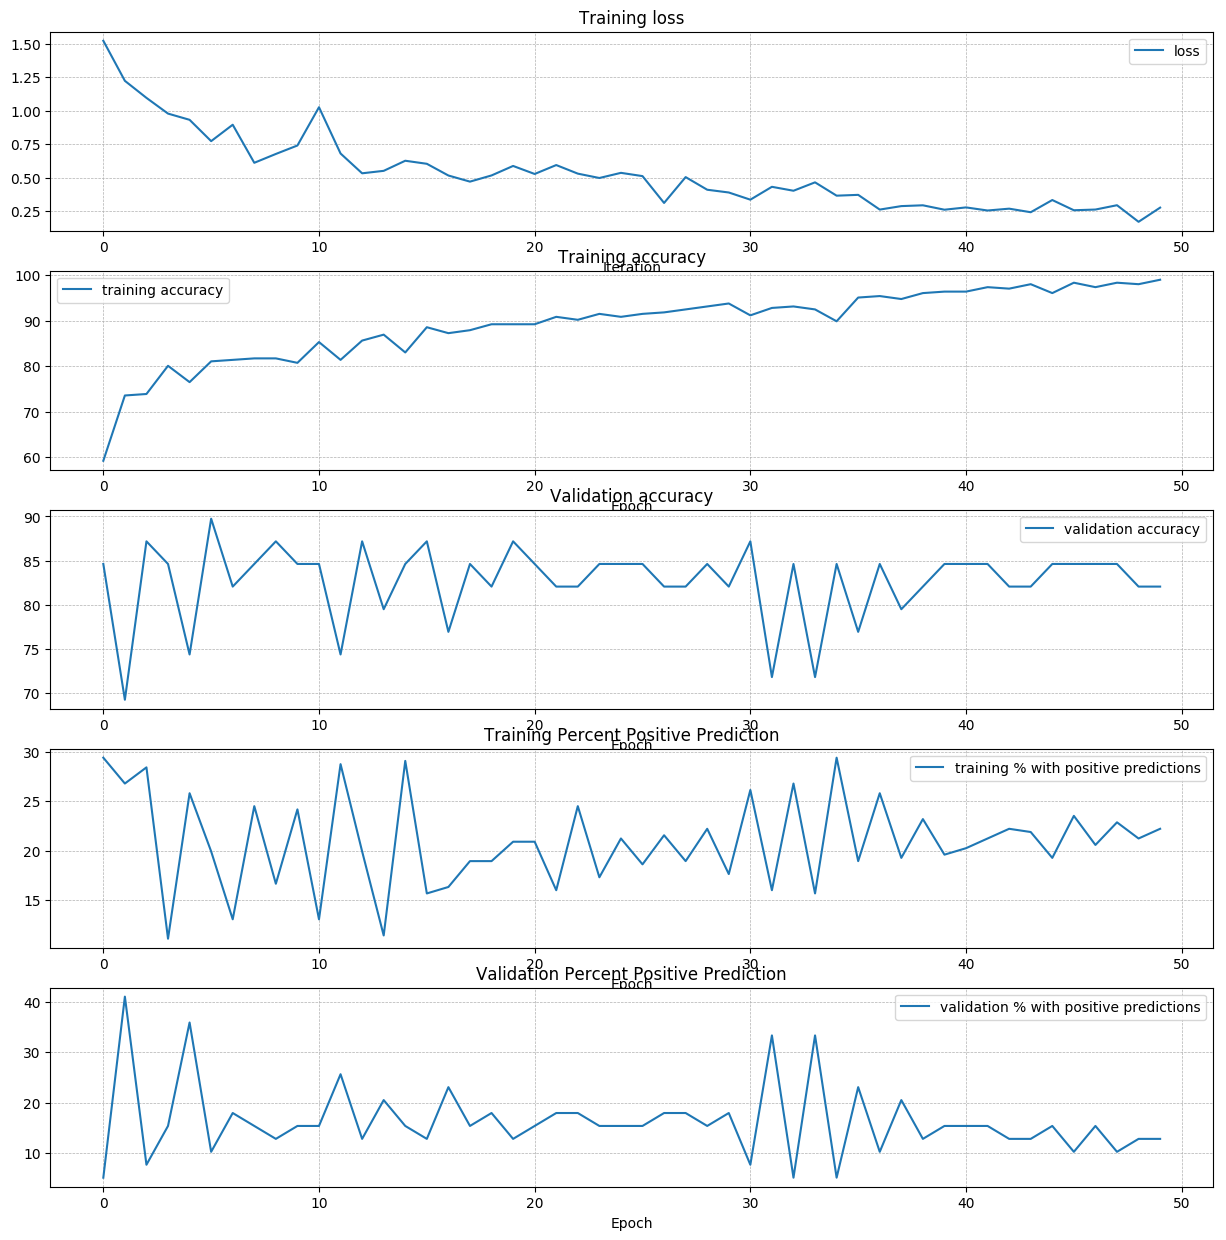

Finished running for lr: 1e-05, hidden size: 1000, epochs: 50
Epoch 0, loss = 1.2962, train_acc = 73.8562, val_acc = 82.0513, train_pos = 24.5098, val_pos = 2.5641
Epoch 1, loss = 0.9590, train_acc = 72.8758, val_acc = 76.9231, train_pos = 29.4118, val_pos = 28.2051
Epoch 2, loss = 0.7837, train_acc = 81.6993, val_acc = 71.7949, train_pos = 10.7843, val_pos = 43.5897
Epoch 3, loss = 0.8279, train_acc = 67.9739, val_acc = 87.1795, train_pos = 44.1176, val_pos = 7.6923
Epoch 4, loss = 0.7816, train_acc = 82.3529, val_acc = 71.7949, train_pos = 9.4771, val_pos = 38.4615
Epoch 5, loss = 0.6674, train_acc = 79.0850, val_acc = 87.1795, train_pos = 34.3137, val_pos = 12.8205
Epoch 6, loss = 0.6890, train_acc = 82.6797, val_acc = 74.3590, train_pos = 11.1111, val_pos = 25.6410
Epoch 7, loss = 0.5514, train_acc = 82.3529, val_acc = 84.6154, train_pos = 29.0850, val_pos = 15.3846
Epoch 8, loss = 0.6864, train_acc = 87.2549, val_acc = 71.7949, train_pos = 12.4183, val_pos = 28.2051
Epoch 9, loss 

Epoch 79, loss = 0.0324, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 80, loss = 0.0256, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 81, loss = 0.0192, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 82, loss = 0.0307, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 83, loss = 0.0324, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 84, loss = 0.0242, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 85, loss = 0.0177, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 86, loss = 0.0237, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 87, loss = 0.0198, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 88, loss = 0.0165, train_acc = 100.0000, val_acc 

Epoch 157, loss = 0.0050, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 158, loss = 0.0057, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 159, loss = 0.0058, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 160, loss = 0.0044, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 161, loss = 0.0036, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 162, loss = 0.0043, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 163, loss = 0.0038, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 164, loss = 0.0052, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 165, loss = 0.0044, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 166, loss = 0.0045, train_acc = 100.0000

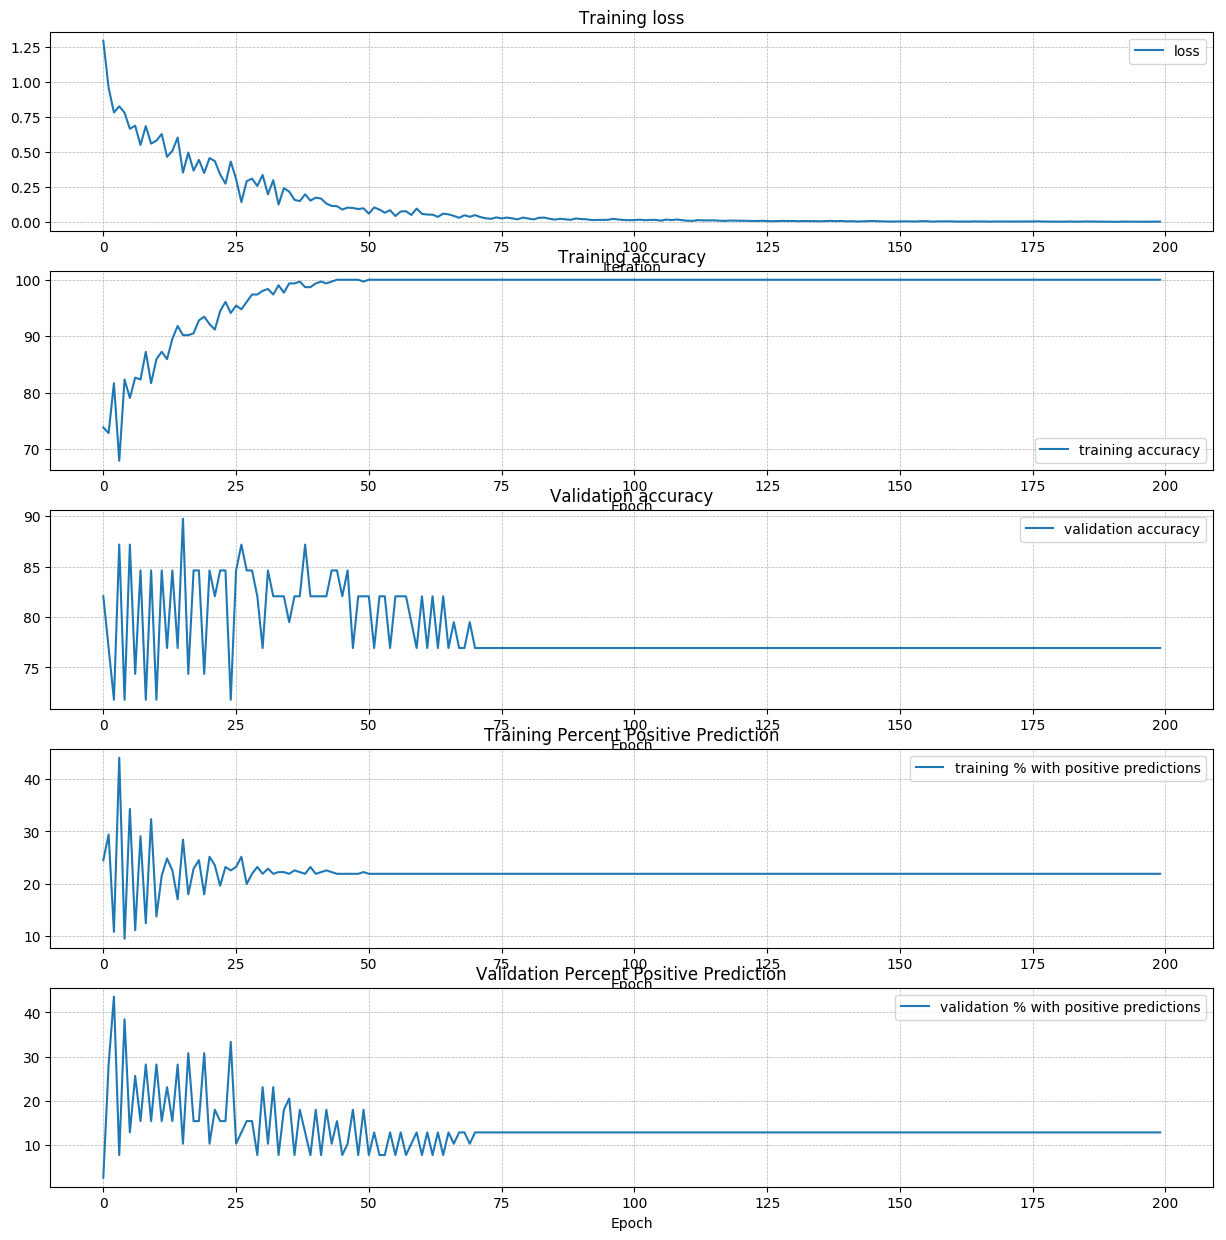

Finished running for lr: 1e-05, hidden size: 1000, epochs: 200
Epoch 0, loss = 1.1647, train_acc = 64.7059, val_acc = 71.7949, train_pos = 25.8170, val_pos = 43.5897
Epoch 1, loss = 1.6365, train_acc = 69.2810, val_acc = 84.6154, train_pos = 32.3529, val_pos = 5.1282
Epoch 2, loss = 0.7758, train_acc = 77.7778, val_acc = 64.1026, train_pos = 25.1634, val_pos = 51.2821
Epoch 3, loss = 0.7236, train_acc = 81.0458, val_acc = 87.1795, train_pos = 21.8954, val_pos = 12.8205
Epoch 4, loss = 0.8536, train_acc = 83.3333, val_acc = 71.7949, train_pos = 18.9542, val_pos = 38.4615
Epoch 5, loss = 0.3999, train_acc = 82.0261, val_acc = 87.1795, train_pos = 24.1830, val_pos = 12.8205
Epoch 6, loss = 0.5634, train_acc = 84.3137, val_acc = 66.6667, train_pos = 16.0131, val_pos = 38.4615
Epoch 7, loss = 0.9838, train_acc = 83.6601, val_acc = 84.6154, train_pos = 19.9346, val_pos = 15.3846
Epoch 8, loss = 0.4862, train_acc = 81.0458, val_acc = 84.6154, train_pos = 32.3529, val_pos = 15.3846
Epoch 9, lo

Epoch 78, loss = 0.0423, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 79, loss = 0.0492, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 80, loss = 0.0584, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 81, loss = 0.0390, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 20.5128
Epoch 82, loss = 0.0278, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 83, loss = 0.0424, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 84, loss = 0.0721, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 85, loss = 0.0370, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 86, loss = 0.0196, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 87, loss = 0.0396, train_acc = 100.0000, val_acc 

Epoch 156, loss = 0.0077, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 157, loss = 0.0063, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 158, loss = 0.0072, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 159, loss = 0.0078, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 160, loss = 0.0060, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 161, loss = 0.0059, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 162, loss = 0.0070, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 163, loss = 0.0051, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 164, loss = 0.0062, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 165, loss = 0.0051, train_acc = 100.0000

Epoch 234, loss = 0.0025, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 235, loss = 0.0033, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 236, loss = 0.0025, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 237, loss = 0.0033, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 238, loss = 0.0033, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 239, loss = 0.0048, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 240, loss = 0.0025, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 241, loss = 0.0033, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 242, loss = 0.0029, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 243, loss = 0.0020, train_acc = 100.0000

Epoch 312, loss = 0.0013, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 313, loss = 0.0016, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 314, loss = 0.0013, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 315, loss = 0.0016, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 316, loss = 0.0016, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 317, loss = 0.0021, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 318, loss = 0.0014, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 319, loss = 0.0014, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 320, loss = 0.0011, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 321, loss = 0.0016, train_acc = 100.0000

Epoch 390, loss = 0.0009, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 391, loss = 0.0009, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 392, loss = 0.0009, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 393, loss = 0.0011, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 394, loss = 0.0008, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 395, loss = 0.0007, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 396, loss = 0.0006, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 397, loss = 0.0010, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 398, loss = 0.0007, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 399, loss = 0.0007, train_acc = 100.0000

Epoch 468, loss = 0.0006, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 469, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 470, loss = 0.0006, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 471, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 472, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 473, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 474, loss = 0.0006, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 475, loss = 0.0005, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 476, loss = 0.0005, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 477, loss = 0.0004, train_acc = 100.0000

Epoch 546, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 547, loss = 0.0003, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 548, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 549, loss = 0.0003, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 550, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 551, loss = 0.0005, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 552, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 553, loss = 0.0003, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 554, loss = 0.0005, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 555, loss = 0.0004, train_acc = 100.0000

Epoch 624, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 625, loss = 0.0003, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 626, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 627, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 628, loss = 0.0003, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 629, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 630, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 631, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 632, loss = 0.0003, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 633, loss = 0.0003, train_acc = 100.0000

Epoch 702, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 703, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 704, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 705, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 706, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 707, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 708, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 709, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 710, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 711, loss = 0.0002, train_acc = 100.0000

Epoch 780, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 781, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 782, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 783, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 784, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 785, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 786, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 787, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 788, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 789, loss = 0.0001, train_acc = 100.0000

Epoch 858, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 859, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 860, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 861, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 862, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 863, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 864, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 865, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 866, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 867, loss = 0.0001, train_acc = 100.0000

Epoch 936, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 937, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 938, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 939, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 940, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 941, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 942, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 943, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 944, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 945, loss = 0.0001, train_acc = 100.0000

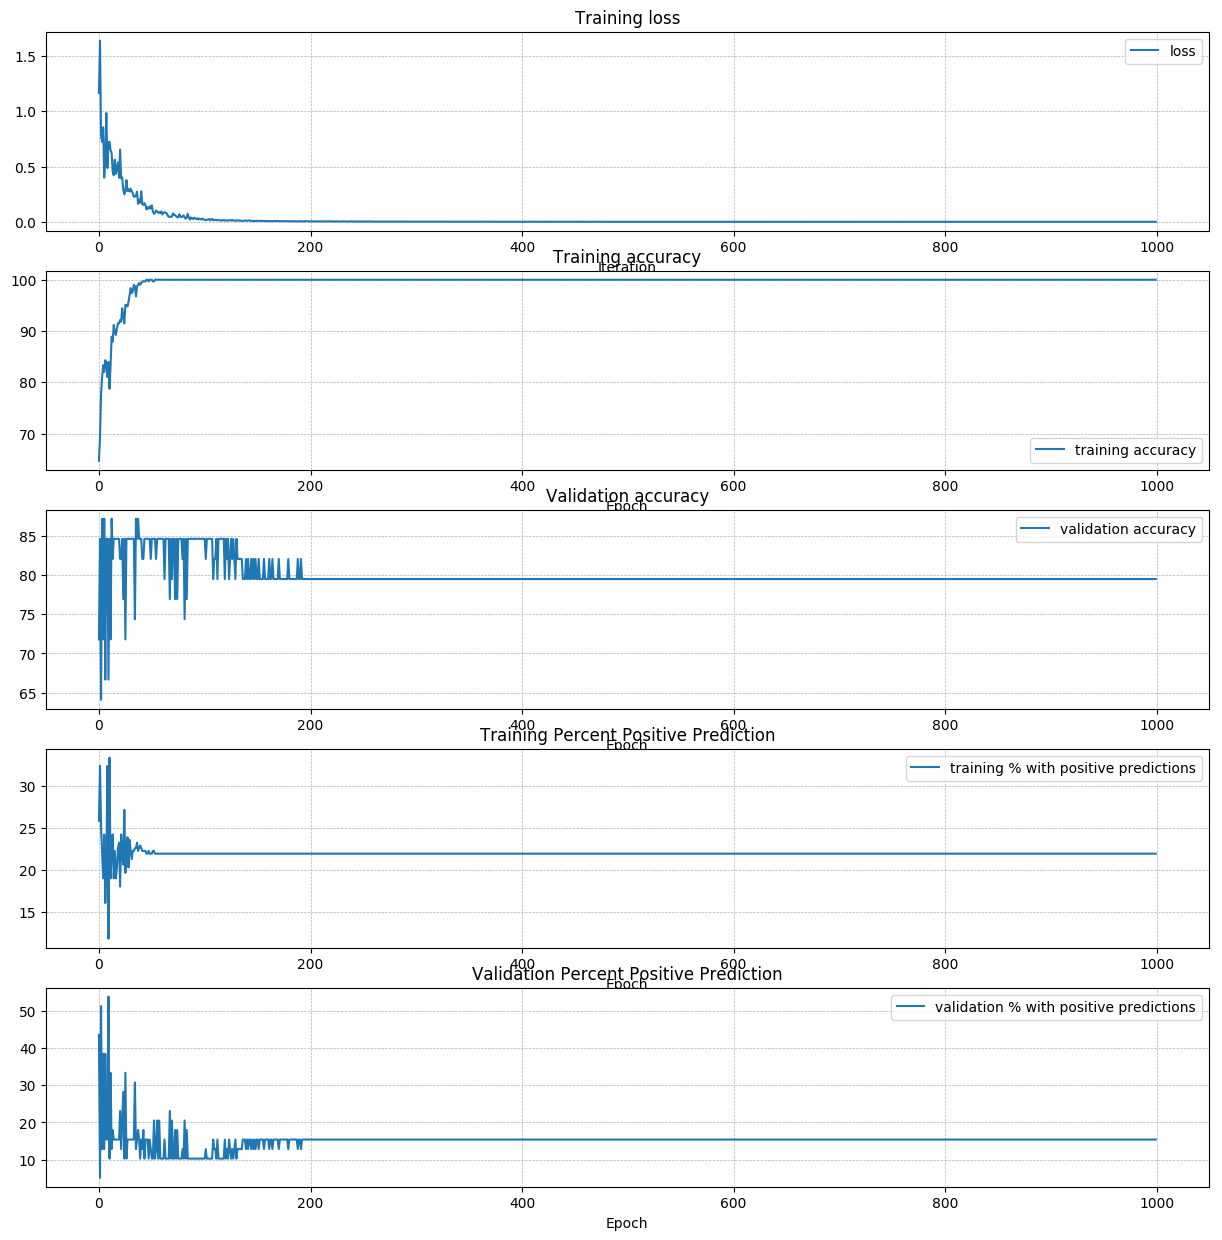

Finished running for lr: 1e-05, hidden size: 1000, epochs: 1000
Epoch 0, loss = 1.2924, train_acc = 67.3203, val_acc = 76.9231, train_pos = 22.5490, val_pos = 33.3333
Epoch 1, loss = 0.7414, train_acc = 64.0523, val_acc = 84.6154, train_pos = 46.0784, val_pos = 5.1282
Epoch 2, loss = 0.8685, train_acc = 81.0458, val_acc = 66.6667, train_pos = 10.7843, val_pos = 48.7179
Epoch 3, loss = 0.7448, train_acc = 72.2222, val_acc = 89.7436, train_pos = 37.2549, val_pos = 10.2564
Epoch 4, loss = 0.8140, train_acc = 83.9869, val_acc = 74.3590, train_pos = 7.8431, val_pos = 30.7692
Epoch 5, loss = 0.7750, train_acc = 77.4510, val_acc = 87.1795, train_pos = 32.0261, val_pos = 12.8205
Epoch 6, loss = 0.9325, train_acc = 86.9281, val_acc = 87.1795, train_pos = 12.7451, val_pos = 12.8205
Epoch 7, loss = 0.8302, train_acc = 85.6209, val_acc = 76.9231, train_pos = 18.6275, val_pos = 23.0769
Epoch 8, loss = 0.6345, train_acc = 85.2941, val_acc = 82.0513, train_pos = 20.9150, val_pos = 17.9487
Epoch 9, lo

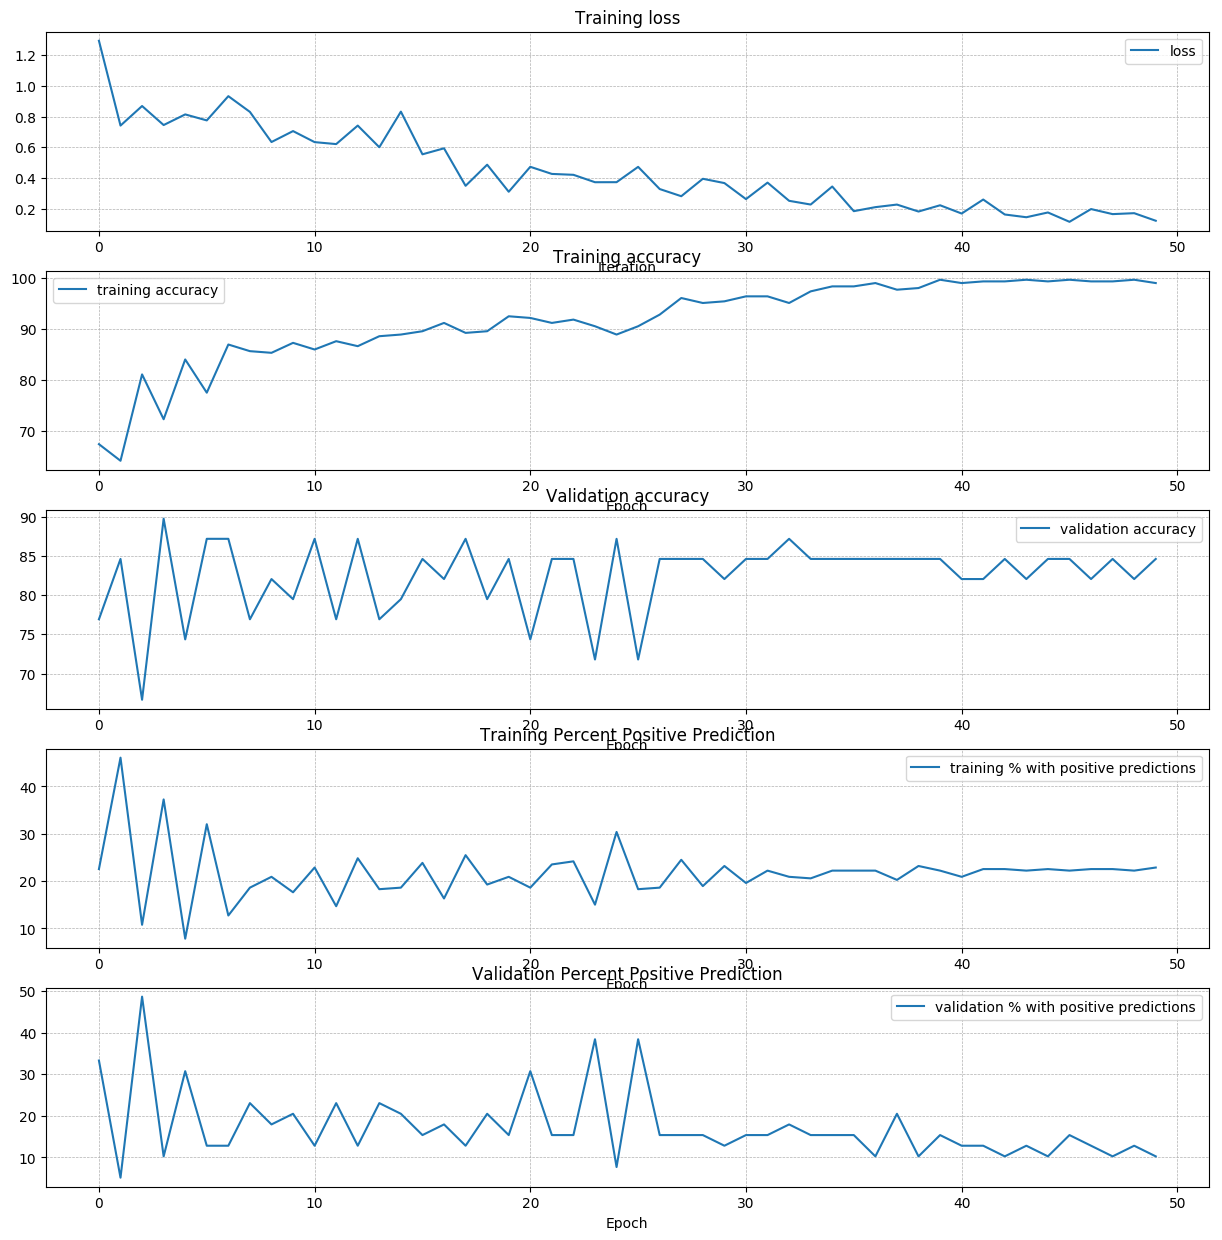

Finished running for lr: 0.0001, hidden size: 1000, epochs: 50
Epoch 0, loss = 1.1636, train_acc = 64.3791, val_acc = 79.4872, train_pos = 37.9085, val_pos = 15.3846
Epoch 1, loss = 1.0285, train_acc = 78.7582, val_acc = 82.0513, train_pos = 9.1503, val_pos = 17.9487
Epoch 2, loss = 0.8274, train_acc = 70.9150, val_acc = 76.9231, train_pos = 37.2549, val_pos = 38.4615
Epoch 3, loss = 0.7618, train_acc = 78.1046, val_acc = 89.7436, train_pos = 18.3007, val_pos = 10.2564
Epoch 4, loss = 0.7056, train_acc = 77.1242, val_acc = 71.7949, train_pos = 18.6275, val_pos = 38.4615
Epoch 5, loss = 0.8071, train_acc = 77.1242, val_acc = 84.6154, train_pos = 32.3529, val_pos = 15.3846
Epoch 6, loss = 0.8369, train_acc = 80.7190, val_acc = 89.7436, train_pos = 11.1111, val_pos = 10.2564
Epoch 7, loss = 0.6718, train_acc = 81.3725, val_acc = 74.3590, train_pos = 20.2614, val_pos = 30.7692
Epoch 8, loss = 0.9585, train_acc = 81.3725, val_acc = 87.1795, train_pos = 24.1830, val_pos = 12.8205
Epoch 9, lo

Epoch 79, loss = 0.0372, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 80, loss = 0.0459, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 81, loss = 0.0473, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 82, loss = 0.0449, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 83, loss = 0.0503, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 84, loss = 0.0432, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 85, loss = 0.0530, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 86, loss = 0.0444, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 87, loss = 0.0396, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 88, loss = 0.0271, train_acc = 100.0000, val_acc 

Epoch 157, loss = 0.0077, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 158, loss = 0.0095, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 159, loss = 0.0065, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 160, loss = 0.0076, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 161, loss = 0.0054, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 162, loss = 0.0107, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 163, loss = 0.0098, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 164, loss = 0.0061, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 165, loss = 0.0067, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 166, loss = 0.0057, train_acc = 100.0000

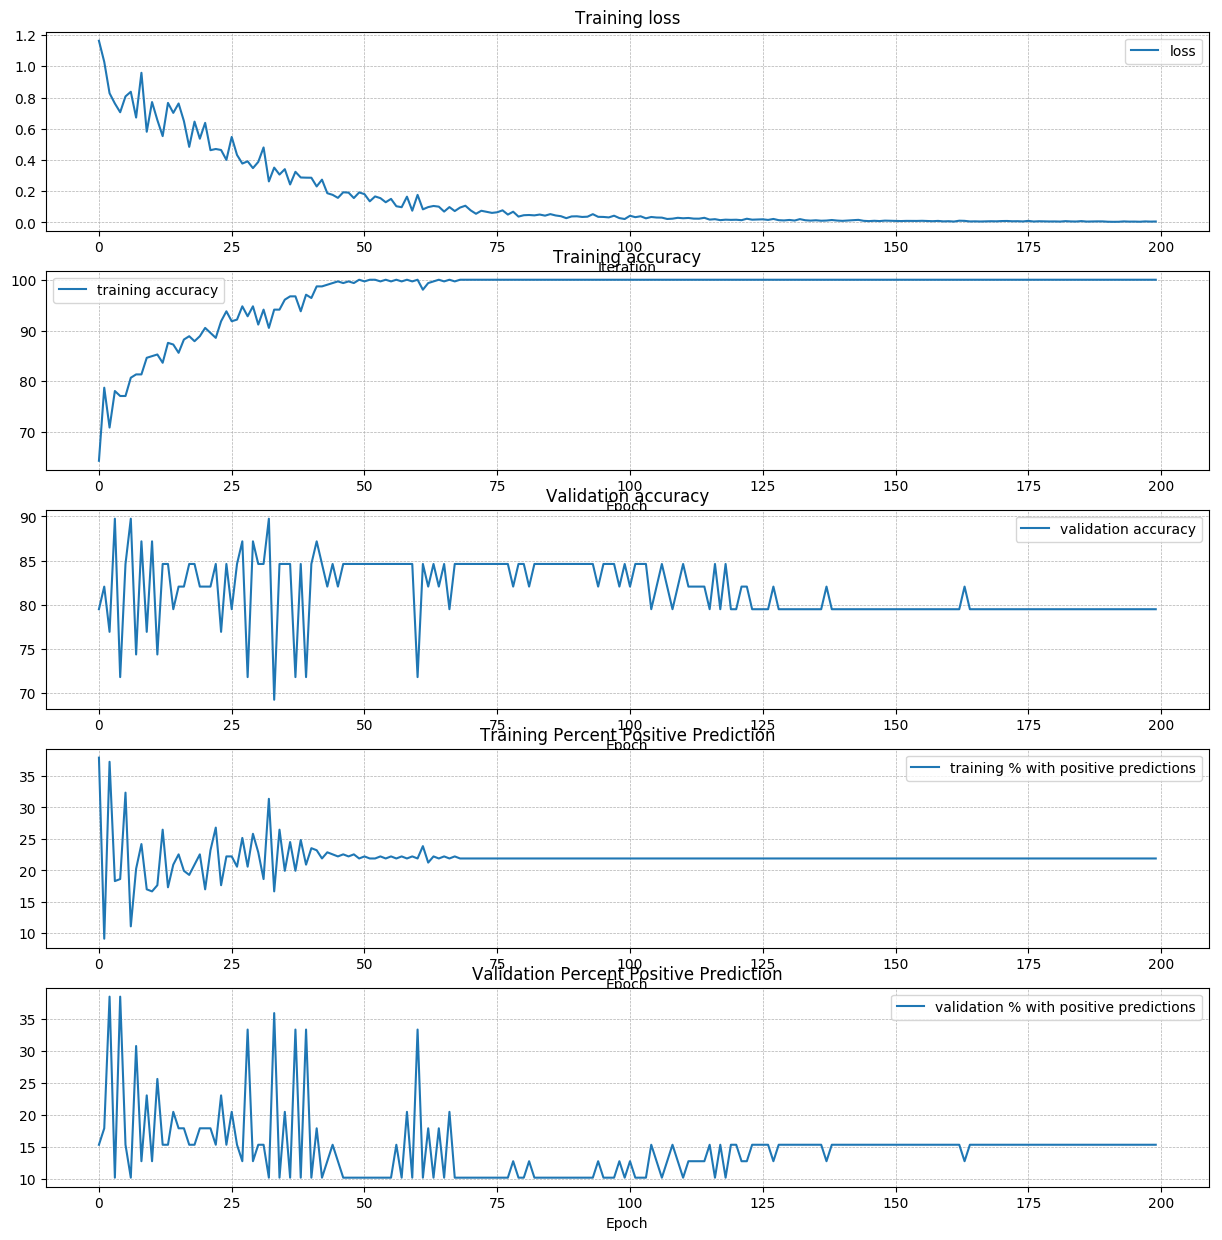

Finished running for lr: 0.0001, hidden size: 1000, epochs: 200
Epoch 0, loss = 1.2068, train_acc = 57.8431, val_acc = 79.4872, train_pos = 38.5621, val_pos = 0.0000
Epoch 1, loss = 0.8508, train_acc = 80.7190, val_acc = 82.0513, train_pos = 3.9216, val_pos = 17.9487
Epoch 2, loss = 0.9085, train_acc = 68.6275, val_acc = 74.3590, train_pos = 38.8889, val_pos = 35.8974
Epoch 3, loss = 0.8700, train_acc = 74.5098, val_acc = 82.0513, train_pos = 26.4706, val_pos = 12.8205
Epoch 4, loss = 1.0451, train_acc = 80.7190, val_acc = 84.6154, train_pos = 9.1503, val_pos = 5.1282
Epoch 5, loss = 0.9455, train_acc = 79.7386, val_acc = 82.0513, train_pos = 10.7843, val_pos = 12.8205
Epoch 6, loss = 0.7857, train_acc = 76.7974, val_acc = 84.6154, train_pos = 23.5294, val_pos = 25.6410
Epoch 7, loss = 0.5879, train_acc = 80.0654, val_acc = 82.0513, train_pos = 22.8758, val_pos = 12.8205
Epoch 8, loss = 0.6603, train_acc = 80.0654, val_acc = 87.1795, train_pos = 14.3791, val_pos = 7.6923
Epoch 9, loss 

Epoch 79, loss = 0.1747, train_acc = 99.6732, val_acc = 82.0513, train_pos = 22.2222, val_pos = 7.6923
Epoch 80, loss = 0.1177, train_acc = 99.6732, val_acc = 74.3590, train_pos = 22.2222, val_pos = 15.3846
Epoch 81, loss = 0.1402, train_acc = 99.6732, val_acc = 82.0513, train_pos = 22.2222, val_pos = 7.6923
Epoch 82, loss = 0.1521, train_acc = 99.6732, val_acc = 82.0513, train_pos = 22.2222, val_pos = 7.6923
Epoch 83, loss = 0.1519, train_acc = 99.6732, val_acc = 82.0513, train_pos = 22.2222, val_pos = 7.6923
Epoch 84, loss = 0.1451, train_acc = 99.6732, val_acc = 79.4872, train_pos = 22.2222, val_pos = 10.2564
Epoch 85, loss = 0.1803, train_acc = 99.6732, val_acc = 82.0513, train_pos = 22.2222, val_pos = 7.6923
Epoch 86, loss = 0.1077, train_acc = 99.6732, val_acc = 76.9231, train_pos = 22.2222, val_pos = 12.8205
Epoch 87, loss = 0.0882, train_acc = 99.6732, val_acc = 82.0513, train_pos = 22.2222, val_pos = 7.6923
Epoch 88, loss = 0.1438, train_acc = 99.6732, val_acc = 79.4872, train

Epoch 157, loss = 0.0274, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 158, loss = 0.0223, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 159, loss = 0.0235, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 160, loss = 0.0288, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 161, loss = 0.0239, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 162, loss = 0.0139, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 163, loss = 0.0177, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 164, loss = 0.0245, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 165, loss = 0.0242, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 166, loss = 0.0251, train_acc = 100.0000

Epoch 235, loss = 0.0099, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 236, loss = 0.0090, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 237, loss = 0.0098, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 238, loss = 0.0089, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 239, loss = 0.0091, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 240, loss = 0.0068, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 241, loss = 0.0097, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 242, loss = 0.0089, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 243, loss = 0.0060, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 244, loss = 0.0074, train_acc = 100.0000

Epoch 313, loss = 0.0035, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 314, loss = 0.0042, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 315, loss = 0.0032, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 316, loss = 0.0050, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 317, loss = 0.0037, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 318, loss = 0.0036, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 319, loss = 0.0030, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 320, loss = 0.0052, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 321, loss = 0.0037, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 322, loss = 0.0046, train_acc = 100.0000

Epoch 391, loss = 0.0032, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 392, loss = 0.0027, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 393, loss = 0.0020, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 394, loss = 0.0026, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 395, loss = 0.0032, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 396, loss = 0.0029, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 397, loss = 0.0028, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 398, loss = 0.0027, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 399, loss = 0.0018, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 400, loss = 0.0022, train_acc = 100.0000

Epoch 469, loss = 0.0015, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 470, loss = 0.0009, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 471, loss = 0.0017, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 472, loss = 0.0019, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 473, loss = 0.0013, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 474, loss = 0.0013, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 475, loss = 0.0012, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 476, loss = 0.0017, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 477, loss = 0.0019, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 478, loss = 0.0019, train_acc = 100.0000

Epoch 547, loss = 0.0009, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 548, loss = 0.0008, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 549, loss = 0.0011, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 550, loss = 0.0008, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 551, loss = 0.0008, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 552, loss = 0.0011, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 553, loss = 0.0013, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 554, loss = 0.0007, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 555, loss = 0.0009, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 556, loss = 0.0011, train_acc = 100.0000

Epoch 625, loss = 0.0006, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 626, loss = 0.0006, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 627, loss = 0.0007, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 628, loss = 0.0007, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 629, loss = 0.0006, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 630, loss = 0.0006, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 631, loss = 0.0008, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 632, loss = 0.0007, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 633, loss = 0.0006, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 634, loss = 0.0007, train_acc = 100.0000

Epoch 703, loss = 0.0006, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 704, loss = 0.0004, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 705, loss = 0.0006, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 706, loss = 0.0005, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 707, loss = 0.0006, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 708, loss = 0.0004, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 709, loss = 0.0007, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 710, loss = 0.0004, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 711, loss = 0.0003, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 712, loss = 0.0002, train_acc = 100.0000

Epoch 781, loss = 0.0002, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 782, loss = 0.0004, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 783, loss = 0.0004, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 784, loss = 0.0004, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 785, loss = 0.0004, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 786, loss = 0.0004, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 787, loss = 0.0004, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 788, loss = 0.0003, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 789, loss = 0.0003, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 790, loss = 0.0003, train_acc = 100.0000

Epoch 859, loss = 0.0003, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 860, loss = 0.0002, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 861, loss = 0.0003, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 862, loss = 0.0003, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 863, loss = 0.0002, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 864, loss = 0.0003, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 865, loss = 0.0003, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 866, loss = 0.0002, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 867, loss = 0.0001, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 868, loss = 0.0003, train_acc = 100.0000

Epoch 937, loss = 0.0002, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 938, loss = 0.0002, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 939, loss = 0.0002, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 940, loss = 0.0001, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 941, loss = 0.0002, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 942, loss = 0.0002, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 943, loss = 0.0003, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 944, loss = 0.0002, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 945, loss = 0.0001, train_acc = 100.0000, val_acc = 74.3590, train_pos = 21.8954, val_pos = 15.3846
Epoch 946, loss = 0.0001, train_acc = 100.0000

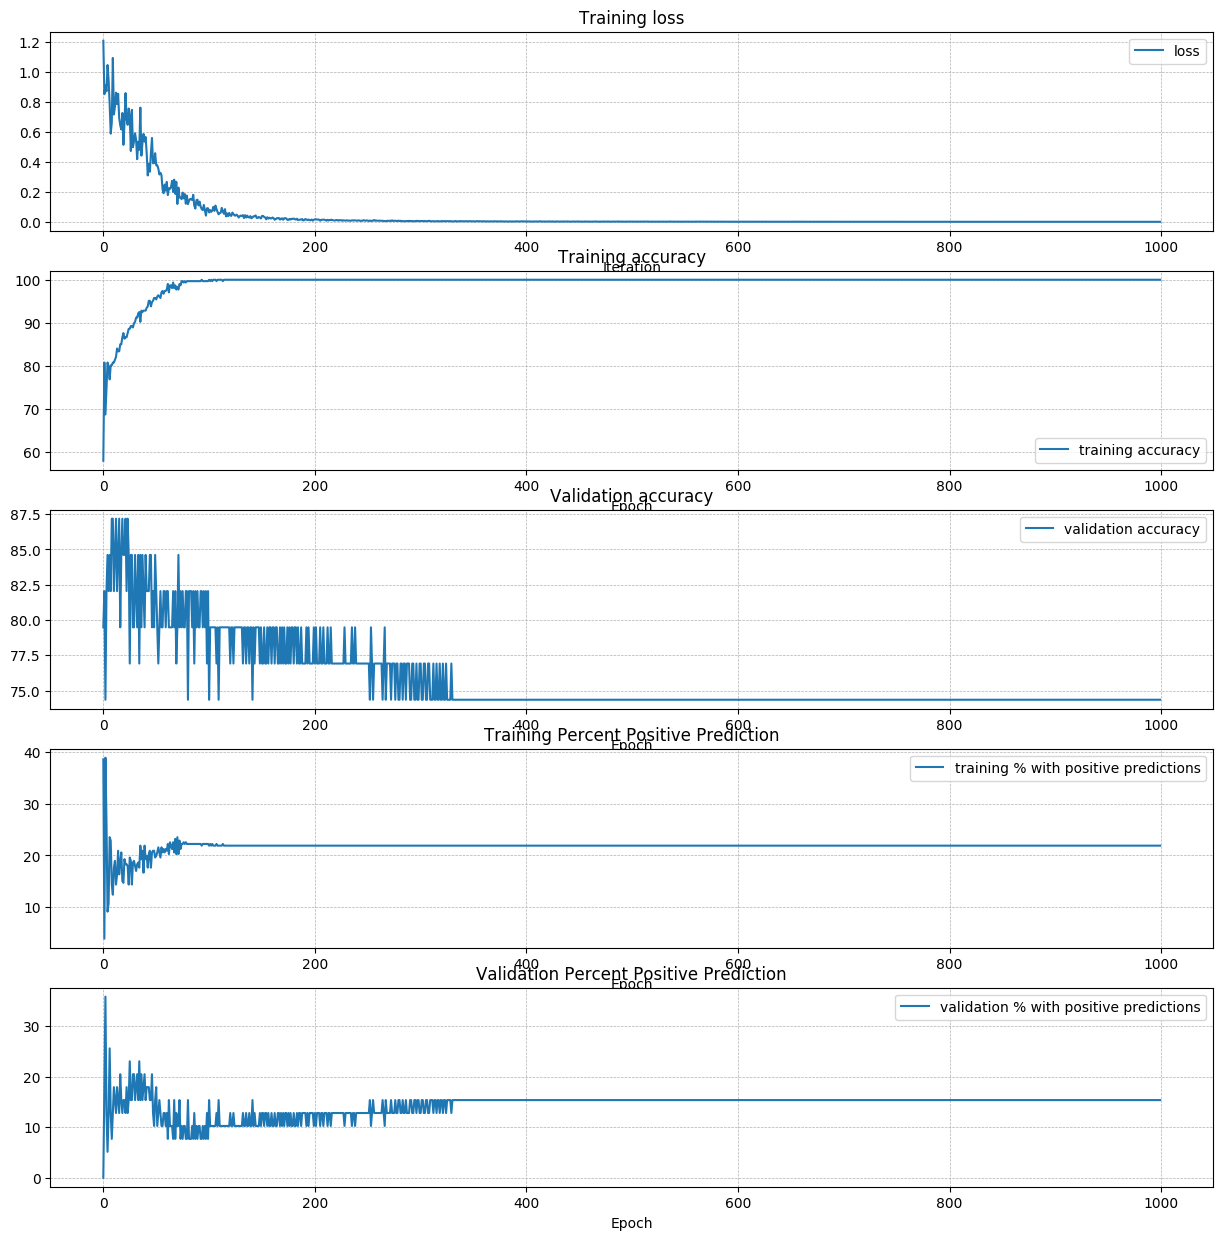

Finished running for lr: 0.0001, hidden size: 1000, epochs: 1000
Epoch 0, loss = 0.9603, train_acc = 69.9346, val_acc = 79.4872, train_pos = 29.7386, val_pos = 15.3846
Epoch 1, loss = 0.9399, train_acc = 77.4510, val_acc = 51.2821, train_pos = 13.7255, val_pos = 69.2308
Epoch 2, loss = 1.1405, train_acc = 68.3007, val_acc = 89.7436, train_pos = 35.9477, val_pos = 10.2564
Epoch 3, loss = 1.1016, train_acc = 82.3529, val_acc = 74.3590, train_pos = 12.0915, val_pos = 41.0256
Epoch 4, loss = 0.7908, train_acc = 73.2026, val_acc = 87.1795, train_pos = 37.5817, val_pos = 12.8205
Epoch 5, loss = 0.8025, train_acc = 84.3137, val_acc = 74.3590, train_pos = 12.7451, val_pos = 25.6410
Epoch 6, loss = 0.7257, train_acc = 81.0458, val_acc = 82.0513, train_pos = 23.8562, val_pos = 17.9487
Epoch 7, loss = 1.0153, train_acc = 84.6405, val_acc = 76.9231, train_pos = 15.6863, val_pos = 23.0769
Epoch 8, loss = 0.5552, train_acc = 82.3529, val_acc = 87.1795, train_pos = 32.3529, val_pos = 12.8205
Epoch 9,

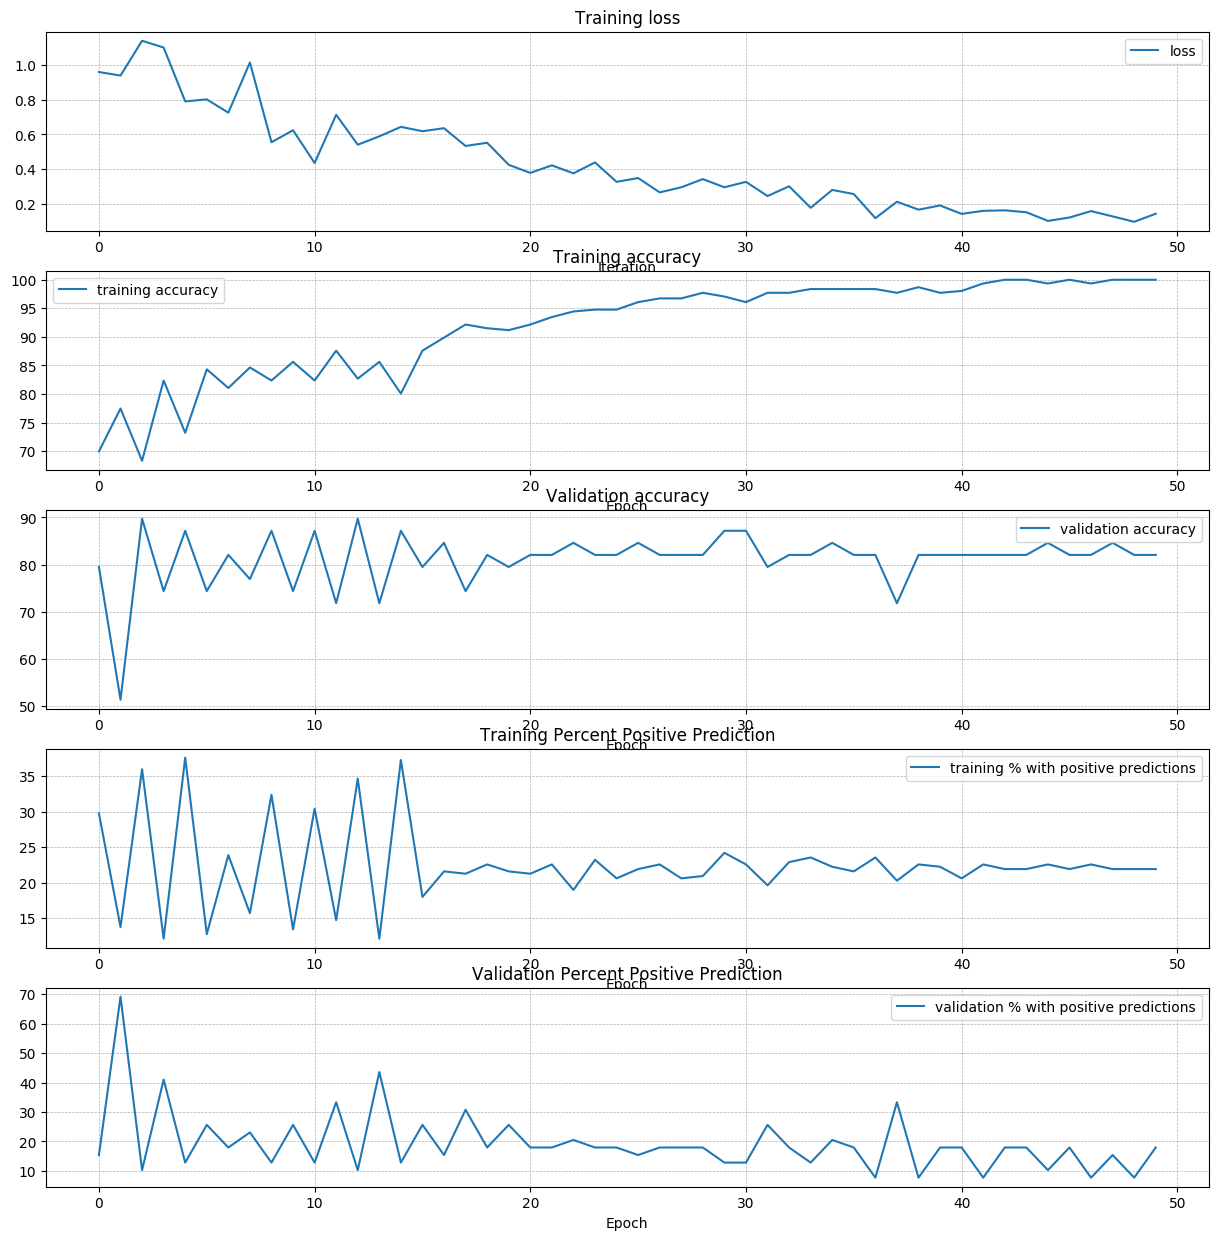

Finished running for lr: 0.001, hidden size: 1000, epochs: 50
Epoch 0, loss = 1.0123, train_acc = 68.3007, val_acc = 79.4872, train_pos = 27.4510, val_pos = 0.0000
Epoch 1, loss = 1.0908, train_acc = 76.7974, val_acc = 84.6154, train_pos = 20.9150, val_pos = 20.5128
Epoch 2, loss = 1.0542, train_acc = 80.3922, val_acc = 74.3590, train_pos = 15.3595, val_pos = 35.8974
Epoch 3, loss = 0.8431, train_acc = 72.2222, val_acc = 89.7436, train_pos = 29.4118, val_pos = 10.2564
Epoch 4, loss = 0.8784, train_acc = 83.6601, val_acc = 79.4872, train_pos = 14.7059, val_pos = 25.6410
Epoch 5, loss = 0.7188, train_acc = 80.0654, val_acc = 89.7436, train_pos = 28.7582, val_pos = 10.2564
Epoch 6, loss = 0.8056, train_acc = 80.7190, val_acc = 69.2308, train_pos = 20.2614, val_pos = 41.0256
Epoch 7, loss = 1.1233, train_acc = 81.0458, val_acc = 87.1795, train_pos = 22.5490, val_pos = 12.8205
Epoch 8, loss = 0.5869, train_acc = 74.1830, val_acc = 79.4872, train_pos = 37.9085, val_pos = 20.5128
Epoch 9, los

Epoch 79, loss = 0.0308, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 80, loss = 0.0215, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 81, loss = 0.0292, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 82, loss = 0.0364, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 83, loss = 0.0314, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 84, loss = 0.0211, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 85, loss = 0.0222, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 86, loss = 0.0210, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 87, loss = 0.0304, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 88, loss = 0.0267, train_acc = 100.0000, val_acc 

Epoch 157, loss = 0.0055, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 158, loss = 0.0068, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 159, loss = 0.0057, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 160, loss = 0.0052, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 161, loss = 0.0057, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 162, loss = 0.0049, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 163, loss = 0.0047, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 164, loss = 0.0067, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 165, loss = 0.0068, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 166, loss = 0.0032, train_acc = 100.0000

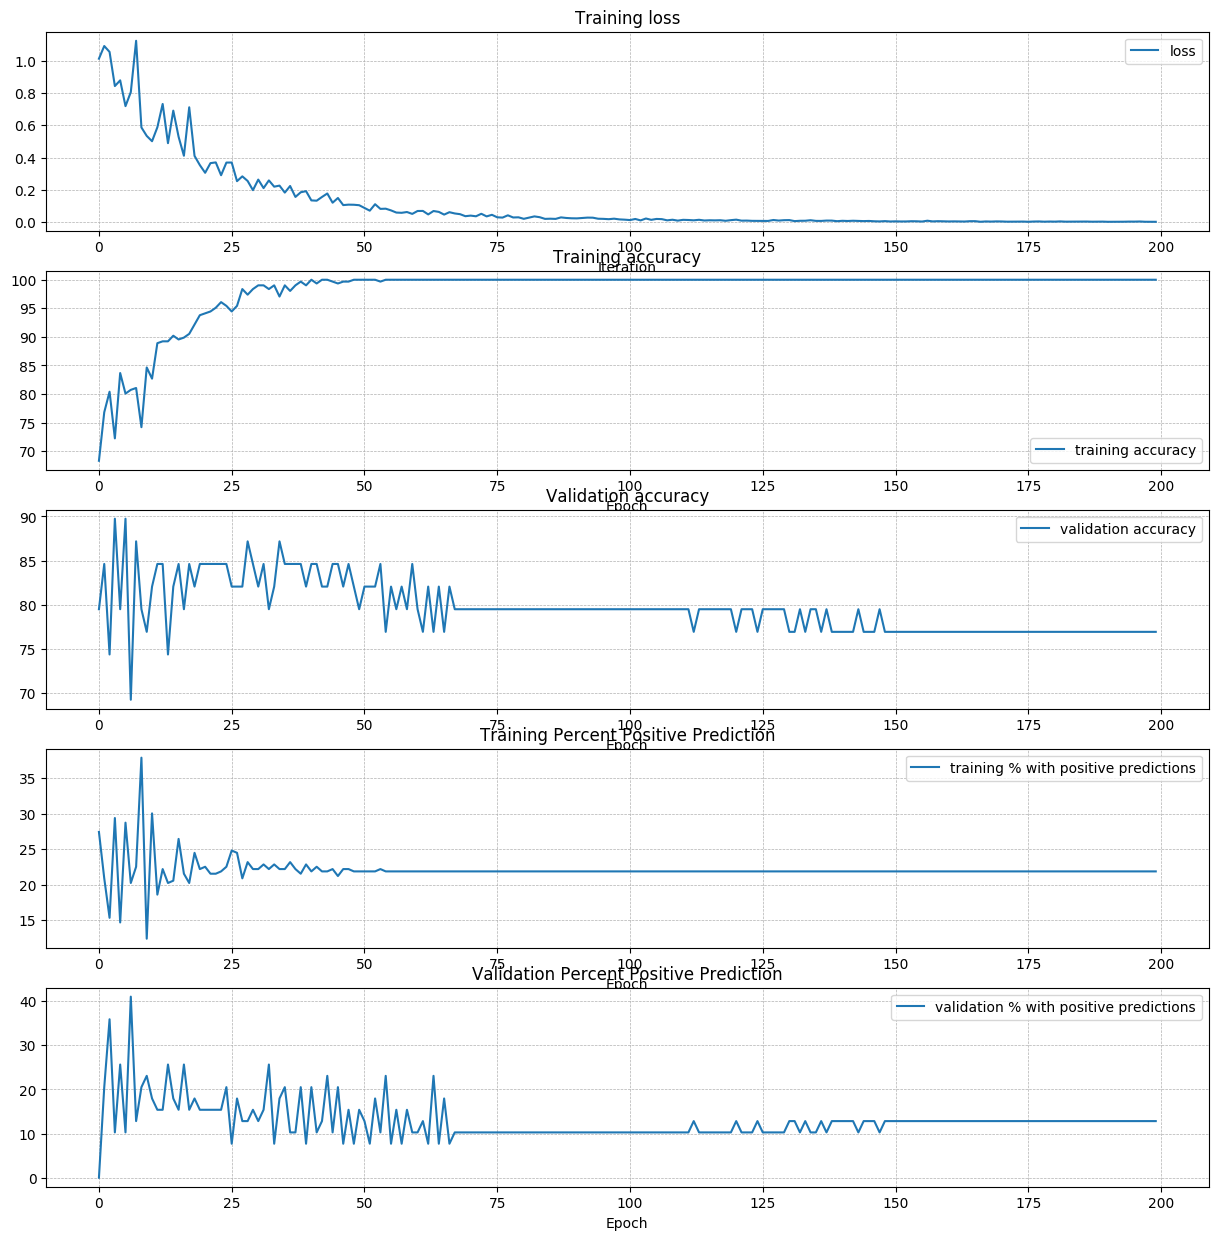

Finished running for lr: 0.001, hidden size: 1000, epochs: 200
Epoch 0, loss = 0.8865, train_acc = 68.3007, val_acc = 76.9231, train_pos = 24.1830, val_pos = 33.3333
Epoch 1, loss = 0.8670, train_acc = 75.1634, val_acc = 82.0513, train_pos = 25.1634, val_pos = 2.5641
Epoch 2, loss = 1.0401, train_acc = 78.1046, val_acc = 53.8462, train_pos = 20.9150, val_pos = 66.6667
Epoch 3, loss = 1.6706, train_acc = 72.2222, val_acc = 89.7436, train_pos = 26.1438, val_pos = 10.2564
Epoch 4, loss = 0.9130, train_acc = 66.9935, val_acc = 71.7949, train_pos = 39.2157, val_pos = 38.4615
Epoch 5, loss = 0.6818, train_acc = 82.0261, val_acc = 84.6154, train_pos = 15.6863, val_pos = 10.2564
Epoch 6, loss = 0.8139, train_acc = 77.1242, val_acc = 74.3590, train_pos = 27.1242, val_pos = 35.8974
Epoch 7, loss = 0.8157, train_acc = 84.6405, val_acc = 87.1795, train_pos = 15.0327, val_pos = 12.8205
Epoch 8, loss = 0.7583, train_acc = 83.9869, val_acc = 74.3590, train_pos = 26.7974, val_pos = 25.6410
Epoch 9, lo

Epoch 79, loss = 0.0423, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 80, loss = 0.0721, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 81, loss = 0.0488, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 82, loss = 0.0532, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 83, loss = 0.0431, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 84, loss = 0.0364, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 85, loss = 0.0479, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 86, loss = 0.0434, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 87, loss = 0.0624, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 88, loss = 0.0488, train_acc = 100.0000, val_acc 

Epoch 157, loss = 0.0104, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 158, loss = 0.0088, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 159, loss = 0.0083, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 160, loss = 0.0099, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 161, loss = 0.0119, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 162, loss = 0.0064, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 163, loss = 0.0089, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 164, loss = 0.0073, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 165, loss = 0.0062, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 166, loss = 0.0083, train_acc = 100.0000

Epoch 235, loss = 0.0040, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 236, loss = 0.0037, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 237, loss = 0.0025, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 238, loss = 0.0040, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 239, loss = 0.0024, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 240, loss = 0.0020, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 241, loss = 0.0031, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 242, loss = 0.0026, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 243, loss = 0.0031, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 244, loss = 0.0026, train_acc = 100.0000

Epoch 313, loss = 0.0013, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 314, loss = 0.0010, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 315, loss = 0.0017, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 316, loss = 0.0018, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 317, loss = 0.0018, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 318, loss = 0.0019, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 319, loss = 0.0014, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 320, loss = 0.0013, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 321, loss = 0.0012, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 322, loss = 0.0018, train_acc = 100.0000

Epoch 391, loss = 0.0010, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 392, loss = 0.0010, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 393, loss = 0.0011, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 394, loss = 0.0007, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 395, loss = 0.0014, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 396, loss = 0.0010, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 397, loss = 0.0009, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 398, loss = 0.0006, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 399, loss = 0.0010, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 400, loss = 0.0008, train_acc = 100.0000

Epoch 469, loss = 0.0006, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 470, loss = 0.0007, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 471, loss = 0.0006, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 472, loss = 0.0005, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 473, loss = 0.0005, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 474, loss = 0.0007, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 475, loss = 0.0008, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 476, loss = 0.0007, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 477, loss = 0.0006, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 478, loss = 0.0005, train_acc = 100.0000

Epoch 547, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 548, loss = 0.0003, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 549, loss = 0.0005, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 550, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 551, loss = 0.0005, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 552, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 553, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 554, loss = 0.0006, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 555, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 556, loss = 0.0003, train_acc = 100.0000

Epoch 625, loss = 0.0003, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 626, loss = 0.0003, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 627, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 628, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 629, loss = 0.0003, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 630, loss = 0.0003, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 631, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 632, loss = 0.0004, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 633, loss = 0.0003, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 634, loss = 0.0002, train_acc = 100.0000

Epoch 703, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 704, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 705, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 706, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 707, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 708, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 709, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 710, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 711, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 712, loss = 0.0002, train_acc = 100.0000

Epoch 781, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 782, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 783, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 784, loss = 0.0002, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 785, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 786, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 787, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 788, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 789, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 790, loss = 0.0002, train_acc = 100.0000

Epoch 859, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 860, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 861, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 862, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 863, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 864, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 865, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 866, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 867, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 868, loss = 0.0001, train_acc = 100.0000

Epoch 937, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 938, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 939, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 940, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 941, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 942, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 943, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 944, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 945, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 946, loss = 0.0001, train_acc = 100.0000

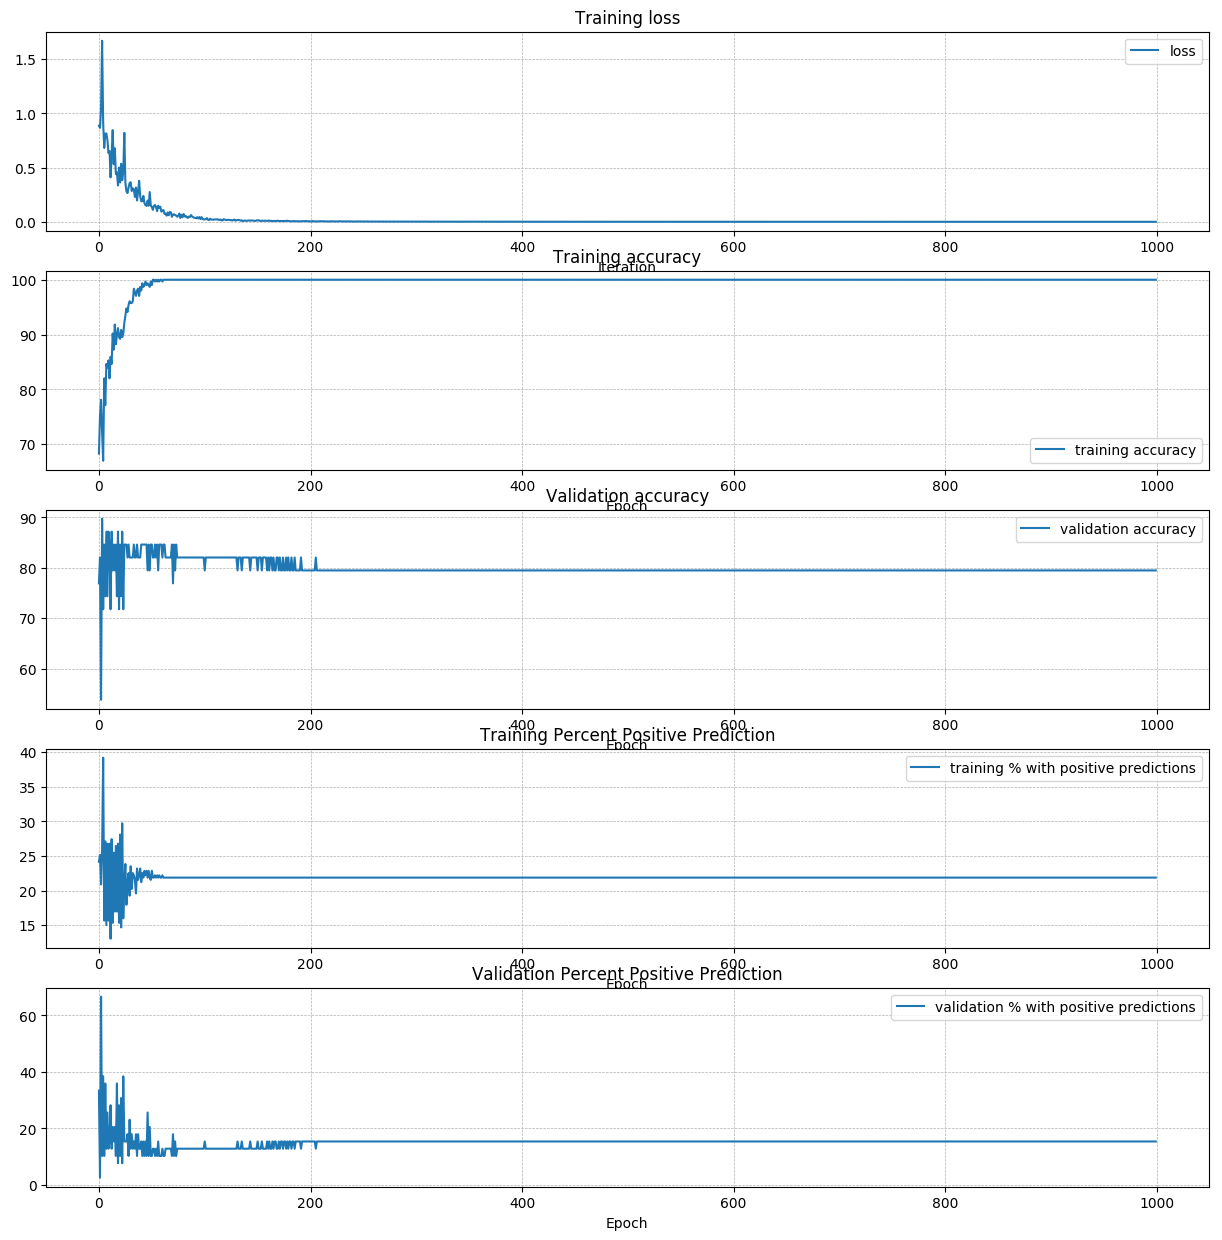

Finished running for lr: 0.001, hidden size: 1000, epochs: 1000
Epoch 0, loss = 1.2885, train_acc = 59.4771, val_acc = 48.7179, train_pos = 39.5425, val_pos = 71.7949
Epoch 1, loss = 1.0443, train_acc = 70.5882, val_acc = 84.6154, train_pos = 27.1242, val_pos = 5.1282
Epoch 2, loss = 1.1548, train_acc = 80.0654, val_acc = 84.6154, train_pos = 13.7255, val_pos = 20.5128
Epoch 3, loss = 0.7961, train_acc = 73.5294, val_acc = 82.0513, train_pos = 27.4510, val_pos = 17.9487
Epoch 4, loss = 0.9291, train_acc = 79.4118, val_acc = 87.1795, train_pos = 16.3399, val_pos = 12.8205
Epoch 5, loss = 0.8103, train_acc = 79.7386, val_acc = 87.1795, train_pos = 16.0131, val_pos = 17.9487
Epoch 6, loss = 0.8127, train_acc = 82.0261, val_acc = 87.1795, train_pos = 20.2614, val_pos = 12.8205
Epoch 7, loss = 0.6860, train_acc = 83.6601, val_acc = 82.0513, train_pos = 16.6667, val_pos = 17.9487
Epoch 8, loss = 0.7077, train_acc = 80.3922, val_acc = 82.0513, train_pos = 26.4706, val_pos = 17.9487
Epoch 9, l

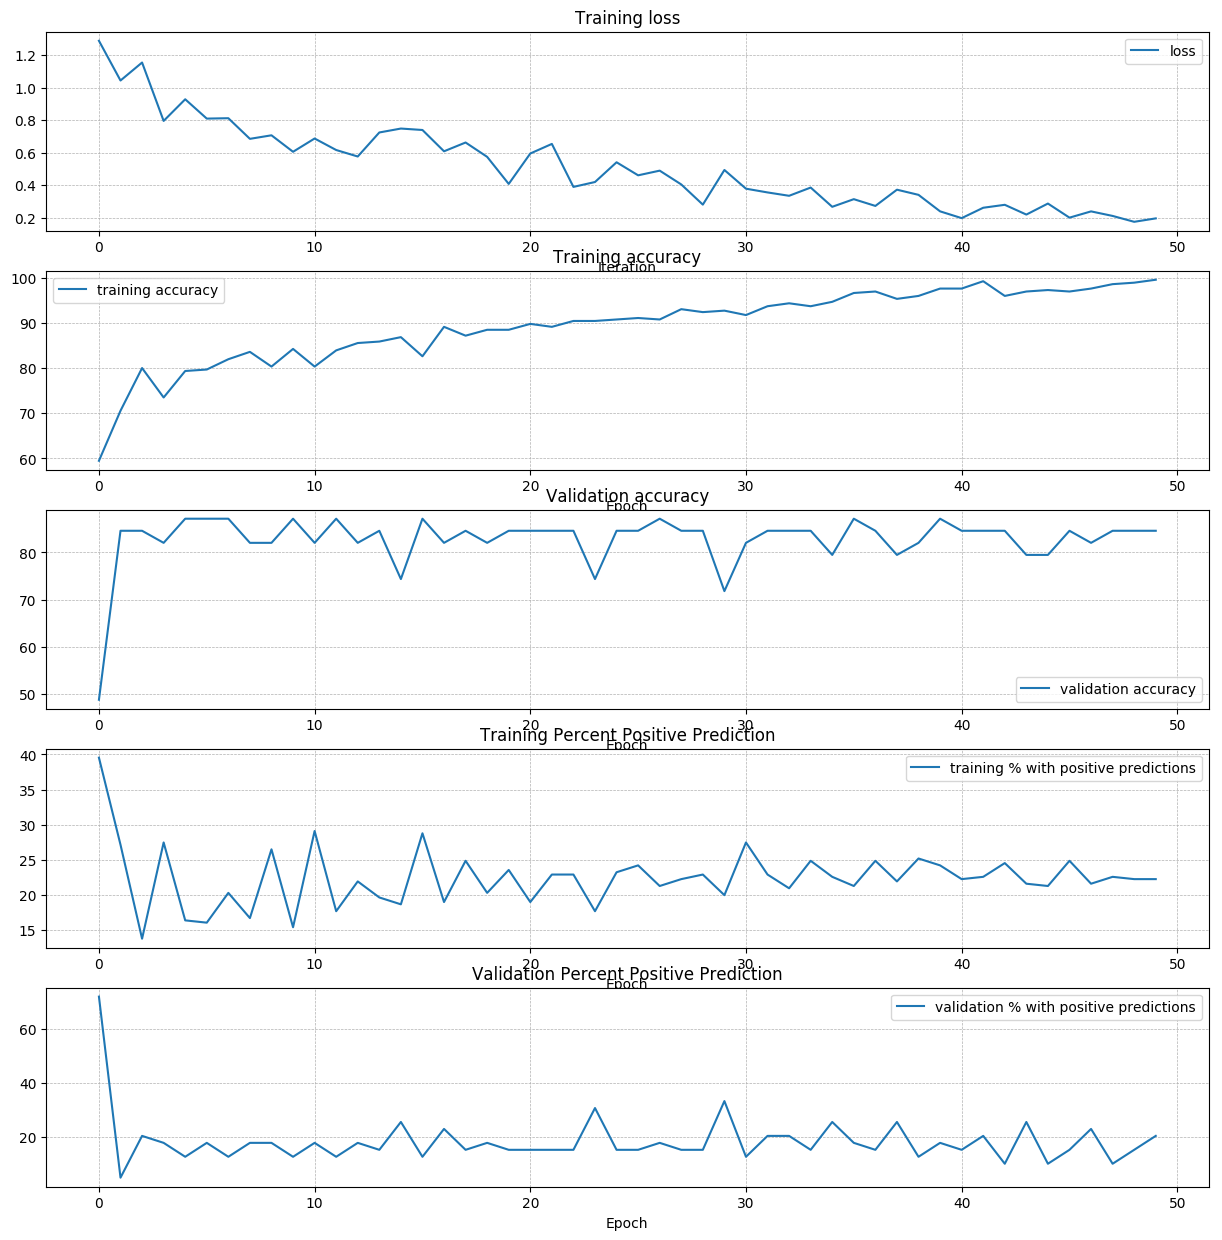

Finished running for lr: 0.01, hidden size: 1000, epochs: 50
Epoch 0, loss = 1.0261, train_acc = 69.2810, val_acc = 79.4872, train_pos = 30.3922, val_pos = 0.0000
Epoch 1, loss = 0.8421, train_acc = 81.3725, val_acc = 56.4103, train_pos = 6.5359, val_pos = 58.9744
Epoch 2, loss = 0.6202, train_acc = 69.2810, val_acc = 87.1795, train_pos = 39.5425, val_pos = 12.8205
Epoch 3, loss = 0.8563, train_acc = 81.3725, val_acc = 76.9231, train_pos = 12.4183, val_pos = 28.2051
Epoch 4, loss = 0.7638, train_acc = 75.8170, val_acc = 79.4872, train_pos = 34.9673, val_pos = 20.5128
Epoch 5, loss = 0.7911, train_acc = 83.3333, val_acc = 87.1795, train_pos = 11.7647, val_pos = 12.8205
Epoch 6, loss = 0.8639, train_acc = 75.1634, val_acc = 82.0513, train_pos = 33.0065, val_pos = 23.0769
Epoch 7, loss = 0.6450, train_acc = 83.3333, val_acc = 87.1795, train_pos = 14.3791, val_pos = 12.8205
Epoch 8, loss = 0.6760, train_acc = 80.3922, val_acc = 74.3590, train_pos = 23.8562, val_pos = 25.6410
Epoch 9, loss 

Epoch 79, loss = 0.0425, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 80, loss = 0.0680, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 81, loss = 0.0348, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 82, loss = 0.0580, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 83, loss = 0.0630, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 84, loss = 0.0367, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 85, loss = 0.0464, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 86, loss = 0.0351, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 87, loss = 0.0337, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 88, loss = 0.0308, train_acc = 100.0000, val_acc 

Epoch 157, loss = 0.0055, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 158, loss = 0.0088, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 159, loss = 0.0073, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 160, loss = 0.0077, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 161, loss = 0.0061, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 162, loss = 0.0096, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 163, loss = 0.0057, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 164, loss = 0.0082, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564
Epoch 165, loss = 0.0057, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 10.2564


In [ ]:
# use weighted loss instead of oversampling 
train = CustomDataset(dataframe=train_data, transform=None)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=None)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=None)
loader_test = DataLoader(test, batch_size=64)

input_size = 77061
hidden_sizes = [100, 1000, 2000, 5000, 10000]
lrs = [0.000001, 0.00001, 0.0001, 0.001, 0.01]
epochs = [50, 200, 1000]
num_samples_pos = train_data[train_data['OA_check']==1].shape[0]
num_samples_neg = train_data[train_data['OA_check']==0].shape[0]
num_classes = 1

best_model = None
best_val = 0
accuracies = {}

for hidden_size in hidden_sizes:
    for lr in lrs: 
        for num_epochs in epochs:
            model = Barebones_model(input_size, hidden_size, num_classes)
            optimizer = optim.Adam(model.parameters(), lr=0.0001)
            loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=num_epochs, \
                use_BCE_weight=True, num_samples_pos=num_samples_pos, num_samples_neg=num_samples_neg)

            fig, axes = plt.subplots(5, 1, figsize=(15, 15))

            axes[0].set_title('Training loss')
            axes[0].set_xlabel('Iteration')
            axes[1].set_title('Training accuracy')
            axes[1].set_xlabel('Epoch')
            axes[2].set_title('Validation accuracy')
            axes[2].set_xlabel('Epoch')
            axes[3].set_title('Training Percent Positive Prediction')
            axes[3].set_xlabel('Epoch')
            axes[4].set_title('Validation Percent Positive Prediction')
            axes[4].set_xlabel('Epoch')

            axes[0].plot(loss, label="loss")
            axes[1].plot(train_acc, label="training accuracy")
            axes[2].plot(val_acc, label="validation accuracy")
            axes[3].plot(train_pos, label="training % with positive predictions")
            axes[4].plot(val_pos, label="validation % with positive predictions")

            for ax in axes:
                ax.legend(loc='best', ncol=4)
                ax.grid(linestyle='--', linewidth=0.5)

            plt.show()

            if best_val < val_acc[-1]:
                best_val = val_acc[-1]
                best_model = model
            
            accuracies["lr: {}, hidden size: {}, epochs: {}".format(lr, hidden_size, num_epochs)] = val_acc[-1]
            print("Finished running for lr: {}, hidden size: {}, epochs: {}".format(lr, hidden_size, num_epochs))